# Load packages and defaults

In [1]:
import os
from typing import Literal

# Move two levels up work from project level, not location of analysis file
os.chdir('../..')
print('Working dir:', os.getcwd())

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import pandas as pd
import seaborn as sns

import statsmodels.formula.api as smf
from statsmodels.stats.anova import anova_lm

from scipy import stats
from scipy import optimize
from scipy.interpolate import interpn
from scipy import integrate

from Analyses.SDC_singlePulse_fixedIntensity.tools import *
from Analyses.SDC_singlePulse_fixedIntensity import loader
import Functions.globalFunctions.ExtracellularField as EcF
from Analyses.functionsAnalysis import *


%matplotlib inline
recollect = False

# Figure for paper
font = {'family': 'helvetica',
        'size': 10}
mpl.rc('font', **font)
colors_crest = np.array(sns.color_palette("crest", n_colors=10))
colors_crest = colors_crest[[0,2,5,8],:]
cmap_tab20 = np.array(mpl.cm.get_cmap('tab20').colors)

colors = np.array(sns.color_palette("crest", n_colors=10))
colors = colors[[0, 2, 5, 8], :]
crestcmap_pvalue = LinearSegmentedColormap.from_list('my_cmap', colors, N=colors.shape[0])
boundaries = [0.001, 0.01, 0.05, 1.0]
boundnorm_pvalue = mpl.cm.colors.BoundaryNorm(
    boundaries, len(boundaries), extend='min')

def myfun(x, y): return list(mpl.colors.to_rgb(x))+[y]

colorkeyval = {'soma': myfun('tab:red', 1), 'axon': myfun('tomato', 1), 'apic': myfun('seagreen', 1),
                'basaldend': myfun('teal', 1), 'alldend': myfun('tab:cyan',1), 'allsec': myfun('tab:blue', 1),
                'pyr_1': list(cmap_tab20[2,:])+[1],'pyr_2': list(cmap_tab20[3,:])+[1],
                'pyr_3': list(cmap_tab20[4,:])+[1],'pyr_4': list(cmap_tab20[5,:])+[1],
                'bc_1': list(cmap_tab20[8,:])+[1],'bc_2': list(cmap_tab20[9,:])+[1], 'unclassified': [0, 0, 0]}
stylekeyval = {'pyr_1': '-', 'pyr_2': '--', 'bc_1': ':', 'bc_2': '-.'}

surfaces = {'soma': {'pyr_1': 699.46, 'pyr_2': 417.85, 'bc_1': 778.12, 'bc_2': 1375.16},
            'axon': {'pyr_1': 1640.70, 'pyr_2': 1051.43, 'bc_1': 106424.01, 'bc_2': 25256.23},
            'basaldend': {'pyr_1': 5930.95, 'pyr_2': 10670.46, 'bc_1': np.nan, 'bc_2': np.nan},
            'apic': {'pyr_1': 14786.82, 'pyr_2': 13631.61, 'bc_1': np.nan, 'bc_2': np.nan},
            'alldend': {'pyr_1': 20717.77, 'pyr_2': 24170.88, 'bc_1': 21827.34, 'bc_2': 21949.07},
            'allsec': {'pyr_1': 23057.93, 'pyr_2': 25640.17, 'bc_1': 129029.47, 'bc_2': 48580.46}}


Working dir: d:\Users\rschoete\Documents\Optogenetics\OptogeneticExcitability\Code


# Loading raw data
stored in master_df

unique_values_columns_master contains all unique values for each column

SDC_contI_v2:
    contains more datapoints wrt dur and Gmax
    More important the axon is included in the model simulation (ie, not substituted for a stub axon)

In [2]:
# Load data
filepath = './Results/SDC/SDC_constI_v2'
drop_columns = ['opsinmech', 'distribution', 'distribution_method',
                'theta_0', 'psi_0', 'phi_0', 'seed', 'celsius', 'dt', 'field']

# list parameters of interest
cell_init_options = ['phi_0', 'theta_0',
                     'psi_0', 'neurontemplate', 'morphology']
settings_options = ['seed', 'celsius', 'dt']
opsin_options = ['Gmax', 'distribution', 'opsinmech',
                 'distribution_method', 'opsinlocations']
field_options = ['field', 'nPulse']
result = ['amp', 'sR', 'ichr2', 'gchr2', 'dur']
all_columns = result+field_options+opsin_options + \
    cell_init_options+settings_options

# opsinlocations to single word
opsinLocation_map = loader.opsinLocation_map
master_df = loader.load_data_df(filepath=filepath, filename='all_data.csv', recollect=recollect, result=result, all_columns=all_columns, cell_init_options=cell_init_options,
                                settings_options=settings_options, opsin_options=opsin_options, field_options=field_options, fill_missing_xyzpositions=True, save_recollect=True, savename=None)
master_df['amp'] = master_df['amp']/1000  # convert W/m2 -> mW/mm2
master_df['TAC'] = -master_df['ichr2']/master_df['dur'] * \
    1e-5  # convert to uA (ichr2: mA/cm2*um2)
master_df['Gmax'] = np.round(master_df['Gmax'], 4)
master_df['dur'] = np.round(master_df['dur'], 4)
for x in ['amp', 'Gmax', 'TAC', 'dur']:
    master_df[x+'_log10'] = np.round(np.log10(master_df[x]), 4)
master_df = master_df.drop(drop_columns, axis=1)
master_df['neurontemplate'] = master_df['neurontemplate'].replace(
    {'CA1_PC_cAC_sig5': 'pyr_1', 'CA1_PC_cAC_sig6': 'pyr_2', 'cNACnoljp1': 'bc_1', 'cNACnoljp2': 'bc_2'})
if 'morphology' in master_df.columns:
    master_df['morphology'] = master_df['morphology'].replace(
        {np.nan: 'default'})
print('!!!!!!!!!!!!!!excluding Gmax <0.1!!!!!!!')
master_df = master_df[master_df['Gmax'] >= 0.099]

all_columns = master_df.columns
all_settings_columns = [x for x in all_columns if (not x in drop_columns) and (
    not any([y in x for y in result[:-1]+['TAC']]))]
unique_values_columns_master = {
    key: master_df[key].unique() for key in all_columns}
for x in ['amp', 'Gmax', 'TAC', 'dur']:
    unique_values_columns_master[x] = np.sort(unique_values_columns_master[x])
    unique_values_columns_master[x+'_log10'] = np.sort(
        unique_values_columns_master[x+'_log10'])

print('all coluumn names:\n\t', all_columns.to_numpy())
print('all settings:\n\t', all_settings_columns)
print('Total number of entries:\n\t', len(master_df))
for k in all_settings_columns:
    print(f'unique entries {k}:\n\t', len(
        unique_values_columns_master[k]), ': ', unique_values_columns_master[k])
    if 'Gmax' in k:
        print('2 sets: ', np.unique(master_df.loc[master_df['opsinlocations'] == 'soma', 'Gmax']), '\n ', np.unique(
            master_df.loc[master_df['opsinlocations'] == 'allsec', 'Gmax']))

master_df.describe()

!!!!!!!!!!!!!!excluding Gmax <0.1!!!!!!!
all coluumn names:
	 ['amp' 'sR' 'ichr2' 'gchr2' 'dur' 'nPulse' 'Gmax' 'opsinlocations'
 'neurontemplate' 'morphology' 'TAC' 'amp_log10' 'Gmax_log10' 'TAC_log10'
 'dur_log10']
all settings:
	 ['dur', 'nPulse', 'Gmax', 'opsinlocations', 'neurontemplate', 'morphology', 'Gmax_log10', 'dur_log10']
Total number of entries:
	 2844
unique entries dur:
	 9 :  [1.000000e-01 3.162000e-01 1.000000e+00 3.162300e+00 1.000000e+01
 3.162280e+01 1.000000e+02 3.162278e+02 1.000000e+03]
unique entries nPulse:
	 1 :  [1]
unique entries Gmax:
	 17 :  [  0.1      0.2154   0.2276   0.4642   0.5179   1.       1.1788   2.1544
   2.6827   4.6416   6.1054  10.      13.895   21.5443  31.6228  46.4159
 100.    ]
2 sets:  [ 0.1     0.2154  0.2276  0.4642  0.5179  1.      1.1788  2.1544  2.6827
  4.6416  6.1054 10.     13.895  31.6228] 
  [  0.1      0.2154   0.2276   0.4642   0.5179   1.       1.1788   2.1544
   2.6827   4.6416   6.1054  10.      13.895   21.5443  31.6228  

amp      sR         ichr2        gchr2          dur  nPulse  \
count  2340.000000  2340.0  2.844000e+03  2844.000000  2844.000000  2844.0   
mean     15.062741     1.0 -1.200311e+04     5.050296   162.492122     1.0   
std     241.905714     0.0  5.763551e+04    32.244647   311.588255     0.0   
min       0.000034     1.0 -1.656716e+06  -822.663900     0.100000     1.0   
25%       0.005829     1.0 -6.675028e+03     0.249675     1.000000     1.0   
50%       0.046225     1.0 -1.789371e+03     0.562950    10.000000     1.0   
75%       0.360616     1.0 -1.096063e+03     2.540025   100.000000     1.0   
max    8523.437500     1.0 -7.907400e+01   779.016900  1000.000000     1.0   

              Gmax          TAC    amp_log10   Gmax_log10    TAC_log10  \
count  2844.000000  2844.000000  2340.000000  2844.000000  2844.000000   
mean     11.112780     0.038960    -1.311057     0.379741    -2.547467   
std      21.032107     0.290313     1.265881     0.827810     0.969821   
min       0.100000     0.000043    -4.473700    -1.000000    -4.367900   
25%       0.464200     0.000454    -2.234400    -0.333300    -3.342575   
50%       2.154400     0.001688    -1.335150     0.333300    -2.772550   
75%      10.000000     0.014740    -0.442950     1.000000    -1.831475   
max     100.000000    12.761321     3.930600     2.000000     1.105900   

         dur_log10  
count  2844.000000  
mean      1.000000  
std       1.291221  
min      -1.000000  
25%       0.000000  
50%       1.000000  
75%       2.000000  
max       3.000000

In [3]:
# test selector
myselection = {key: unique_values_columns_master[key][0]
               for key in all_settings_columns if not '_log10' in key}
myselection['dur'] = 100
myselection['Gmax'] = 1
intm_df = master_df[selection_generator(
    master_df, unique_values_columns_master, verbose=False, **myselection)].reset_index(drop=True)
intm_df.head(len(intm_df))

amp   sR      ichr2   gchr2    dur  nPulse  Gmax opsinlocations  \
0  0.074995  1.0 -4329.0184  1.3413  100.0       1   1.0        alldend   

  neurontemplate morphology       TAC  amp_log10  Gmax_log10  TAC_log10  \
0          pyr_1    default  0.000433     -1.125         0.0    -3.3636   

   dur_log10  
0        2.0

## Data visualization

Surface plots
- 1 figure per neuron template
- each row is opsin location
- x is duration
- y is Gmax
- color is Intensity/TAC/g_chr2

Intensity: Both Gmax and dur dependence for Intensity\
TAC: Gmax dependance appears to dissapear for TAC except with long pulse durations \
g_chr2: To be analysed

{'opsinlocations': array(['alldend', 'allsec', 'apic', 'axon', 'basaldend', 'soma'],
      dtype=object), 'neurontemplate': array(['pyr_1', 'pyr_2', 'bc_1', 'bc_2'], dtype=object)}






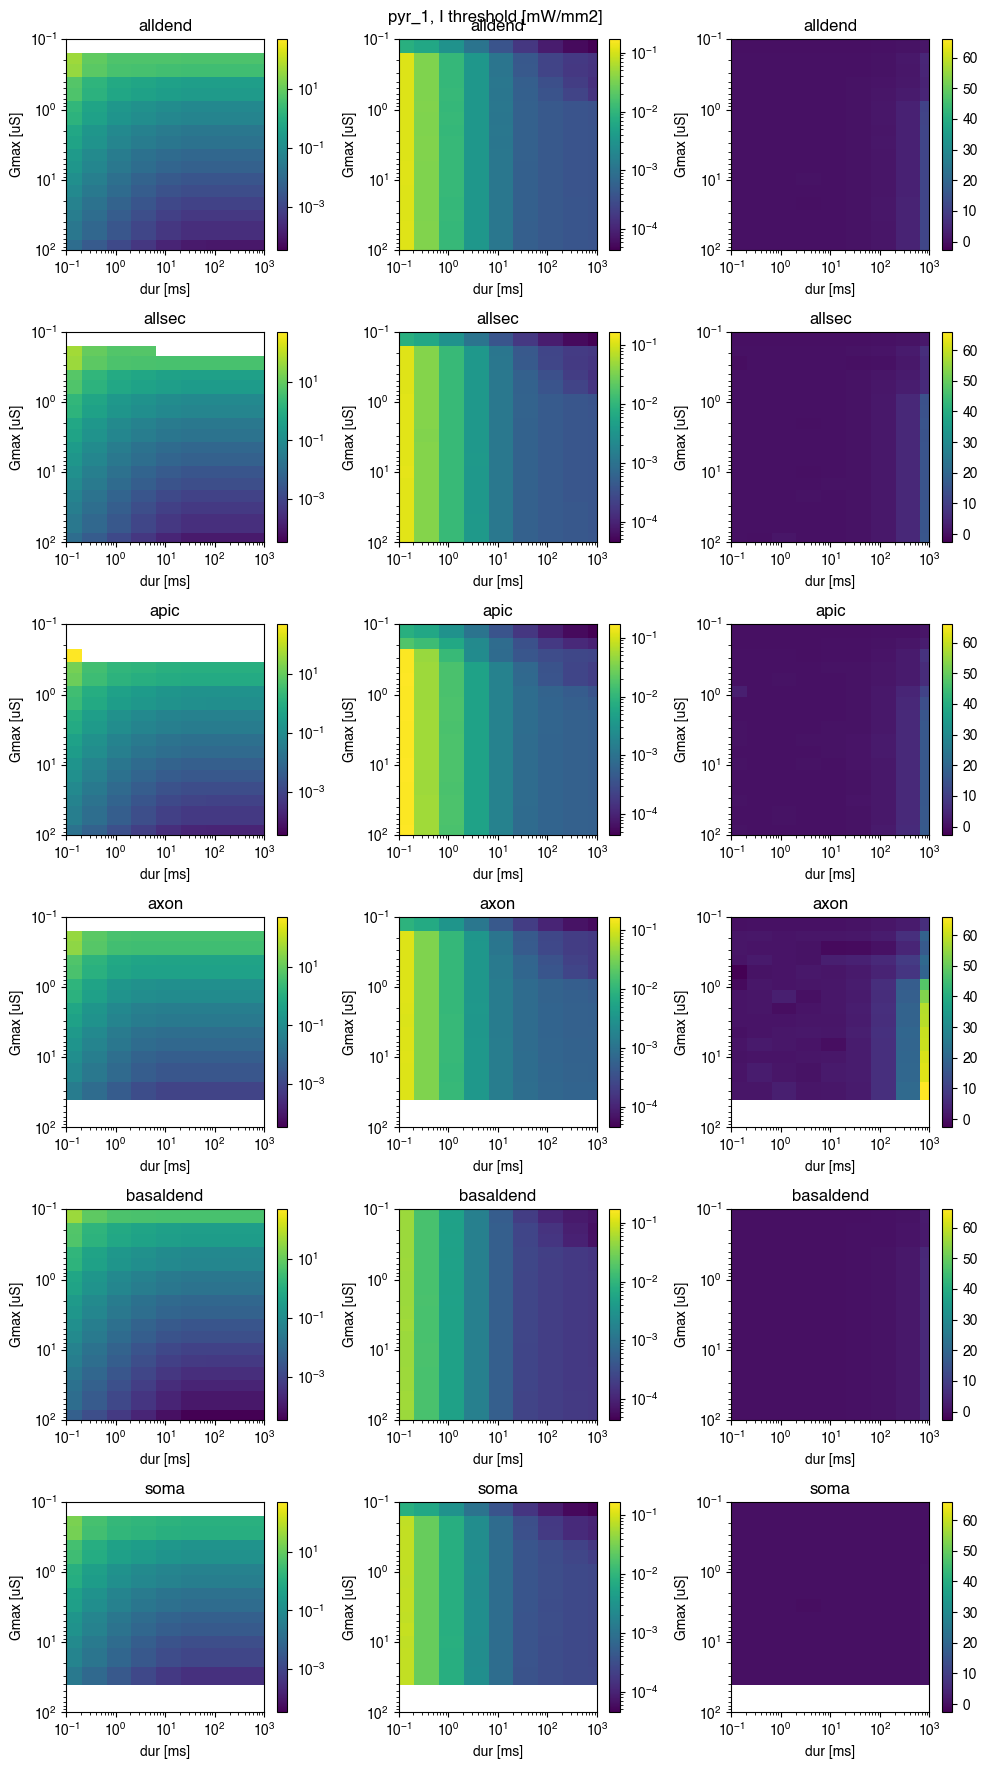

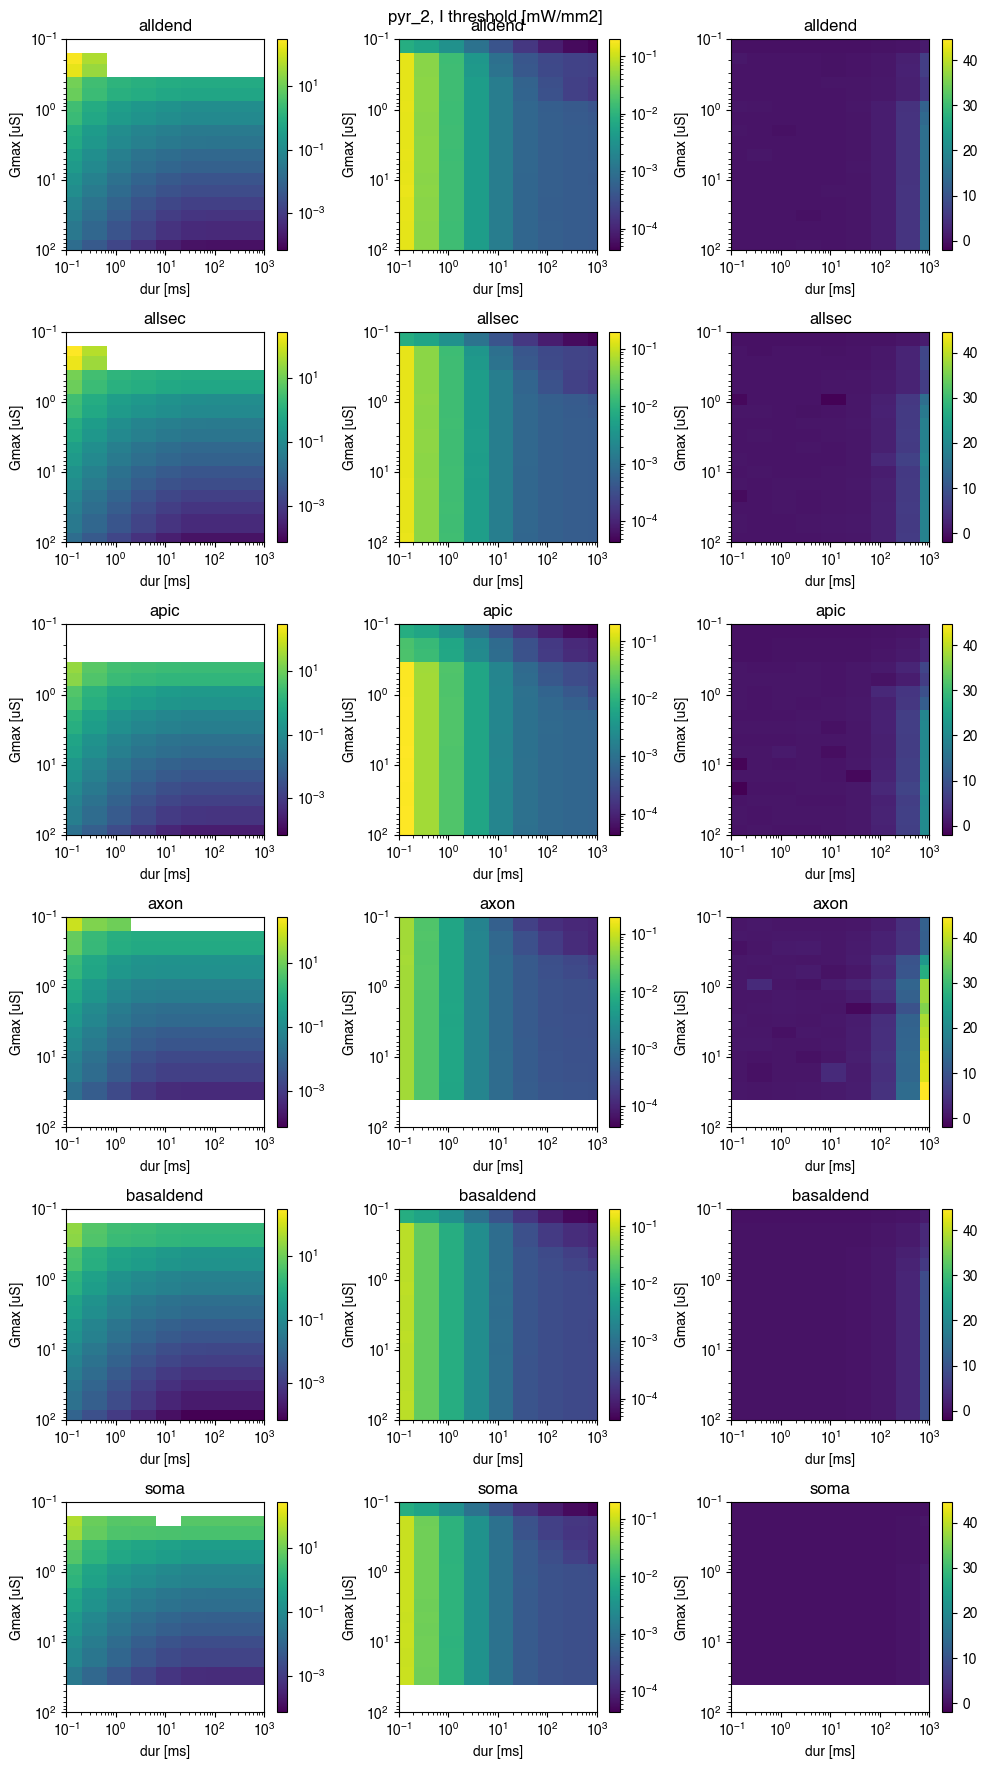

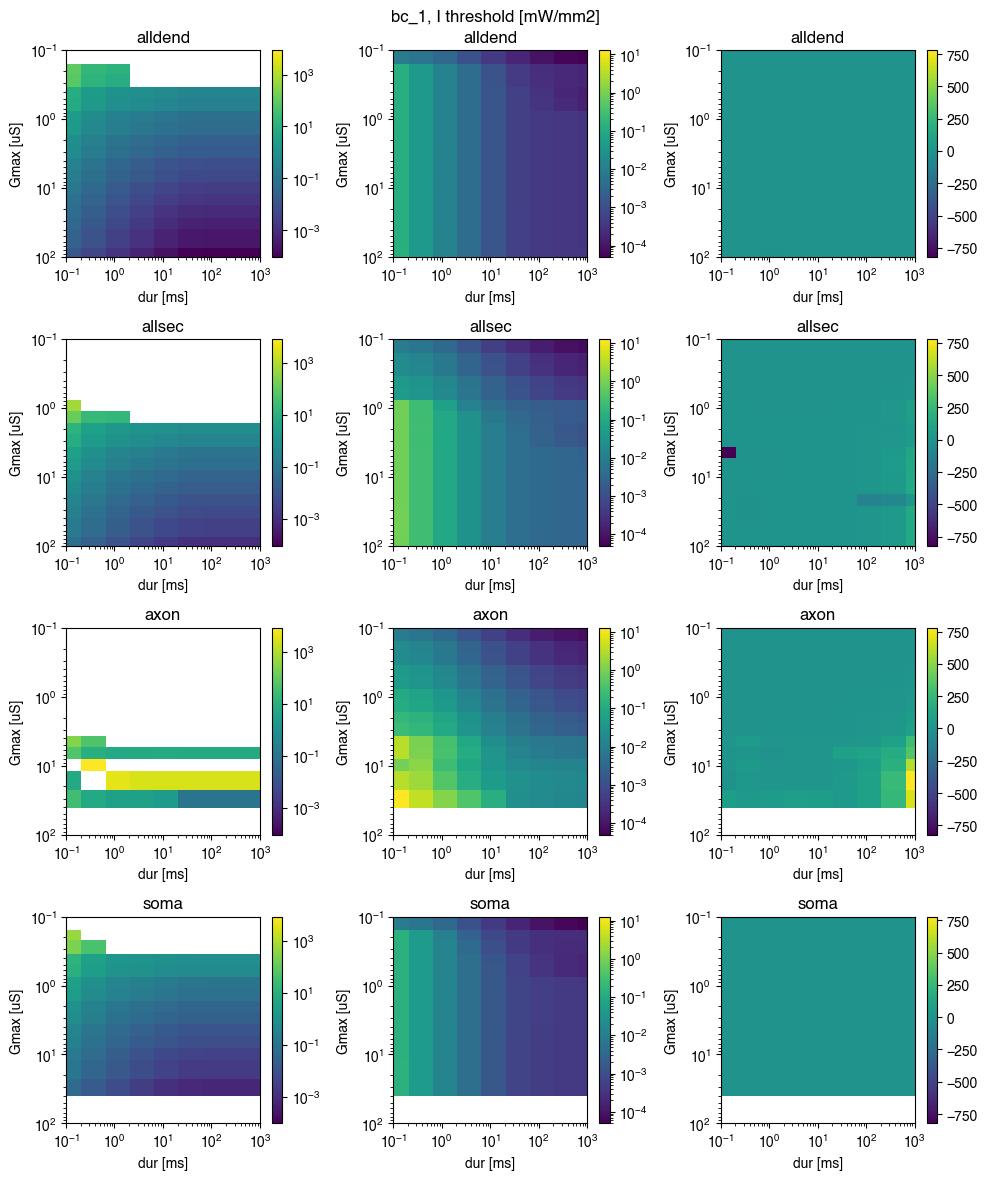

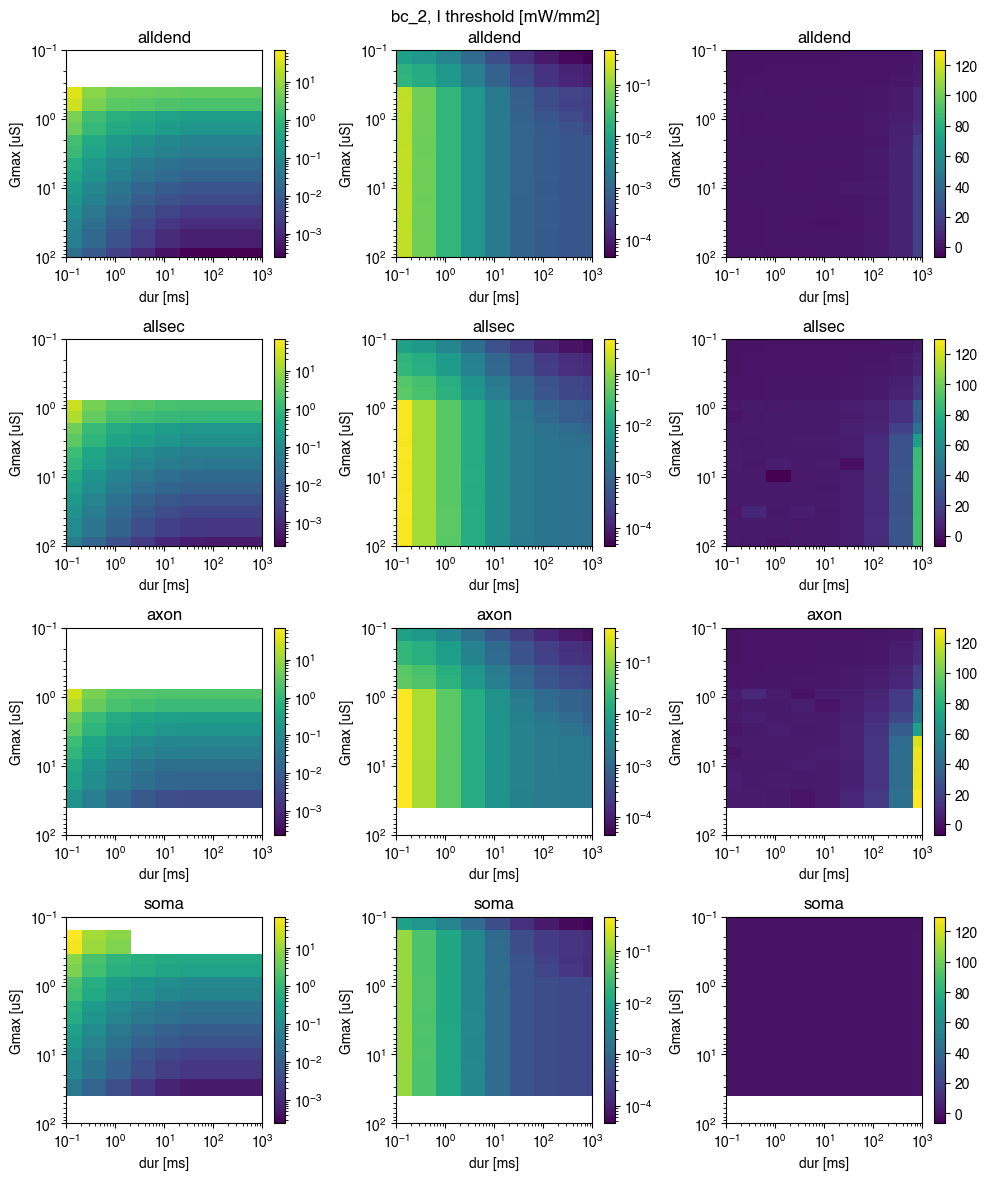

In [4]:
variables = ['opsinlocations', 'neurontemplate']
print({key: unique_values_columns_master[key] for key in variables})
levels = [0.1, 1, 10]
norm_log_cntr = mpl.cm.colors.LogNorm(vmax=levels[-1]*10, vmin=levels[0])
for neurontemplate in unique_values_columns_master['neurontemplate'][:]:
    fig_df = master_df[selection_generator(
        master_df, unique_values_columns=unique_values_columns_master, neurontemplate=neurontemplate)]
    uOpsinLocations = fig_df['opsinlocations'].unique()
    fig, axs = plt.subplots(len(uOpsinLocations), 3, tight_layout=True, figsize=(
        10, 3*len(uOpsinLocations)))
    for i, datalabel in enumerate(['amp', 'TAC', 'gchr2']):
        Imin = np.min(fig_df[datalabel])
        Imax = np.max(fig_df[datalabel])
        if Imin < 0:
            norm = mpl.cm.colors.Normalize(vmax=Imax, vmin=Imin)
        else:
            norm = mpl.cm.colors.LogNorm(vmax=Imax, vmin=Imin)
        for oL, ax in zip(uOpsinLocations, axs[:, i]):
            intm_df = fig_df[fig_df['opsinlocations'] == oL]
            udurs = np.unique(intm_df['dur'])
            uGmax = np.unique(intm_df['Gmax'])
            data_toplot = EcF.prepareDataforInterp(np.array(
                (intm_df['dur'], intm_df['Gmax'], intm_df[datalabel])).T, 'ninterp', sorted=False)
            yY, zZ = np.meshgrid(udurs, uGmax, indexing='ij')
            im, cb = EcF.slicePlot(data_toplot, ax, fig, plotGrid=(
                yY, zZ), structured=True, norm=norm)
            ax.set_xscale('log')
            ax.set_xlim((min(udurs), max(udurs)))
            ax.set_yscale('log')
            ax.set_ylim((1e-1, 1e2))
            ax.invert_yaxis()
            ax.set_xlabel('dur [ms]')
            ax.set_ylabel('Gmax [uS]')
            ax.set_title(f'{oL}')
    fig.suptitle(f'{neurontemplate}, I threshold [mW/mm2]')
    print()

## Strength duration curve plots
- rows different Gmax
- colors different opsin locations

Intensity: For long pulse durations seems to have converged to rheobase.\
TAC: at low Gmax no convergence, moroever curves of different opsin locations cross

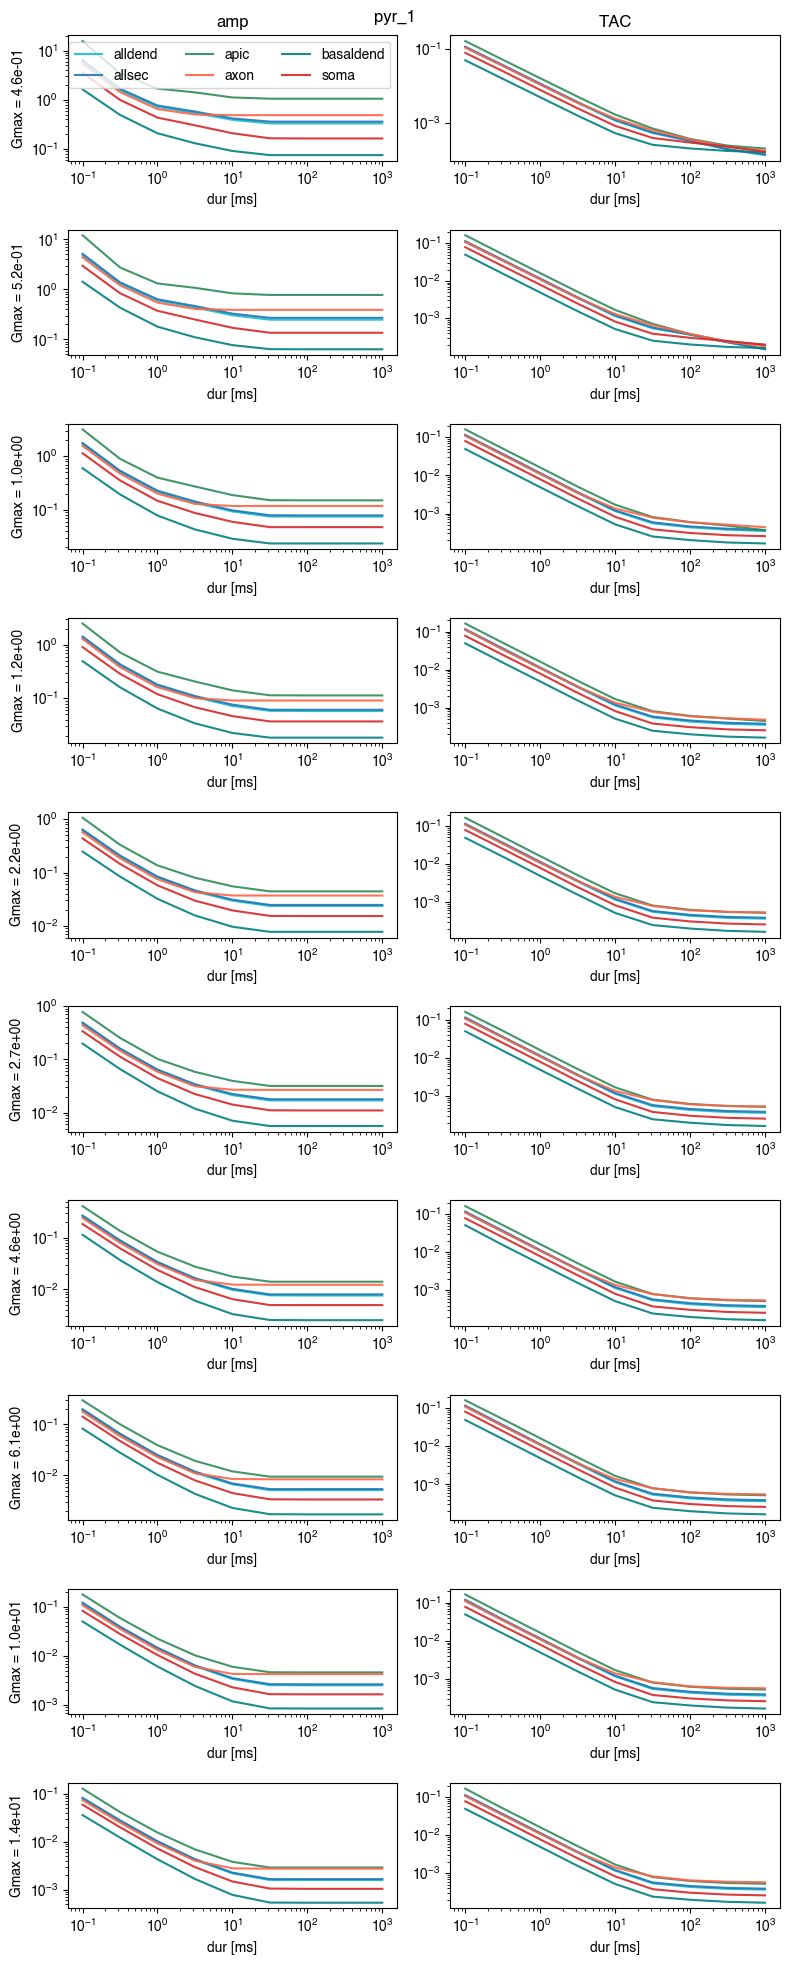

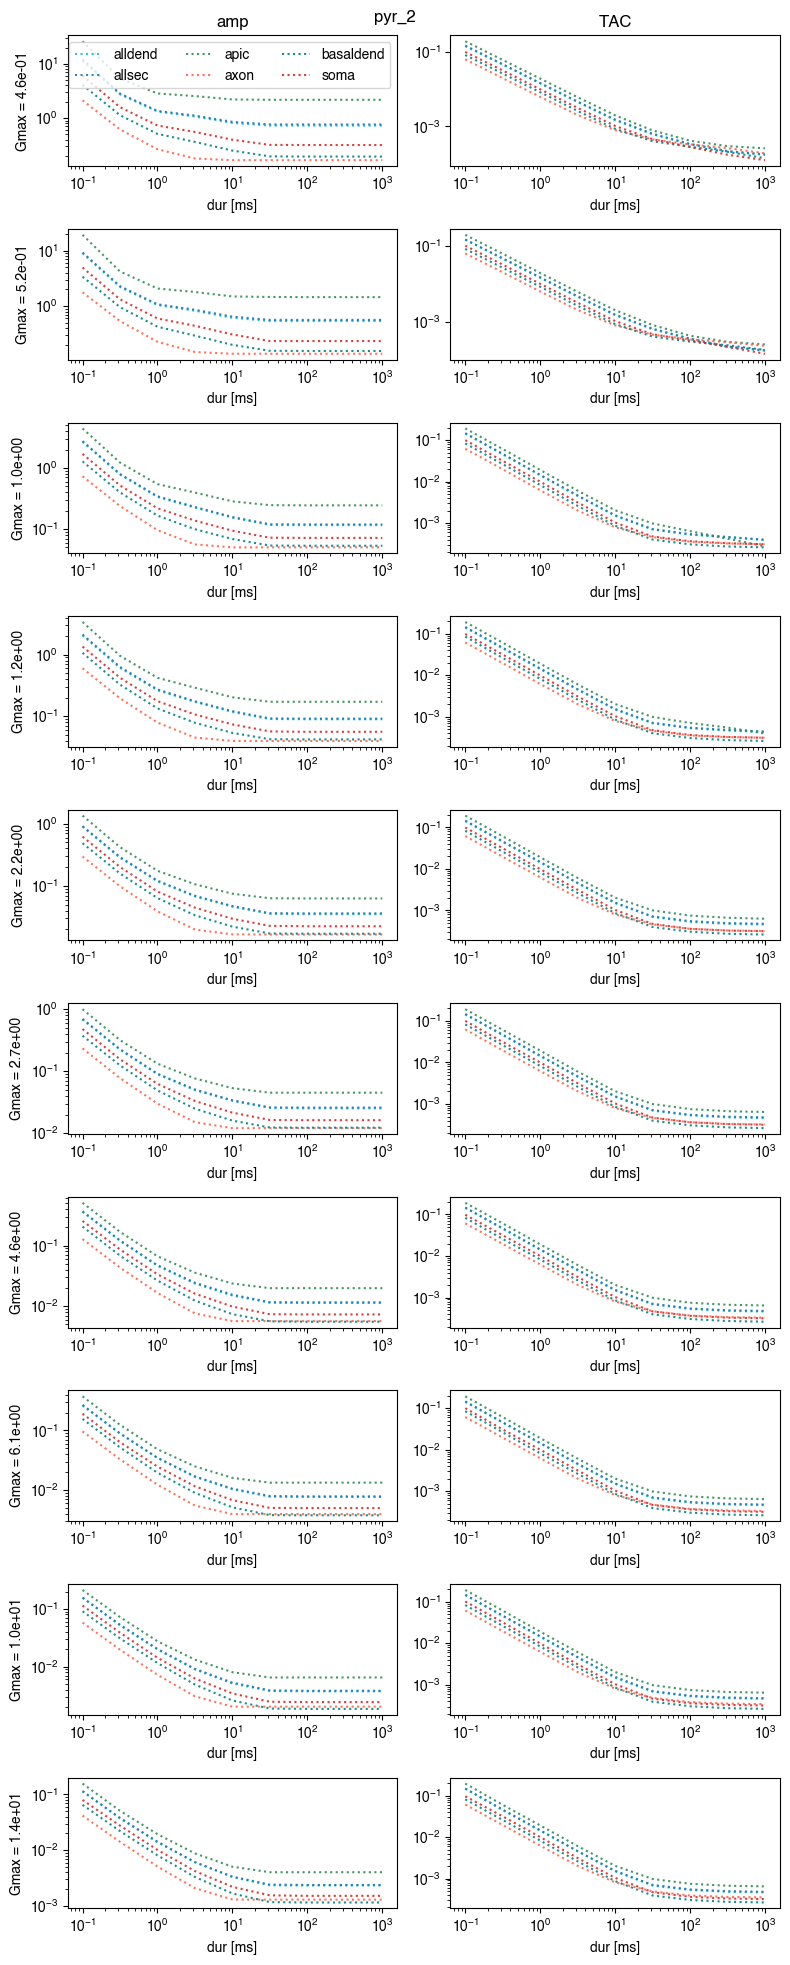

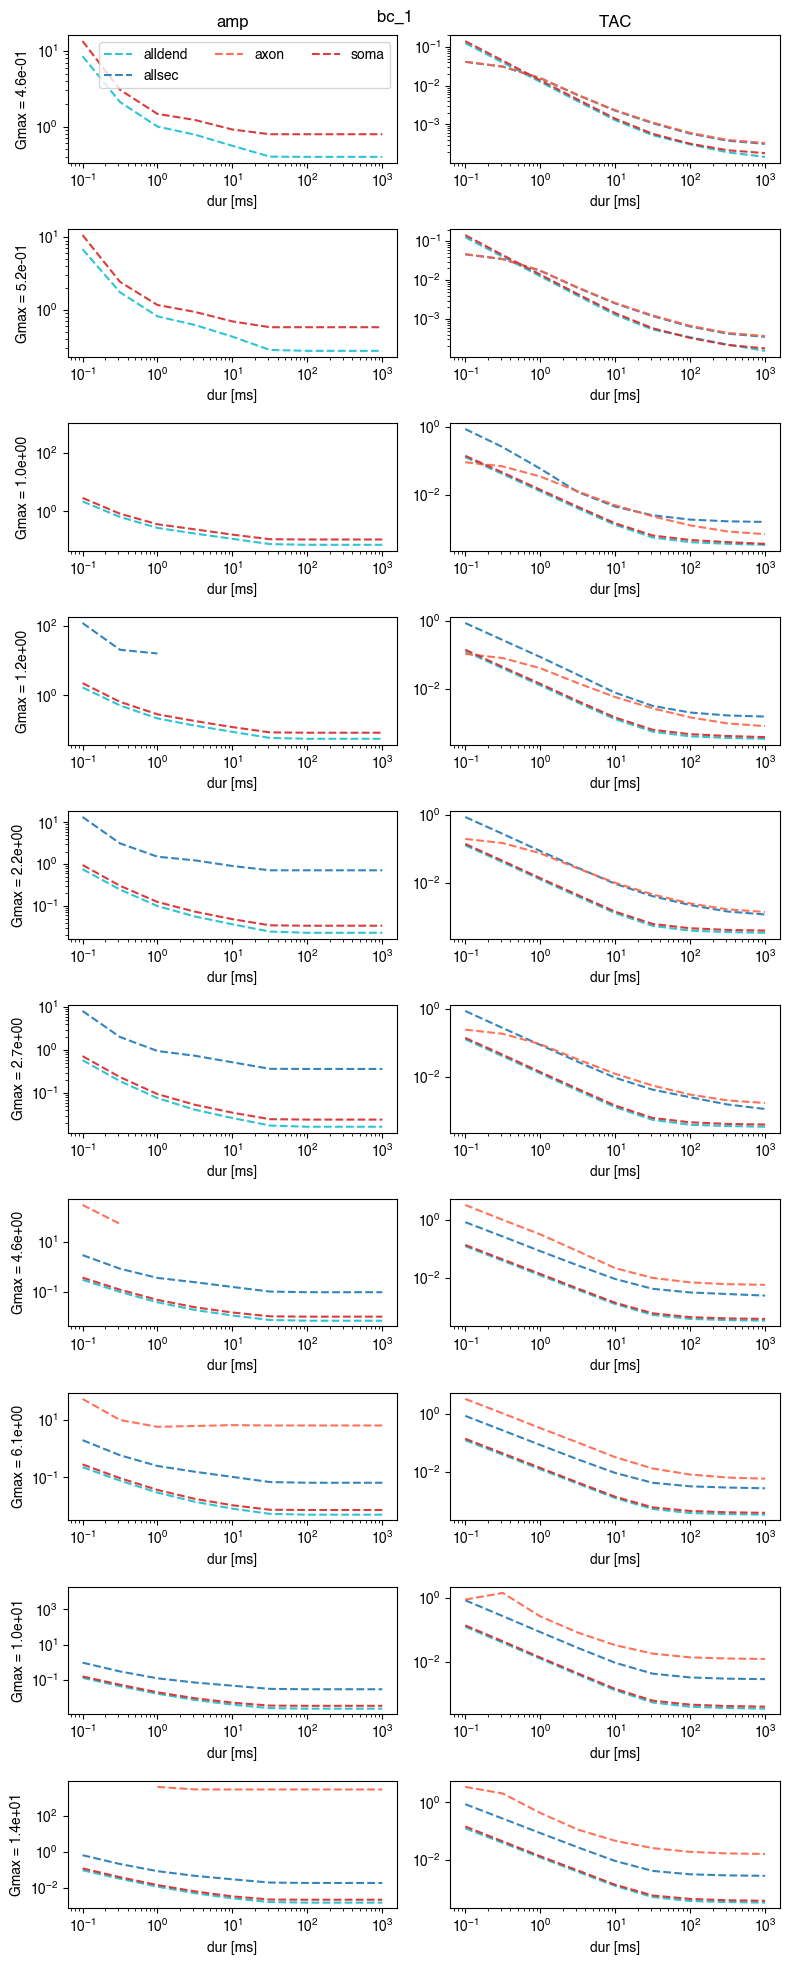

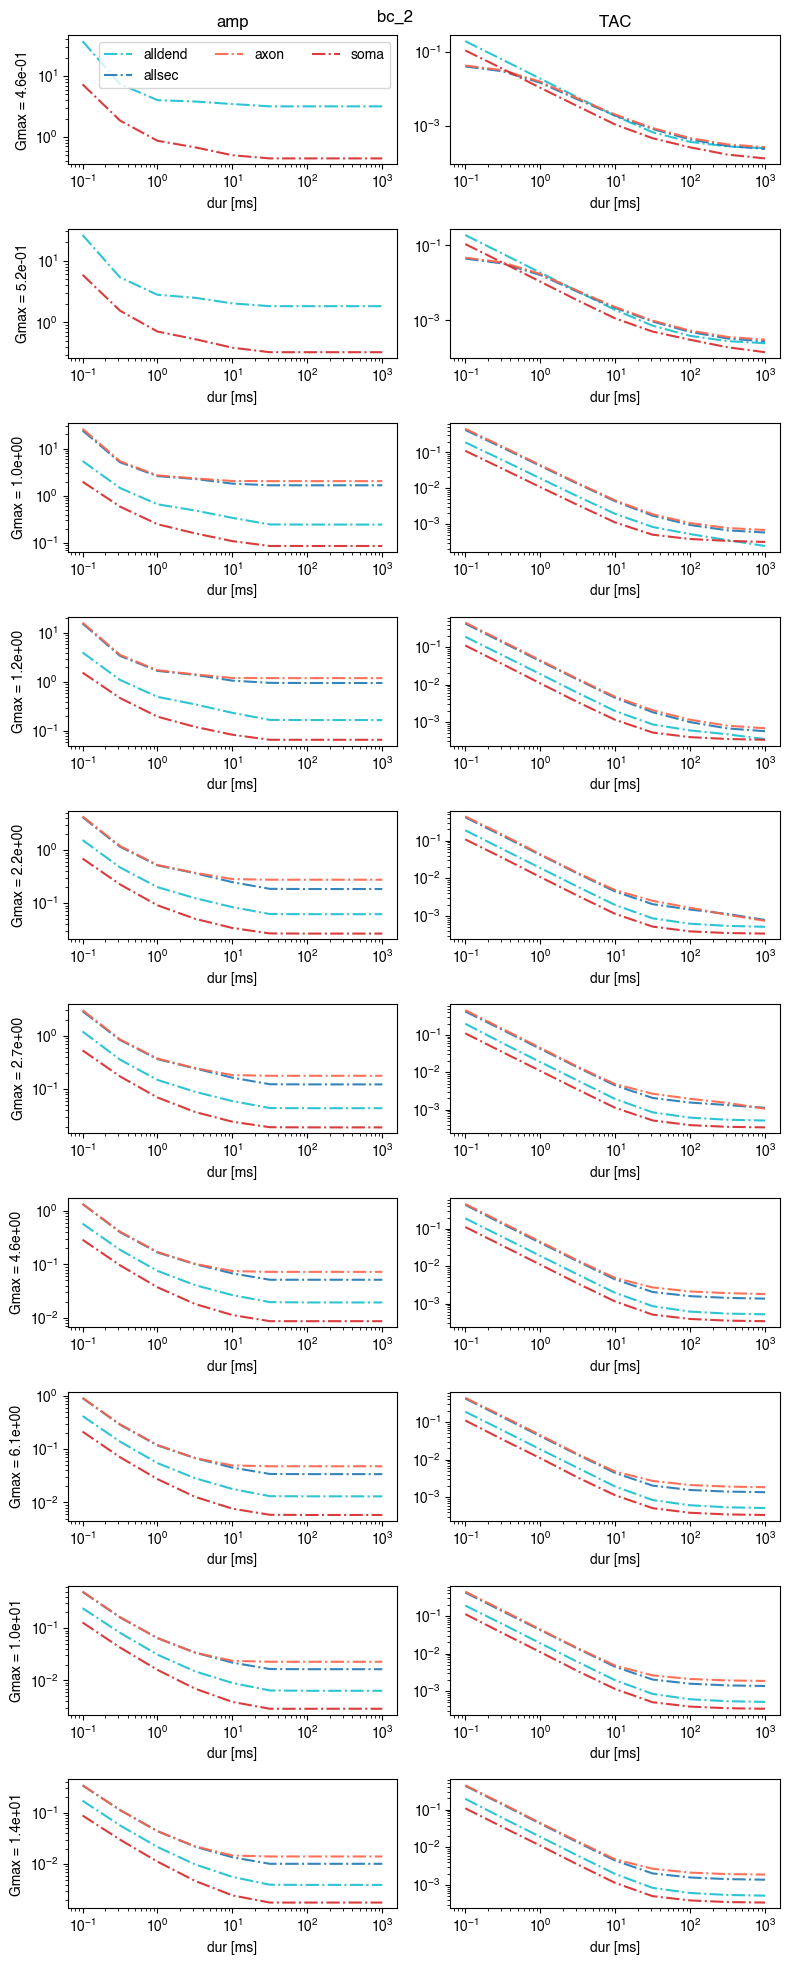

In [5]:

linestyle_str = ['solid', 'dotted', 'dashed', 'dashdot']
uGmax = np.sort(master_df['Gmax'].unique())[3:-4]


for neurontemplate, linestyle in zip(unique_values_columns_master['neurontemplate'][:], linestyle_str):
    fig, axs = plt.subplots(len(uGmax), 2, tight_layout=True,
                            figsize=(8, 2*len(uGmax)))
    fig_df = master_df[selection_generator(
        master_df, unique_values_columns=unique_values_columns_master, neurontemplate=neurontemplate)]
    uGmax = np.sort(fig_df['Gmax'].unique())[3:-4]
    for i, datalabel in enumerate(['amp', 'TAC']):
        for uG, ax in zip(uGmax, axs[:, i]):
            logscale = False
            intm_df = fig_df[fig_df['Gmax'] == uG]
            uOpsinLocations = [x for x in intm_df['opsinlocations'].unique()]
            for oL in uOpsinLocations:
                clr = colorkeyval[oL]
                plot_df = intm_df[intm_df['opsinlocations'] == oL]
                xdata = plot_df['dur']
                ydata = plot_df[datalabel]
                ax.plot(xdata, ydata, color=clr, alpha=0.9,
                        linestyle=linestyle, label=oL)
                if sum(~ np.isnan(ydata)) > 0:
                    logscale = True
            if logscale:
                ax.set_xscale('log')
                ax.set_yscale('log')
            ax.set_xlabel('dur [ms]')
            if i == 0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i == 0:
                    ax.legend(ncol=3)

    fig.suptitle(f'{neurontemplate}')
    print()

### ratio SDC wrt SDC of soma
Observation:\
- almost constant over duration / except TAC at high pulse durations
- basal dend best location, apical worst

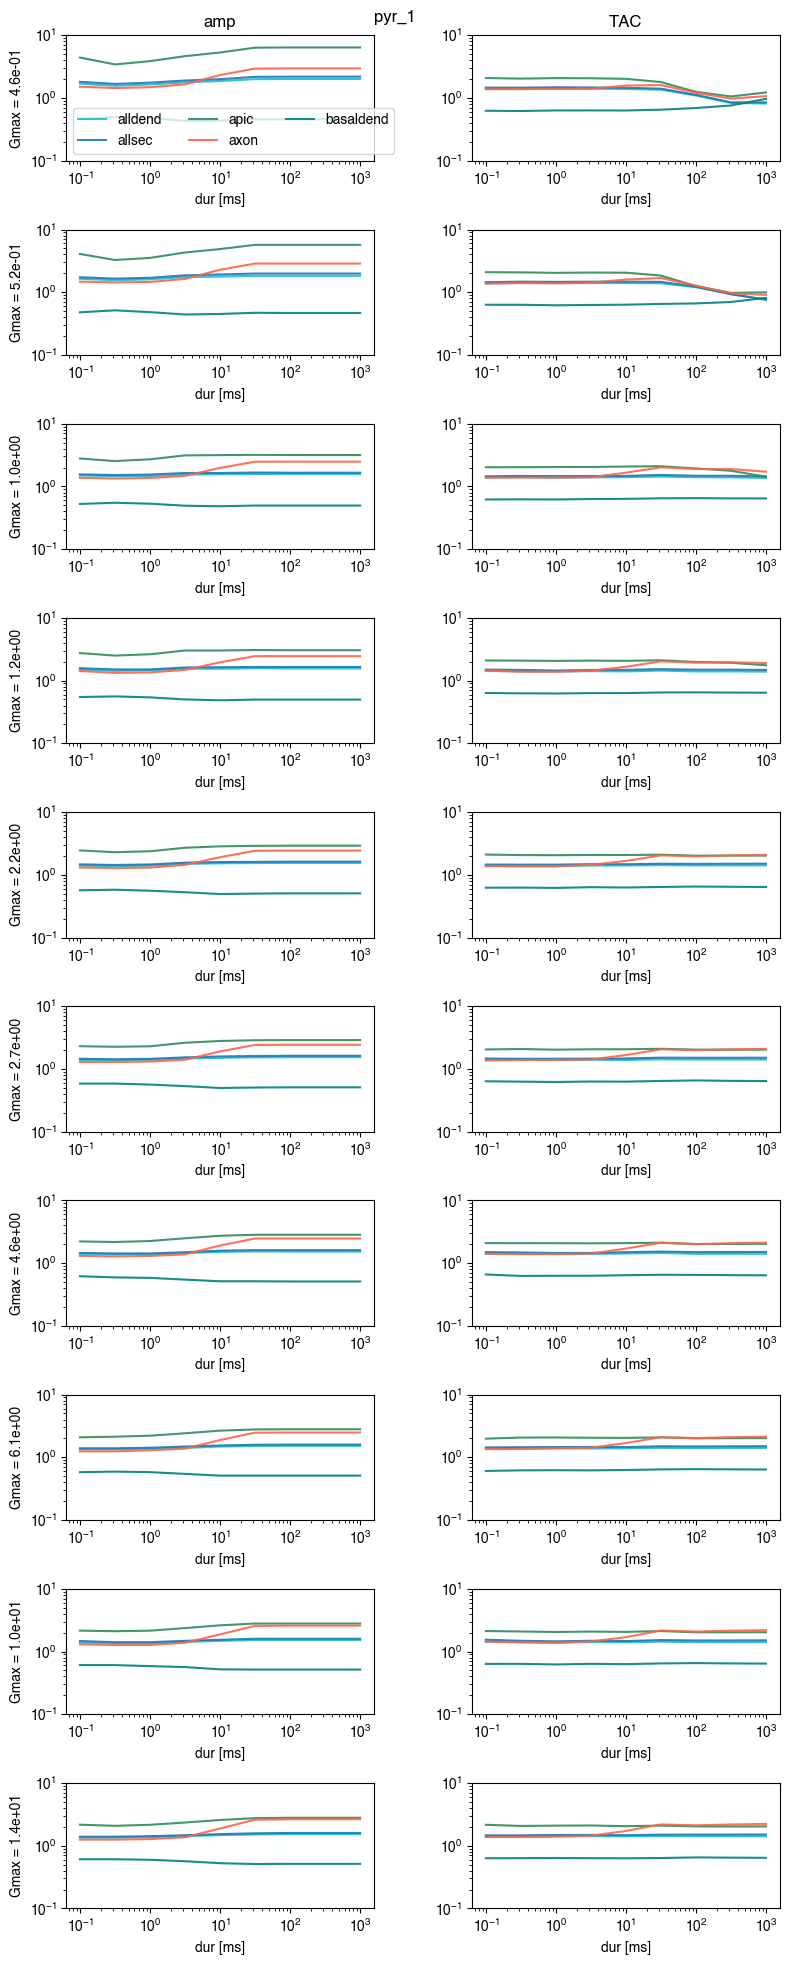

In [6]:
reference = 'soma'
uGmax = np.sort(master_df['Gmax'].unique())[3:-4]
fig, axs = plt.subplots(len(uGmax), 2, tight_layout=True,
                        figsize=(8, 2*len(uGmax)))
for neurontemplate, alpha in zip(unique_values_columns_master['neurontemplate'][:1], [0.9, 0.7]):
    linestyle = stylekeyval[neurontemplate]
    fig_df = master_df[selection_generator(
        master_df, unique_values_columns=unique_values_columns_master, neurontemplate=neurontemplate)]

    for i, datalabel in enumerate(['amp', 'TAC']):
        for uG, ax in zip(uGmax, axs[:, i]):
            logscale = False
            intm_df = fig_df[fig_df['Gmax'] == uG]
            uOpsinLocations = [
                x for x in intm_df['opsinlocations'].unique() if x != reference]
            for oL in uOpsinLocations:
                clr = colorkeyval[oL]
                plot_df = intm_df[intm_df['opsinlocations'] == oL]
                xdata = plot_df['dur']
                ydata = plot_df[datalabel]
                ref_ydata = intm_df[intm_df['opsinlocations']
                                    == reference][datalabel]
                if len(ydata) == len(ref_ydata):
                    ydata = np.array(ydata)/np.array(ref_ydata)
                    ax.plot(xdata, ydata, color=clr, alpha=alpha,
                            linestyle=linestyle, label=oL)
                    if sum(~ np.isnan(ydata)) > 0:
                        logscale = True
            if logscale:
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax.set_ylim([0.1, 10])
            ax.set_xlabel('dur [ms]')
            if i == 0:
                ax.set_ylabel(f'Gmax = {uG:0.1e}')
            if uG == uGmax[0]:
                ax.set_title(datalabel)
                if i == 0:
                    ax.legend(ncol=3)

    fig.suptitle(f'{neurontemplate}')
    print()

## Paperplots
### SDC and SGC

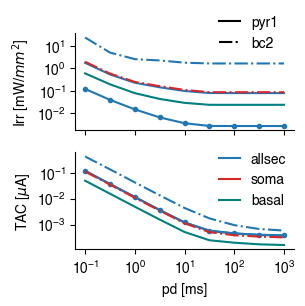

In [7]:

traces_toplot = [{'neurontemplate': 'pyr_1', 'Gmax': 1, 'opsinlocations': 'allsec'},
                 {'neurontemplate': 'pyr_1', 'Gmax': 10,
                     'opsinlocations': 'allsec'},
                 {'neurontemplate': 'pyr_1', 'Gmax': 1,
                     'opsinlocations': 'basaldend'},
                 {'neurontemplate': 'bc_2', 'Gmax': 1, 'opsinlocations': 'allsec'},
                 {'neurontemplate': 'bc_2', 'Gmax': 1, 'opsinlocations': 'soma'}]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(
    8/2.54, 8/2.54), tight_layout=True)

for feat, ax in zip(['amp', 'TAC'], axs):
    for trace_info in traces_toplot[:]:
        mydata = master_df[selection_generator(
            master_df, unique_values_columns=unique_values_columns_master, **trace_info)]
        xdata = mydata['dur']
        ydata = mydata[feat]
        ax.plot(xdata, ydata, color=colorkeyval[trace_info['opsinlocations']],
                linestyle=stylekeyval[trace_info['neurontemplate']], marker='' if trace_info['Gmax'] < 10 else '.')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Irr [mW/$mm^2$]' if feat == 'amp' else 'TAC [$\mu$A]')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax.set_xlabel('pd [ms]')
ax.set_xticks([0.1, 1, 10, 100, 1000])
axs[0].set_yticks([0.01, 0.1, 1, 10])

axs[0].plot(np.nan, np.nan, label='pyr1', color='k',
            linestyle=stylekeyval['pyr_1'], marker='')
axs[0].plot(np.nan, np.nan, label='bc2', color='k',
            linestyle=stylekeyval['bc_2'], marker='')
axs[1].plot(np.nan, np.nan, label='allsec', color=colorkeyval['allsec'],
            linestyle=stylekeyval['pyr_1'], marker='')
axs[1].plot(np.nan, np.nan, label='soma', color=colorkeyval['soma'],
            linestyle=stylekeyval['pyr_1'], marker='')
axs[1].plot(np.nan, np.nan, label='basal', color=colorkeyval['basaldend'],
            linestyle=stylekeyval['pyr_1'], marker='')
axs[0].legend(frameon=False, bbox_to_anchor=(0.6, 0.7), handlelength=1.5)
axs[1].legend(frameon=False, bbox_to_anchor=(0.6, 0.3), handlelength=1.5)
axs[1].minorticks_off()
fig.savefig('SDC.svg')

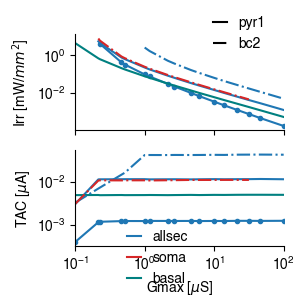

In [8]:
traces_toplot = [{'neurontemplate': 'pyr_1', 'dur': 1, 'opsinlocations': 'allsec'},
                 {'neurontemplate': 'pyr_1', 'dur': 10, 'opsinlocations': 'allsec'},
                 {'neurontemplate': 'pyr_1', 'dur': 1,
                     'opsinlocations': 'basaldend'},
                 {'neurontemplate': 'bc_2', 'dur': 1, 'opsinlocations': 'allsec'},
                 {'neurontemplate': 'bc_2', 'dur': 1, 'opsinlocations': 'soma'}]

fig, axs = plt.subplots(2, 1, sharex=True, figsize=(
    8/2.54, 8/2.54), tight_layout=True)

for feat, ax in zip(['amp', 'TAC'], axs):
    for trace_info in traces_toplot[:]:
        mydata = master_df[selection_generator(
            master_df, unique_values_columns=unique_values_columns_master, **trace_info)]
        xdata, ydata = sort_xy_based_x(mydata['Gmax'], mydata[feat])
        ax.plot(xdata, ydata, color=colorkeyval[trace_info['opsinlocations']],
                linestyle=stylekeyval[trace_info['neurontemplate']], marker='' if trace_info['dur'] < 10 else '.')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Irr [mW/$mm^2$]' if feat == 'amp' else 'TAC [$\mu$A]')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

ax.set_xlabel('Gmax [$\mu$S]')
ax.set_xticks(np.logspace(-2, 2, 5))
ax.set_xlim([0.1, 100])
axs[0].plot(np.nan, np.nan, label='pyr1', color='k',
            linestyle=stylekeyval['pyr_1'], marker='')
axs[0].plot(np.nan, np.nan, label='bc2', color='k',
            linestyle=stylekeyval['bc_2'], marker='')
axs[1].plot(np.nan, np.nan, label='allsec', color=colorkeyval['allsec'],
            linestyle=stylekeyval['pyr_1'], marker='')
axs[1].plot(np.nan, np.nan, label='soma', color=colorkeyval['soma'],
            linestyle=stylekeyval['pyr_1'], marker='')
axs[1].plot(np.nan, np.nan, label='basal', color=colorkeyval['basaldend'],
            linestyle=stylekeyval['pyr_1'], marker='')
axs[0].legend(frameon=False, bbox_to_anchor=(0.6, 0.7), handlelength=1)
axs[1].legend(frameon=False, bbox_to_anchor=(0.6, 0.3), handlelength=1)
axs[0].minorticks_off()
axs[1].minorticks_off()
fig.savefig('SGC.svg')

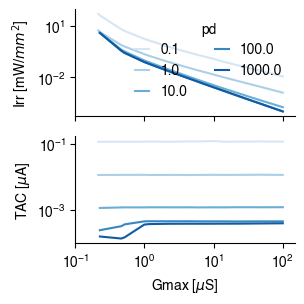

In [9]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(
    8/2.54, 8/2.54), tight_layout=True)
fig_df = master_df[selection_generator(master_df, unique_values_columns=unique_values_columns_master, **{
                                       'neurontemplate': 'pyr_1', 'opsinlocations': 'allsec'})].copy()
fig_df.loc[fig_df['amp'].isna(), 'TAC'] = np.nan
udurs = np.logspace(-1, 3, 5)
colors = np.array(sns.light_palette("tab:blue", n_colors=len(udurs)+1))
colors = np.array(sns.color_palette("Blues", n_colors=len(udurs)))
for feat, ax in zip(['amp', 'TAC'], axs):

    for dur, clr in zip(udurs, colors[:, :]):
        mydata = fig_df[selection_generator(
            fig_df, unique_values_columns=unique_values_columns_master, **{'dur': dur})]
        xdata, ydata = sort_xy_based_x(mydata['Gmax'], mydata[feat])
        ax.plot(xdata, ydata, color=clr, linestyle='-')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel('Irr [mW/$mm^2$]' if feat == 'amp' else 'TAC [$\mu$A]')

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
for dur, clr in zip(udurs, colors[:, :]):
    axs[0].plot(np.nan, np.nan, label=np.round(dur, 2), color=clr)

ax.set_xlabel('Gmax [$\mu$S]')
ax.set_xticks(np.logspace(-2, 2, 5))
ax.set_xlim([0.1, 150])
axs[0].legend(frameon=False, bbox_to_anchor=(1, 1),
              handlelength=1, loc='upper right', title='pd', ncol=2)
axs[0].minorticks_off()
axs[1].minorticks_off()
fig.savefig('SGC2.svg')

# STATISTICS
Pooled all simulations together\
Check if categories (neurontemplate, opsinlocations, Gmax and dur) give different results\


In [10]:
statistics_df = master_df[(master_df['Gmax'] >= 0.099)
                          & (master_df['Gmax'] < 32)]
features = ['amp', 'TAC']

### violin plots pooled data

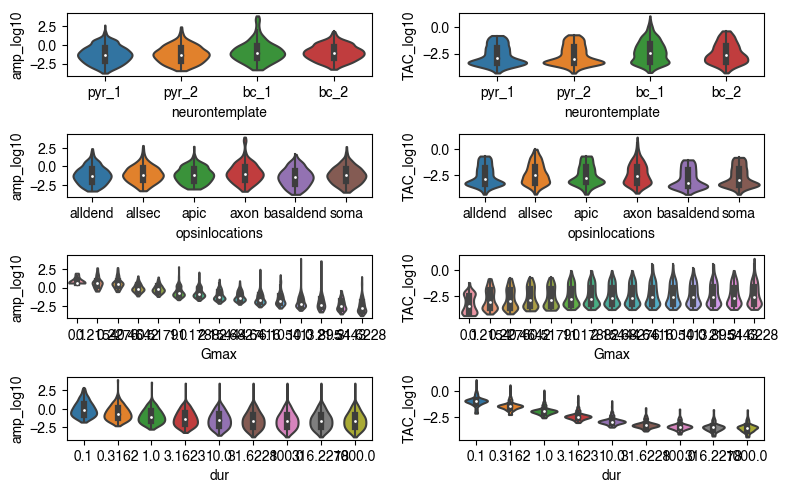

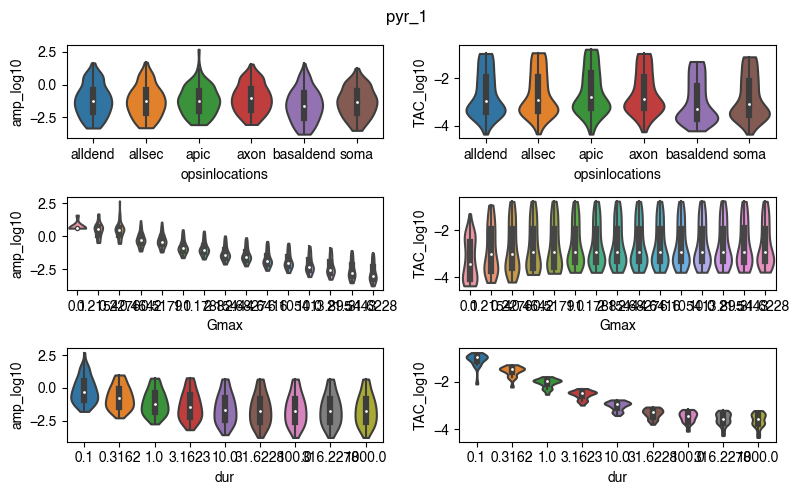

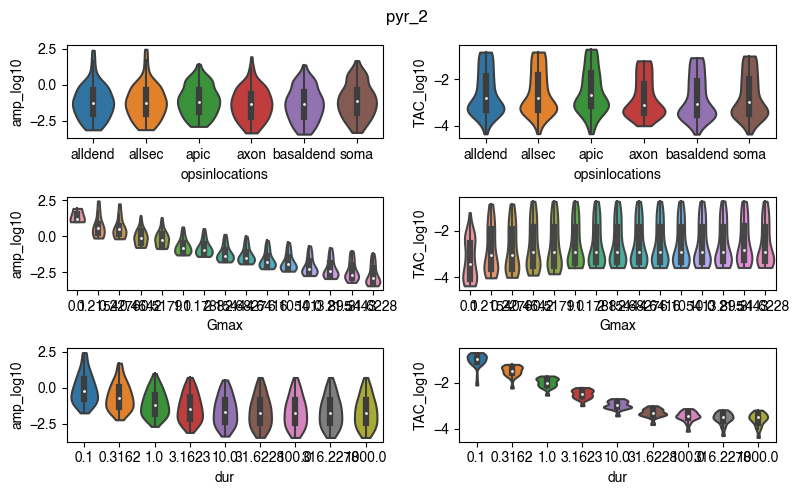

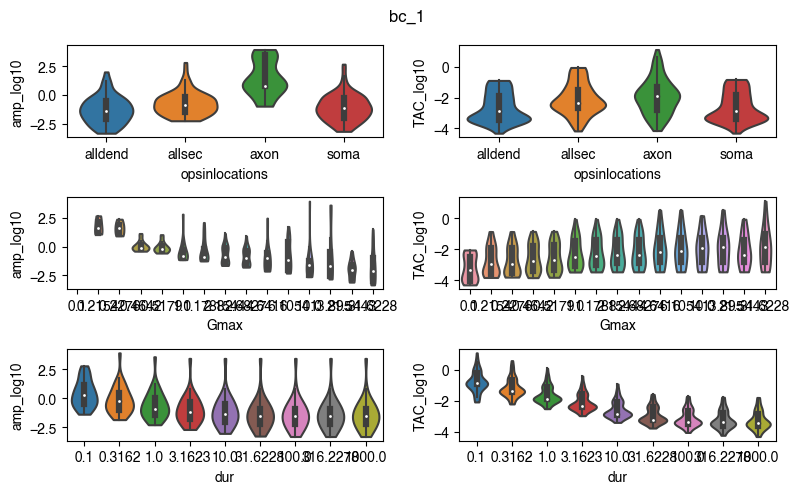

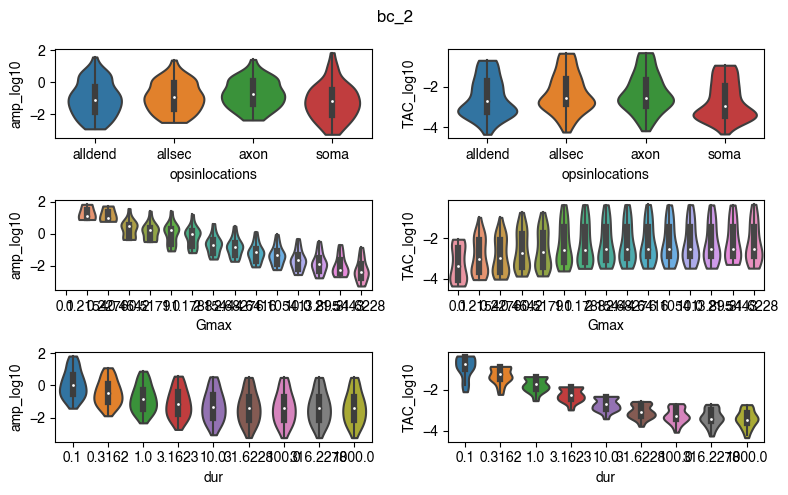

In [11]:
fig, axs = plt.subplots(4, 2, tight_layout=True, figsize=(8, 5))
for i, pool in enumerate(['neurontemplate', 'opsinlocations', 'Gmax', 'dur']):
    sns.violinplot(data=statistics_df, y='amp_log10',
                   x=pool, ax=axs[i, 0], cut=0)
    sns.violinplot(data=statistics_df, y='TAC_log10',
                   x=pool, ax=axs[i, 1], cut=0)
for nt in unique_values_columns_master['neurontemplate']:
    idx = statistics_df['neurontemplate'] == nt
    fig, axs = plt.subplots(3, 2, tight_layout=True, figsize=(8, 5))
    for i, pool in enumerate(['opsinlocations', 'Gmax', 'dur']):
        sns.violinplot(
            data=statistics_df[idx], y='amp_log10', x=pool, ax=axs[i, 0], cut=0)
        sns.violinplot(
            data=statistics_df[idx], y='TAC_log10', x=pool, ax=axs[i, 1], cut=0)
    fig.suptitle(nt)

### Kruskal-Wallis H-test

{'amp': {'all': {'neurontemplate': (25.210985905409192, 1.3948925810284587e-05), 'opsinlocations': (32.474653738603344, 4.7843761579278036e-06), 'Gmax': (1318.239318259559, 6.432616198738721e-273), 'dur': (433.3853068275898, 1.3396273262696287e-88)}}, 'TAC': {'all': {'neurontemplate': (56.72149358156639, 2.9468752844926296e-12), 'opsinlocations': (84.32979290453204, 1.0403147259696782e-16), 'Gmax': (159.10792766188933, 1.0724544095624637e-26), 'dur': (2162.2218354571723, 0.0)}}}


Text(0.5, 1.0, 'Kruskal Wallis')

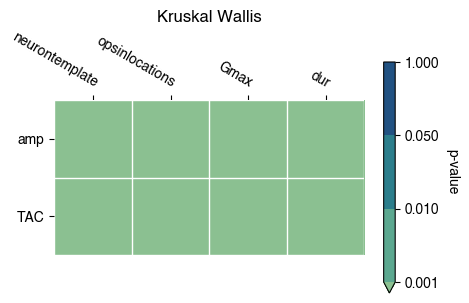

In [12]:
KW_dict = {}
classes = [x for x in all_settings_columns[::-1]
           if not ('_log10' in x or x == 'nPulse' or x == 'morphology')]
for feat in features:
    KW_dict[feat] = {'all': {}}
    for pool in classes:
        ukeys = statistics_df[pool].unique()
        pooledData = [
            list(statistics_df[feat][statistics_df[pool] == ukey]) for ukey in ukeys]
        KW_dict[feat]['all'][pool] = stats.kruskal(
            *pooledData, nan_policy='omit')[:]
print(KW_dict)

heatmapdata = np.zeros((len(features), len(classes)))
for ifeat, feat in enumerate(features):
    for ipool, pool in enumerate(classes):
        heatmapdata[ifeat, ipool] = KW_dict[feat]['all'][pool][1]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
heatmap(heatmapdata, features, classes, ax=ax,
        norm=boundnorm_pvalue, cmap=crestcmap_pvalue, cbarlabel='p-value')
ax.set_title('Kruskal Wallis')

### Mann Whitney U Test and Wilcoxon signed-rank test
WSRT: hypothesis that two related paired samples come from the same distribution. In particular, it tests whether the distribution of the differences x - y is symmetric about zero.

two sided Wilcoxon signed Rank test


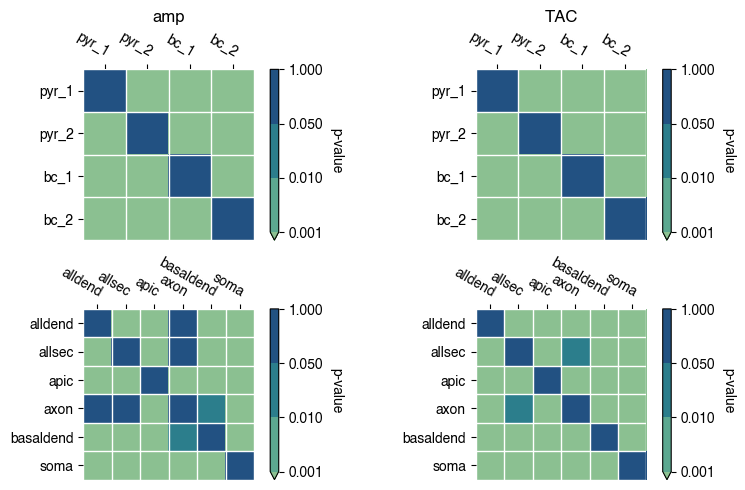

In [13]:
# Two sided MWU and WSRT

# collect test statistics
classes_toplot = ['neurontemplate', 'opsinlocations']
MWU_dict = {}
WSRT_dict = {}
for feat in features:
    MWU_dict[feat] = {'all': {}}
    WSRT_dict[feat] = {'all': {}}
    for pool in classes_toplot:
        ukeys = unique_values_columns_master[pool]
        mytest_MWU = np.ones((len(ukeys), len(ukeys), 2))
        mytest_WSRT = np.ones((len(ukeys), len(ukeys), 2))
        for i in range(len(ukeys)):
            for j in range(len(ukeys)):
                # MWU
                x = np.array(statistics_df[feat]
                             [statistics_df[pool] == ukeys[i]])
                x = x[~np.isnan(x)]
                y = np.array(statistics_df[feat]
                             [statistics_df[pool] == ukeys[j]])
                y = y[~np.isnan(y)]
                if len(y) > 0 and len(x) > 0:
                    mytest_MWU[i, j, 0] = stats.mannwhitneyu(x, y)[0]
                    mytest_MWU[i, j, 1] = stats.mannwhitneyu(x, y)[1]

                # WSRT
                df1 = statistics_df[statistics_df[pool] == ukeys[i]]
                df2 = statistics_df[statistics_df[pool] == ukeys[j]]
                df1 = df1.set_index(
                    [x for x in classes if not (pool in x or x in pool)])[feat]
                df2 = df2.set_index(
                    [x for x in classes if not (pool in x or x in pool)])[feat]
                diff_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=(
                    '_0', '_1'), validate='one_to_many')
                diff_df = diff_df[feat+'_1']-diff_df[feat+'_0']
                xydiff = np.array(diff_df)
                xydiff = xydiff[~np.isnan(xydiff)]
                if len(xydiff) > 0 and i != j:
                    mytest_WSRT[i, j, 0] = stats.wilcoxon(xydiff)[0]
                    mytest_WSRT[i, j, 1] = stats.wilcoxon(xydiff)[1]
        MWU_dict[feat]['all'][pool] = mytest_MWU
        WSRT_dict[feat]['all'][pool] = mytest_WSRT

# plot
print('two sided Wilcoxon signed Rank test')
fig, axs = plt.subplots(len(classes_toplot), 2,
                        tight_layout=True, figsize=(8, 5))
for pool, ax in zip(classes_toplot, axs):
    ukeys = unique_values_columns_master[pool]
    for ifeat, feat in enumerate(features):
        # im,_ = heatmap(MWU_dict[feat]['all'][pool][:,:,1], ukeys, ukeys, ax=ax[ifeat*2], norm=boundnorm,cmap=cmap,cbarlabel='p-value')
        im, _ = heatmap(WSRT_dict[feat]['all'][pool][:, :, 1], ukeys, ukeys,
                        ax=ax[ifeat], norm=boundnorm_pvalue, cmap=crestcmap_pvalue, cbarlabel='p-value')
        if pool == classes_toplot[0]:
            ax[ifeat].set_title(feat)

single sided Wilcoxon signed Rank test 
WSRT Ith all neurontemplate
[[1.00000000e+00 1.51122644e-44 1.22381096e-51 5.61385322e-65]
 [1.00000000e+00 1.00000000e+00 9.43450370e-14 5.61447483e-65]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 9.99999948e-01]
 [1.00000000e+00 1.00000000e+00 5.17650318e-08 1.00000000e+00]]


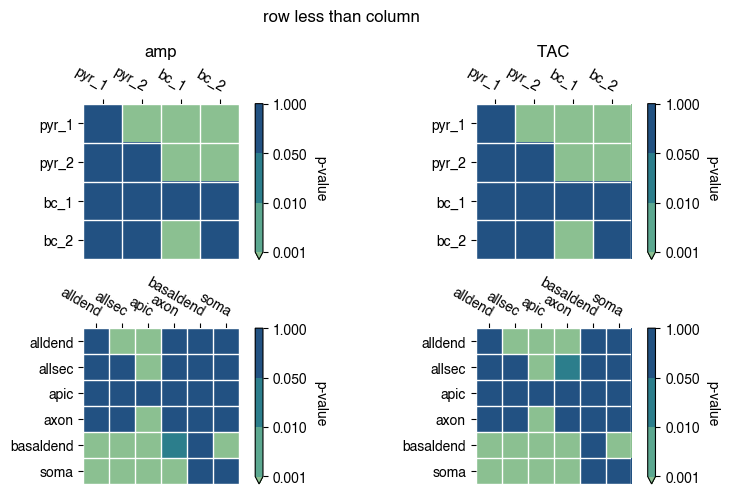

In [14]:
# single sided WSRT
classes_toplot = ['neurontemplate', 'opsinlocations']
MWU_dict = {}
WSRT_dict = {}

# collect data
for feat in features:
    WSRT_dict[feat] = {'all': {}}
    for pool in classes_toplot:
        ukeys = unique_values_columns_master[pool]
        mytest_WSRT = np.ones((len(ukeys), len(ukeys), 2))
        for i in range(len(ukeys)):
            for j in range(len(ukeys)):
                df1 = statistics_df[statistics_df[pool] == ukeys[i]]
                df2 = statistics_df[statistics_df[pool] == ukeys[j]]
                df1 = df1.set_index(
                    [x for x in classes if not (pool in x or x in pool)])[feat]
                df2 = df2.set_index(
                    [x for x in classes if not (pool in x or x in pool)])[feat]
                diff_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=(
                    '_0', '_1'), validate='one_to_many')
                diff_df = diff_df[feat+'_1']-diff_df[feat+'_0']
                xydiff = np.array(diff_df)
                xydiff = xydiff[~np.isnan(xydiff)]
                if len(xydiff) > 0 and i != j:
                    mytest_WSRT[i, j, 0] = stats.wilcoxon(
                        xydiff, alternative='greater')[0]
                    mytest_WSRT[i, j, 1] = stats.wilcoxon(
                        xydiff, alternative='greater')[1]
        WSRT_dict[feat]['all'][pool] = mytest_WSRT

# plot
print('single sided Wilcoxon signed Rank test ')
fig, axs = plt.subplots(len(classes_toplot), 2,
                        tight_layout=True, figsize=(8, 5))
for pool, ax in zip(classes_toplot, axs):
    ukeys = unique_values_columns_master[pool]
    for ifeat, feat in enumerate(features):
        # im,_ = heatmap(MWU_dict[feat]['all'][pool][:,:,1], ukeys, ukeys, ax=ax[ifeat*2], norm=boundnorm,cmap=cmap,cbarlabel='p-value')
        im, _ = heatmap(WSRT_dict[feat]['all'][pool][:, :, 1], ukeys, ukeys,
                        ax=ax[ifeat], norm=boundnorm_pvalue, cmap=crestcmap_pvalue, cbarlabel='p-value')
        if pool == classes_toplot[0]:
            ax[ifeat].set_title(feat)
fig.suptitle('row less than column')
print('WSRT Ith all neurontemplate')
print(WSRT_dict['amp']['all']['neurontemplate'][:, :, 1])

### WSRT opsinlocation for every cell seperatly

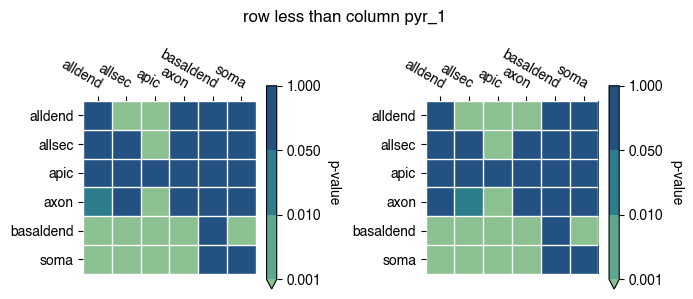

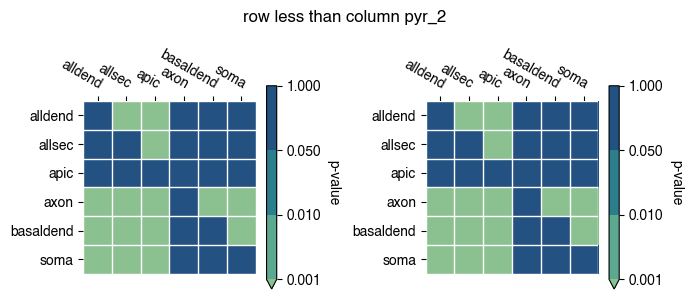

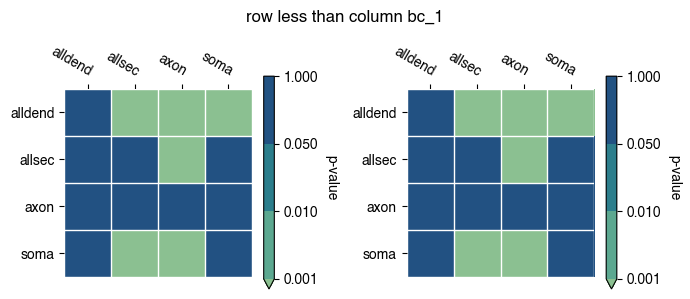

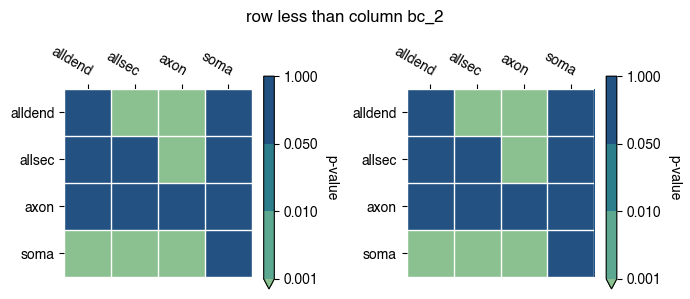

In [15]:

subclasses = ['opsinlocations']
for cell in unique_values_columns_master['neurontemplate'][:]:
    intm_df = statistics_df[statistics_df['neurontemplate'] == cell]
    for feat in features:
        WSRT_dict[feat][cell] = {}
        for pool in subclasses:
            if pool == 'opsinlocations':
                ukeys = intm_df[pool].unique()
            else:
                ukeys = unique_values_columns_master[pool]
            mytest_WSR = np.ones((len(ukeys), len(ukeys), 2))
            for i in range(len(ukeys)):
                for j in range(len(ukeys)):
                    # WSRT
                    df1 = intm_df[intm_df[pool] == ukeys[i]]
                    df2 = intm_df[intm_df[pool] == ukeys[j]]
                    df1 = df1.set_index(
                        [x for x in classes if not (pool in x or x in pool)])[feat]
                    df2 = df2.set_index(
                        [x for x in classes if not (pool in x or x in pool)])[feat]
                    diff_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=(
                        '_0', '_1'), validate='one_to_many')
                    diff_df = diff_df[feat+'_1']-diff_df[feat+'_0']
                    xydiff = np.array(diff_df)
                    xydiff = xydiff[~np.isnan(xydiff)]
                    if len(xydiff) > 0 and i != j:
                        mytest_WSR[i, j, 0] = stats.wilcoxon(
                            xydiff, alternative='greater')[0]
                        mytest_WSR[i, j, 1] = stats.wilcoxon(
                            xydiff, alternative='greater')[1]

            WSRT_dict[feat][cell][pool] = mytest_WSR

    fig, axs = plt.subplots(
        len(subclasses), 2, tight_layout=True, figsize=(7, 3))
    if len(subclasses) == 1:
        axs = [axs]
    for pool, ax in zip(subclasses, axs):
        if pool == 'opsinlocations':
            ukeys = intm_df[pool].unique()
        else:
            ukeys = unique_values_columns_master[pool]
        for ifeat, feat in enumerate(features):
            im, _ = heatmap(WSRT_dict[feat][cell][pool][:, :, 1], ukeys, ukeys,
                            ax=ax[ifeat], norm=boundnorm_pvalue, cmap=crestcmap_pvalue, cbarlabel='p-value')
            if pool == classes[0]:
                ax[ifeat].set_title(feat)
    fig.suptitle(f'row less than column {cell}')

## Paper plots

### Wilcoxon signed rank test for all opsin neuron template locations
This identifies most excitable combination

population names
['pyr_1alldend' 'pyr_1allsec' 'pyr_1apic' 'pyr_1axon' 'pyr_1basaldend'
 'pyr_1soma' 'pyr_2alldend' 'pyr_2allsec' 'pyr_2apic' 'pyr_2axon'
 'pyr_2basaldend' 'pyr_2soma' 'bc_1alldend' 'bc_1allsec' 'bc_1axon'
 'bc_1soma' 'bc_2alldend' 'bc_2allsec' 'bc_2axon' 'bc_2soma']

 amp:
	med xydiff: -0.13948296763655196 
	mean xydiff: -0.1793886703825894

median incremental rel change amp [%]:
med	 -10.826287190233677 
mean	 -22.76191388583213

mean incremental rel change amp [%]:
med	 -13.974936560306043 
mean	 -21.30833633776406

min incremental rel change amp [%]:
med	 -51.3530293090246 
mean	 -49.4553995331097

max incremental rel change amp [%]:
med	 -4.73684210526315 
mean	 0.6016982965864426

median incremental rel change TAC [%]:
med	 -10.826287190233677 
mean	 -22.76191388583213

mean incremental rel change TAC [%]:
med	 -13.974936560306043 
mean	 -21.30833633776406

min incremental rel change TAC [%]:
med	 -51.3530293090246 
mean	 -49.4553995331097

max incremental rel cha

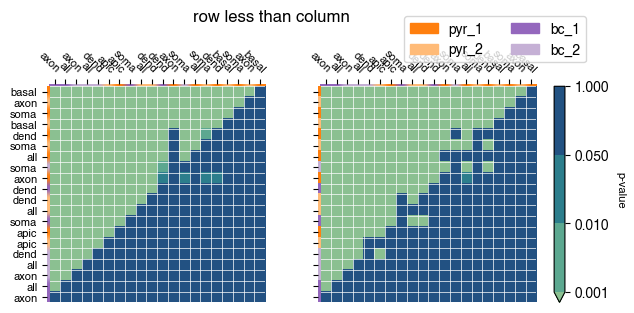

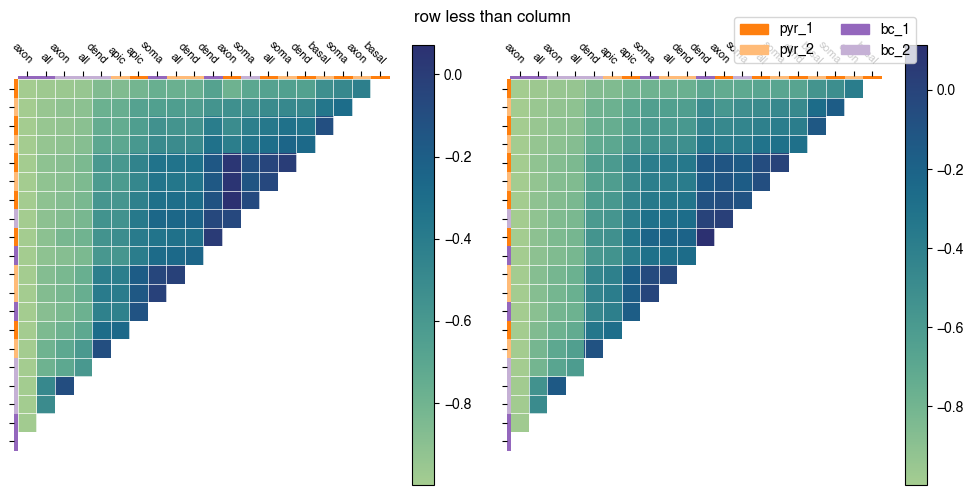

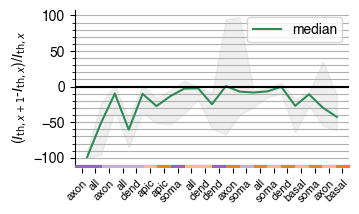

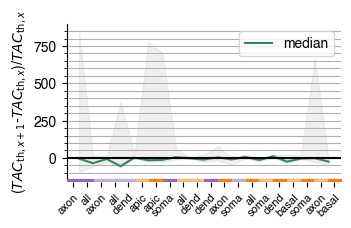

In [16]:
classes = ['neurontemplate', 'opsinlocations', 'Gmax', 'dur']
# wsrt_df = statistics_df[features+classes].copy()
wsrt_df = master_df[features+classes].copy()
wsrt_df['wsrt_keys'] = wsrt_df.apply(
    lambda x: f"{x['neurontemplate']}{x['opsinlocations']}", axis=1)
print('population names')
print(wsrt_df['wsrt_keys'].unique())

cvrt_label = {'allsec': 'all', 'alldend': 'dend', 'soma': 'soma',
              'axon': 'axon', 'basaldend': 'basal', 'apic': 'apic'}

# WSRT on wsrt_keys
WSRT_dict = {}
ukeys = wsrt_df['wsrt_keys'].unique()
for feat in features:
    WSRT_dict[feat] = {}
    mytest_WSRT = np.ones((len(ukeys), len(ukeys), 2))
    for i in range(len(ukeys)):
        for j in range(len(ukeys)):
            df1 = wsrt_df[wsrt_df['wsrt_keys'] == ukeys[i]]
            df2 = wsrt_df[wsrt_df['wsrt_keys'] == ukeys[j]]
            df1 = df1.set_index([x for x in ['Gmax', 'dur']])[feat]
            df2 = df2.set_index([x for x in ['Gmax', 'dur']])[feat]
            diff_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=(
                '_0', '_1'), validate='one_to_many')
            diff_df = diff_df[feat+'_1']-diff_df[feat+'_0']
            xydiff = np.array(diff_df)
            xydiff = xydiff[~(np.isnan(xydiff) | np.isinf(xydiff))]
            if len(xydiff) > 0 and i != j:
                wstats = stats.wilcoxon(xydiff, alternative='greater')
                mytest_WSRT[i, j, 0] = wstats[0]
                mytest_WSRT[i, j, 1] = wstats[1]
    WSRT_dict[feat] = mytest_WSRT


# heatmap with pvalues wsrt
row_colors_dict = {x: colorkeyval[x]
                   for x in wsrt_df['neurontemplate'].unique()}

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(19/2.54, 8/2.54))
for ifeat, (feat, ax) in enumerate(zip(features, axs)):
    greatest = np.sum(WSRT_dict[feat][:, :, 1] < 0.001, axis=1)+0.5*np.sum((WSRT_dict[feat][:, :, 1] < 0.01) & (WSRT_dict[feat][:, :, 1] >= 0.001), axis=1)\
        + 0.1*np.sum((WSRT_dict[feat][:, :, 1] < 0.05)
                     & (WSRT_dict[feat][:, :, 1] >= 0.01), axis=1)
    if ifeat == 0:
        idx_column = np.argsort(greatest)
        idx_row = np.flip(idx_column)
    row_labels = ukeys[idx_row]
    column_labels = ukeys[idx_column]
    row_colors = np.array([i for x in row_labels for k,
                          i in row_colors_dict.items() if k in x])[:, None, :]
    column_colors = np.array(
        [i for x in column_labels for k, i in row_colors_dict.items() if k in x])[None, :, :]
    row_labels = [x.rsplit('_', 1)[1][1:] for x in row_labels]
    column_labels = [x.rsplit('_', 1)[1][1:] for x in column_labels]
    row_labels = [cvrt_label[x] for x in row_labels]
    if ifeat == 1:
        row_labels = ['' for x in row_labels]
    column_labels = [cvrt_label[x] for x in column_labels]

    data_toplot = WSRT_dict[feat][:, idx_column, 1]
    im, cbar = heatmap_colorcode(data_toplot[idx_row, :], row_labels, column_labels, ax=ax, row_colors=row_colors,
                                 column_colors=column_colors, norm=boundnorm_pvalue, cmap=crestcmap_pvalue, cbarlabel='p-value', labelfs=8, lw_grid=0.5)
    if feat == classes[0]:
        ax[ifeat].set_title(feat)
    if ifeat == 0:
        cbar.remove()
fig.suptitle(f'row less than column')
legendpatches = []
for k, v in row_colors_dict.items():
    legendpatches.append(mpl.patches.Patch(color=v, label=k))
fig.legend(handles=legendpatches, bbox_to_anchor=(0.93, 0.98), ncol=2)
fig.savefig('wsrt_fixedI.svg')


# quantative plot ordered based on WSRT
# collect data
ukeys_row = ukeys[idx_row]
ukeys_column = ukeys[idx_column]
xydiff_collector = {}
quantChange_dict = {}
for feat in features:
    quantChange_dict[feat] = {}
    xydiff_collector[feat] = []
    mytest_qC = np.full((len(ukeys), len(ukeys), 4), np.nan)
    for i, r in enumerate(ukeys_row):
        for j, c in enumerate(ukeys_column):
            if j < (len(ukeys_row)-i):
                df1 = wsrt_df[wsrt_df['wsrt_keys'] == r]
                df2 = wsrt_df[wsrt_df['wsrt_keys'] == c]
                df1 = df1.set_index([x for x in ['Gmax', 'dur']])[feat]
                df2 = df2.set_index([x for x in ['Gmax', 'dur']])[feat]
                diff_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=(
                    '_0', '_1'), validate='one_to_many')
                diff_df = (diff_df[feat+'_0']-diff_df[feat+'_1']
                           )/diff_df[feat+'_1']
                xydiff = np.array(diff_df)
                xydiff = xydiff[~(np.isnan(xydiff) | np.isinf(xydiff))]
                if len(xydiff) > 0 and r != c:
                    mytest_qC[i, j, 0] = np.median(xydiff)
                    mytest_qC[i, j, 1] = np.mean(xydiff)
                    mytest_qC[i, j, 2] = np.min(xydiff)
                    mytest_qC[i, j, 3] = np.max(xydiff)
                    if (j == (len(ukeys_row)-2-i)):
                        xydiff_collector[feat] = np.append(
                            xydiff_collector[feat], xydiff)
    quantChange_dict[feat] = mytest_qC

# plot
cmap = sns.color_palette("crest", as_cmap=True)
print('\n amp:\n\tmed xydiff:', np.nanmedian(
    xydiff_collector['amp']), '\n\tmean xydiff:', np.nanmean(xydiff_collector['amp']))
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
for ifeat, (feat, ax) in enumerate(zip(range(2), axs)):

    data_toplot = quantChange_dict['amp'][:, :, feat]
    im, cbar = heatmap_colorcode(data_toplot, row_labels, column_labels, ax=ax, row_colors=row_colors,
                                 column_colors=column_colors, cmap=cmap, cbarlabel='', labelfs=8, lw_grid=0.5)


fig.suptitle(f'row less than column')
legendpatches = []
for k, v in row_colors_dict.items():
    legendpatches.append(mpl.patches.Patch(color=v, label=k))
fig.legend(handles=legendpatches, bbox_to_anchor=(0.93, 0.98), ncol=2)


# line plot of incremental change Ithreshold
labels = ['median', 'mean']
clrs = ['seagreen', 'tab:blue']
for feat in features:
    fig, ax = plt.subplots(1, 1, figsize=(9/2.54, 5.1/2.54))
    for i, (l, clr) in enumerate(zip(labels[:1], clrs)):
        data_toplot = quantChange_dict[feat][:, :, i]
        y = np.fliplr(data_toplot).diagonal(offset=1)
        y = np.flip(np.append([np.nan], y))
        ax.plot(np.arange(len(ukeys_row)), 100*y, label=l, color=clr)

    data_toplot = quantChange_dict[feat][:, :, 3]
    y = np.fliplr(data_toplot).diagonal(offset=1)
    mymax = np.flip(np.append([np.nan], 100*y))
    data_toplot = quantChange_dict[feat][:, :, 2]
    y = np.fliplr(data_toplot).diagonal(offset=1)
    mymin = np.flip(np.append([np.nan], 100*y))
    ax.fill_between(np.arange(len(ukeys_row)), mymin,
                    mymax, alpha=0.3, color=[0.8, 0.8, 0.8])
    ax.axhline(0, color='k')

    # annotate plot and add colorcode x-axis (see heatmap_colorcode)
    # colored x-axis
    ax_column_cols = ax.inset_axes([0, -0.02, 1, 0.02,])
    ax_column_cols.spines[:].set_visible(False)
    ax_column_cols.imshow(column_colors, aspect='auto')
    ax_column_cols.set_xticks(np.arange(len(ukeys_row)),
                              labels=column_labels, fontsize=8)
    ax_column_cols.set_xticks(np.arange(len(ukeys_row)+1)-.5, minor=True)
    ax_column_cols.set_yticks([])
    ax_column_cols.tick_params(which="minor", bottom=False, left=False)
    ax.set_xticks([])
    # Let the horizontal axes labeling appear on top.
    ax_column_cols.tick_params(top=False, bottom=True,
                               labeltop=False, labelbottom=True)
    # Rotate the tick labels and set their alignment.
    plt.setp(ax_column_cols.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    ax.minorticks_on()
    ax.tick_params(axis='y', which='minor')
    ax.tick_params(axis='x', which='minor', bottom=False)
    ax.grid(visible=True, axis='y')
    ax.grid(visible=True, which='minor', axis='y')
    ax.legend()
    ylabel = '($I_{\mathrm{th},x+1}$-$I_{\mathrm{th},x}$)/$I_{\mathrm{th},x}$' if feat == 'amp' else '($TAC_{\mathrm{th},x+1}$-$TAC_{\mathrm{th},x}$)/$TAC_{\mathrm{th},x}$'
    ax.set_ylabel(ylabel)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    for i, x in enumerate(['median', 'mean', 'min', 'max']):
        data_toplot = quantChange_dict['amp'][:, :, i]
        y = 100*np.flip(np.fliplr(data_toplot).diagonal(offset=1))
        print(f'\n{x} incremental rel change {feat} [%]:\nmed\t', np.median(
            y), '\nmean\t', np.mean(y))
    savename = 'incrIth.svg'if feat == 'amp' else 'incrTACth.svg'
    fig.savefig(savename, dpi=300)

### Print incremental change best vs worst and best vs no subcellular specificity (all) of a single cell

In [17]:

for i, x in enumerate(['median', 'mean', 'min', 'max']):
    print(f"\n\n{x} of population:\n")
    for nt in unique_values_columns_master['neurontemplate']:
        tmp = [x for x in ukeys_row if nt in x]
        best = tmp[0]
        worst = tmp[-1]
        row_idx = ukeys_row == best
        col_idx = ukeys_column == worst
        improvement = quantChange_dict['amp'][row_idx, col_idx, i]
        print(
            f'incremental rel change Ith ({best}-{worst}) [%]:', np.round(100*improvement[0], 2))
        if not ('allsec' in best or 'allsec' in worst):
            worst = nt+'allsec'
            row_idx = ukeys_row == best
            col_idx = ukeys_column == worst
            improvement = quantChange_dict['amp'][row_idx, col_idx, i]
            print(
                f'incremental rel change Ith ({best}-{worst}) [%]:', np.round(100*improvement[0], 2))



median of population:

incremental rel change Ith (pyr_1basaldend-pyr_1apic) [%]: -81.23
incremental rel change Ith (pyr_1basaldend-pyr_1allsec) [%]: -67.63
incremental rel change Ith (pyr_2axon-pyr_2apic) [%]: -76.03
incremental rel change Ith (pyr_2axon-pyr_2allsec) [%]: -64.36
incremental rel change Ith (bc_1alldend-bc_1axon) [%]: -99.89
incremental rel change Ith (bc_1alldend-bc_1allsec) [%]: -91.58
incremental rel change Ith (bc_2soma-bc_2axon) [%]: -87.28
incremental rel change Ith (bc_2soma-bc_2allsec) [%]: -82.84


mean of population:

incremental rel change Ith (pyr_1basaldend-pyr_1apic) [%]: -80.34
incremental rel change Ith (pyr_1basaldend-pyr_1allsec) [%]: -68.21
incremental rel change Ith (pyr_2axon-pyr_2apic) [%]: -77.62
incremental rel change Ith (pyr_2axon-pyr_2allsec) [%]: -64.2
incremental rel change Ith (bc_1alldend-bc_1axon) [%]: -99.77
incremental rel change Ith (bc_1alldend-bc_1allsec) [%]: -90.7
incremental rel change Ith (bc_2soma-bc_2axon) [%]: -85.44
increme

In [18]:
# sumarizing metric: median and mean of medians of populations relative changes
data_toplot = quantChange_dict['amp'][:, :, 0]
y = 100*np.flip(np.fliplr(data_toplot).diagonal(offset=1))
print('median incremental rel change [%]:\nmed\t',
      np.median(y), '\nmean\t', np.mean(y))

median incremental rel change [%]:
med	 -10.826287190233677 
mean	 -22.76191388583213


## Regression
https://www.khanacademy.org/math/ap-statistics/inference-slope-linear-regression/inference-slope/v/confidence-interval-slope
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.linregress.html

### Regression wrt pulse duration

R2:
	TAC: 0.06724641239460516
	amp_power+hl:  -0.001713062098512852
	amp_hl:  -0.0004190666642618357
	amp_loglog+hl:  0.1773393320712362
TAC rheobase and time constant [4.88795868e-04 5.30700014e+01]
power fit Ith on TAC [ 4.93507571 18.62748931 15.06271446]

[15.06271446 15.06271446 15.06271446 15.06271446 15.06271446 15.06271446
 15.06271446 15.06271446 15.06271446]
exclude bc1 axon
0.4423404060417614 0.04421963773629589 0.04340699395874137 0.1906904293695607
exclude bc1
0.6210482939251873 0.043865060116870525 0.04381256340657591 0.17772138388254655
exclude all axon and bc_1
0.6850358569396124 0.04340148458926618 0.04354358238807754 0.18554954595147644
only pyrs
0.8564651382591557 -0.0025673843242663974 0.04308316979097737 0.17236186590723113


Text(0.5, 0.98, 'only pyrs')

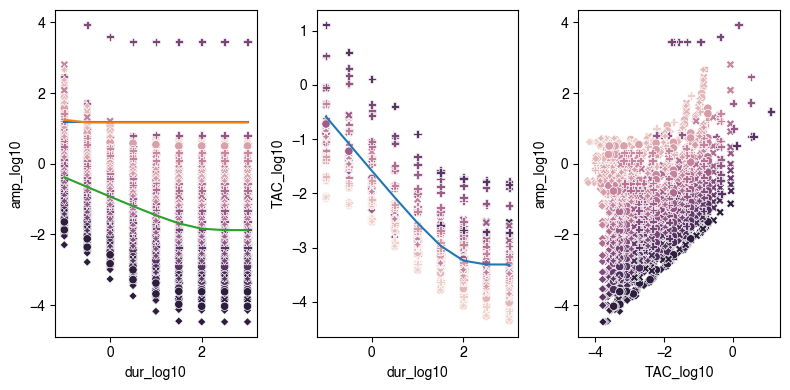

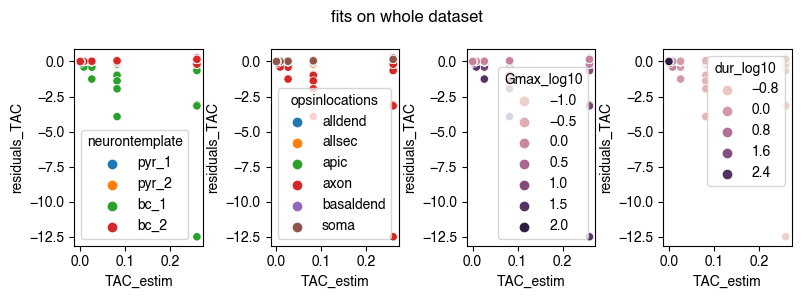

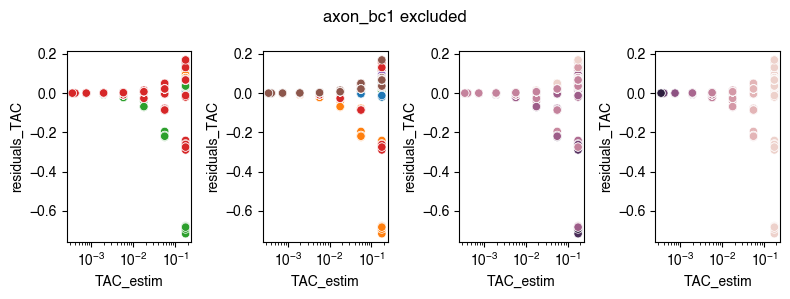

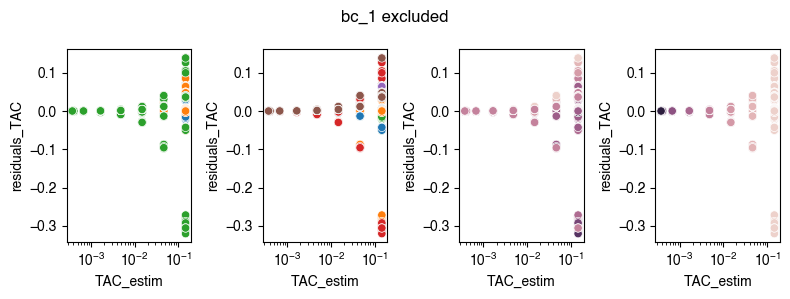

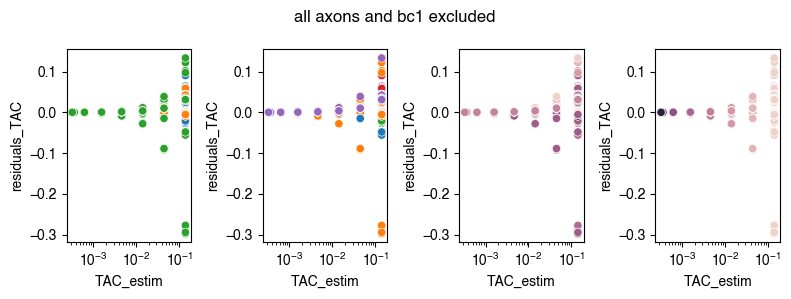

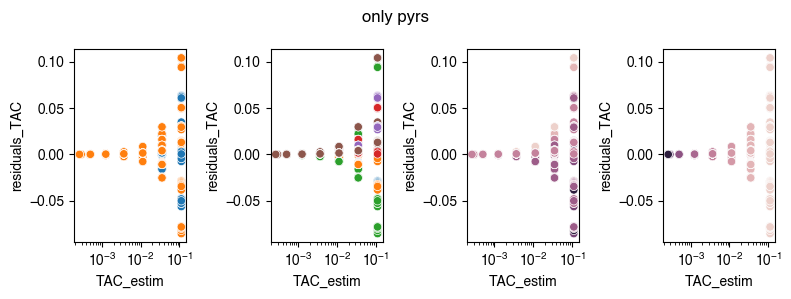

In [19]:
turn_off_legend = True
vHill_Lap = np.vectorize(Hill_Lap)
vpower_ampTAC = np.vectorize(power_ampTAC)

# data fit to pd
# hl = hill lapicque
popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = durfit(
    master_df)

print(f"R2:\n\tTAC: {r2_TAC}\n\tamp_power+hl:  {r2_amp_power}\n\tamp_hl:  {r2_amp_hl}\n\tamp_loglog+hl:  {r2_amp_loglog}")
print(f"TAC rheobase and time constant {popt_TAC_hl}")
print(f"power fit Ith on TAC {popt_amp_power}\n")

fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(8, 4))
sns.scatterplot(data=master_df, x='dur_log10', y='amp_log10',
                hue='Gmax_log10', style='opsinlocations', ax=axs[0])
sns.scatterplot(data=master_df, x='dur_log10', y='TAC_log10',
                ax=axs[1], hue='Gmax_log10', style='opsinlocations')
sns.scatterplot(data=master_df, x='TAC_log10', y='amp_log10',
                ax=axs[2], hue='Gmax_log10', style='opsinlocations')
xvals = unique_values_columns_master['dur']
yvals = vHill_Lap(xvals, *popt_TAC_hl)
yvals_amp = vpower_ampTAC(yvals, *popt_amp_power)
yvals_amp_hl = vHill_Lap(xvals, *popt_amp_hl)
yvals_amp_loglog = popt_amp_loglog[0]*np.log10(yvals)+popt_amp_loglog[1]
print(yvals_amp)
axs[0].plot(np.log10(xvals), np.log10(yvals_amp))
axs[0].plot(np.log10(xvals), np.log10(yvals_amp_hl))
axs[0].plot(np.log10(xvals), yvals_amp_loglog)
axs[1].plot(np.log10(xvals), np.log10(yvals))
axs[0].get_legend().remove()
axs[1].get_legend().remove()
axs[2].get_legend().remove()


fig, axs = plt.subplots(1, 4, figsize=(8, 3), tight_layout=True)
TAC_estim = vHill_Lap(master_df['dur'], *popt_TAC_hl)
master_df['TAC_estim'] = TAC_estim
master_df['residuals_TAC'] = master_df['TAC_estim'] - master_df['TAC']
sns.scatterplot(master_df, x='TAC_estim', y='residuals_TAC',
                hue='neurontemplate', ax=axs[0])
sns.scatterplot(master_df, x='TAC_estim', y='residuals_TAC',
                hue='opsinlocations', ax=axs[1])
sns.scatterplot(master_df, x='TAC_estim', y='residuals_TAC',
                hue='Gmax_log10', ax=axs[2])
sns.scatterplot(master_df, x='TAC_estim', y='residuals_TAC',
                hue='dur_log10', ax=axs[3])
fig.suptitle('fits on whole dataset')

print('exclude bc1 axon')
idx = (master_df['neurontemplate'] == 'bc_1') & (
    master_df['opsinlocations'] == 'axon')
popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = durfit(
    master_df[~idx])
print(r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog)
TAC_estim = vHill_Lap(master_df['dur'], *popt_TAC_hl)
master_df['TAC_estim'] = TAC_estim
master_df['residuals_TAC'] = master_df['TAC_estim'] - master_df['TAC']
fig, axs = plt.subplots(1, 4, figsize=(8, 3), tight_layout=True)
sns.scatterplot(master_df[~idx], x='TAC_estim',
                y='residuals_TAC', hue='neurontemplate', ax=axs[0])
sns.scatterplot(master_df[~idx], x='TAC_estim',
                y='residuals_TAC', hue='opsinlocations', ax=axs[1])
sns.scatterplot(master_df[~idx], x='TAC_estim',
                y='residuals_TAC', hue='Gmax_log10', ax=axs[2])
sns.scatterplot(master_df[~idx], x='TAC_estim',
                y='residuals_TAC', hue='dur_log10', ax=axs[3])
master_df.pop('TAC_estim')
master_df.pop('residuals_TAC')
for ax in axs.ravel():
    ax.set_xscale('log')
    if turn_off_legend:
        ax.get_legend().remove()
fig.suptitle('axon_bc1 excluded')

print('exclude bc1')
idx = (master_df['neurontemplate'] == 'bc_1')
popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = durfit(
    master_df[~idx])
print(r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog)
TAC_estim = vHill_Lap(master_df['dur'], *popt_TAC_hl)
master_df['TAC_estim'] = TAC_estim
master_df['residuals_TAC'] = master_df['TAC_estim'] - master_df['TAC']
fig, axs = plt.subplots(1, 4, figsize=(8, 3), tight_layout=True)
sns.scatterplot(master_df[~idx], x='TAC_estim',
                y='residuals_TAC', hue='neurontemplate', ax=axs[0])
sns.scatterplot(master_df[~idx], x='TAC_estim',
                y='residuals_TAC', hue='opsinlocations', ax=axs[1])
sns.scatterplot(master_df[~idx], x='TAC_estim',
                y='residuals_TAC', hue='Gmax_log10', ax=axs[2])
sns.scatterplot(master_df[~idx], x='TAC_estim',
                y='residuals_TAC', hue='dur_log10', ax=axs[3])
master_df.pop('TAC_estim')
master_df.pop('residuals_TAC')
for ax in axs.ravel():
    ax.set_xscale('log')
    if turn_off_legend:
        ax.get_legend().remove()
fig.suptitle('bc_1 excluded')

print('exclude all axon and bc_1')
idx = (master_df['opsinlocations'] == 'axon') | (
    master_df['neurontemplate'] == 'bc_1')
popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = durfit(
    master_df[~idx])
print(r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog)
TAC_estim = vHill_Lap(master_df['dur'], *popt_TAC_hl)
master_df['TAC_estim'] = TAC_estim
master_df['residuals_TAC'] = master_df['TAC_estim'] - master_df['TAC']
fig, axs = plt.subplots(1, 4, figsize=(8, 3), tight_layout=True)
sns.scatterplot(master_df[~idx], x='TAC_estim',
                y='residuals_TAC', hue='neurontemplate', ax=axs[0])
sns.scatterplot(master_df[~idx], x='TAC_estim',
                y='residuals_TAC', hue='opsinlocations', ax=axs[1])
sns.scatterplot(master_df[~idx], x='TAC_estim',
                y='residuals_TAC', hue='Gmax_log10', ax=axs[2])
sns.scatterplot(master_df[~idx], x='TAC_estim',
                y='residuals_TAC', hue='dur_log10', ax=axs[3])
master_df.pop('TAC_estim')
master_df.pop('residuals_TAC')
for ax in axs.ravel():
    ax.set_xscale('log')
    if turn_off_legend:
        ax.get_legend().remove()
fig.suptitle('all axons and bc1 excluded')

print('only pyrs')
idx = (master_df['neurontemplate'] == 'bc_2') | (
    master_df['neurontemplate'] == 'bc_1')
popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = durfit(
    master_df[~idx])
print(r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog)
TAC_estim = vHill_Lap(master_df['dur'], *popt_TAC_hl)
master_df['TAC_estim'] = TAC_estim
master_df['residuals_TAC'] = master_df['TAC_estim'] - master_df['TAC']
fig, axs = plt.subplots(1, 4, figsize=(8, 3), tight_layout=True)
sns.scatterplot(master_df[~idx], x='TAC_estim',
                y='residuals_TAC', hue='neurontemplate', ax=axs[0])
sns.scatterplot(master_df[~idx], x='TAC_estim',
                y='residuals_TAC', hue='opsinlocations', ax=axs[1])
sns.scatterplot(master_df[~idx], x='TAC_estim',
                y='residuals_TAC', hue='Gmax_log10', ax=axs[2])
sns.scatterplot(master_df[~idx], x='TAC_estim',
                y='residuals_TAC', hue='dur_log10', ax=axs[3])
master_df.pop('TAC_estim')
master_df.pop('residuals_TAC')
for ax in axs.ravel():
    ax.set_xscale('log')
    if turn_off_legend:
        ax.get_legend().remove()
fig.suptitle('only pyrs')

**Heteroscedasticity (wikipedia)**
**consequence**\
One of the assumptions of the classical linear regression model is that there is no heteroscedasticity. Breaking this assumption means that the Gauss–Markov theorem does not apply, meaning that OLS estimators are not the Best Linear Unbiased Estimators (BLUE) and their variance is not the lowest of all other unbiased estimators. Heteroscedasticity does not cause ordinary least squares coefficient estimates to be biased, although it can cause ordinary least squares estimates of the variance (and, thus, standard errors) of the coefficients to be biased, possibly above or below the true of population variance. Thus, regression analysis using heteroscedastic data will still provide an unbiased estimate for the relationship between the predictor variable and the outcome, but standard errors and therefore inferences obtained from data analysis are suspect. **Biased standard errors lead to biased inference, so results of hypothesis tests are possibly wrong. For example, if OLS is performed on a heteroscedastic data set, yielding biased standard error estimation, a researcher might fail to reject a null hypothesis at a given significance level, when that null hypothesis was actually uncharacteristic of the actual population (making a type II error).**

#### regression wrt pulse duration per model and opsinlocation

R2 values
  TAC, Ith: power+TAC, Ith: hill lapcique, Ith: loglog+TAC
pyr_1_alldend 0.9998139152956034 0.09339008753346112 0.10946214226876749 0.11901700984474206
pyr_1_allsec 0.9997808041405623 0.09968583356343519 0.11708774106889719 0.17399143334118405
pyr_1_apic 0.999715120441369 0.0368443643494335 0.053469632891769425 0.1892616369255672
pyr_1_axon 0.9997802576111913 0.12050571024276091 0.13966741122916926 0.08984908629932553
pyr_1_basaldend 0.999527380828357 -0.027027027027069828 0.06544680301188621 0.13747050648537262
pyr_1_soma 0.9998321081370297 0.15450360933575735 0.17425350987240928 0.16903884612407427
pyr_2_alldend 0.9997800965263506 0.0871734576435137 0.10535747558734665 0.2428403523553907
pyr_2_allsec 0.9998341695234092 0.08472758759135224 0.10313525859032724 0.24139493856333494
pyr_2_apic 0.9998542204686367 0.1264560183527027 0.14503127636957536 0.14292096089752238
pyr_2_axon 0.9999225259899394 -0.03478260869583716 0.07871463325976591 0.17242655927388417
pyr_2_basaldend 0.9

d:\Users\rschoete\Documents\Optogenetics\OptogeneticExcitability\Code\Analyses\functionsAnalysis.py:336: RuntimeWarning: overflow encountered in exp
  return I0/(1-np.exp(-pd/tau))
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


bc_2_allsec 0.9997297195271994 0.15452972271938237 0.1759076267050821 0.17954134437863312
bc_2_axon 0.9995893708385266 0.2022066709424335 0.228410755678922 0.16196036758923604
bc_2_soma 0.9996717920053444 0.12917862397458857 0.15265341426138446 0.30281101001104926


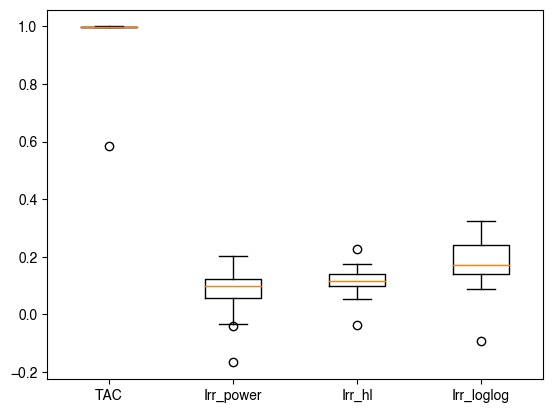

In [20]:
# fit TAC per model and opsinlocation

dur_fits = {}
master_df['nt_ol'] = master_df.apply(
    lambda row: f"{row['neurontemplate']}_{row['opsinlocations']}", axis=1)
boxplot_data = np.zeros((len(master_df['nt_ol'].unique()), 4))
print('R2 values\n  TAC, Ith: power+TAC, Ith: hill lapcique, Ith: loglog+TAC')
for i, ntol in enumerate(master_df['nt_ol'].unique()):
    idx = master_df['nt_ol'] == ntol
    popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = durfit(
        master_df[idx])
    dur_fits[ntol] = {'TAC': {'p': popt_TAC_hl, 'r2': r2_TAC}, 'amp_power': {'p': popt_amp_power, 'r2': r2_amp_power},
                      'amp_hl': {'p': popt_amp_hl, 'r2': r2_amp_hl}, 'amp_loglog': {'p': popt_amp_loglog, 'r2': r2_amp_loglog}}
    master_df.loc[idx, 'TAC_estim'] = TAC_estim = vHill_Lap(
        master_df.loc[idx, 'dur'], *popt_TAC_hl)

    print(ntol,  r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog)
    boxplot_data[i, :] = [r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog]

plt.figure()
plt.boxplot(boxplot_data)
ax = plt.gca()
ax.set_xticklabels(['TAC', 'Irr_power', 'Irr_hl', 'Irr_loglog'])
master_df['TAC_estim_log10'] = np.log10(master_df['TAC_estim'])

Very high R2adj for TAC fits: variance due to duration only

### Ordinary leas square fits and linear mixed model analyses with statsmodel

In [21]:
#  the intercept in fits below is should now refer to pyr1_soma
master_df['nt_ol2'] = master_df['nt_ol'].replace({'pyr_1_soma': 'a_pyr1_soma'})

idx_nan_inf = np.isnan(master_df['amp_log10']) | np.isinf(master_df['amp_log10']) | \
    np.isnan(master_df['TAC_estim_log10']) | np.isinf(
        master_df['TAC_estim_log10'])
double_linear_model = smf.ols(
    formula='amp_log10 ~ Gmax_log10 + TAC_estim_log10', data=master_df[~idx_nan_inf]).fit()
summary = double_linear_model.summary2()
print('summary multi linear model')
print(summary)

multi_linear_model = smf.ols(
    formula='amp_log10 ~ Gmax_log10 + TAC_estim_log10 + C(nt_ol2)', data=master_df[~idx_nan_inf]).fit()
summary = multi_linear_model.summary2()
print('summary multi linear model')
print(summary)

md = smf.mixedlm("amp_log10 ~ Gmax_log10 + TAC_estim_log10",
                 data=master_df[~idx_nan_inf], groups="nt_ol2")
mdf = md.fit()
print('summary mixded multi linear model')
print(mdf.summary())

summary multi linear model
                 Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.880    
Dependent Variable: amp_log10        AIC:                2788.8827
Date:               2023-06-06 11:40 BIC:                2806.1564
No. Observations:   2340             Log-Likelihood:     -1391.4  
Df Model:           2                F-statistic:        8564.    
Df Residuals:       2337             Prob (F-statistic): 0.00     
R-squared:          0.880            Scale:              0.19256  
------------------------------------------------------------------
                  Coef.  Std.Err.     t     P>|t|   [0.025  0.975]
------------------------------------------------------------------
Intercept         1.1282   0.0258   43.7390 0.0000  1.0776  1.1788
Gmax_log10       -1.3851   0.0123 -112.4562 0.0000 -1.4093 -1.3609
TAC_estim_log10   0.6494   0.0091   71.3842 0.0000  0.6316  0.6672
-----------------------------------------------------

#### interaction testing

In [22]:
# extra testing with interactions
print('Gmax:nt_ol interaction')
print('-------------------------------------------\n')

multi_linear_model_interaction = smf.ols(
    formula='amp_log10 ~ Gmax_log10*C(nt_ol2) + TAC_estim_log10 + C(nt_ol2)', data=master_df[~idx_nan_inf]).fit()
summary = multi_linear_model_interaction.summary2()
print('summary multi linear model')
print(summary)
a_lm = anova_lm(multi_linear_model, multi_linear_model_interaction)
print(a_lm)
md_interaction = smf.mixedlm("amp_log10 ~ Gmax_log10 + TAC_estim_log10",
                             data=master_df[~idx_nan_inf], groups="nt_ol2", re_formula='~Gmax_log10')
mdf_interaction = md_interaction.fit()
print('summary mixded multi linear model')
print(mdf_interaction.summary())

print('\n\n\n')

print('Gmax:dur interaction')
print('-------------------------------------------\n')

multi_linear_model_interaction = smf.ols(
    formula='amp_log10 ~ Gmax_log10 + Gmax_log10:dur_log10 + TAC_estim_log10 + C(nt_ol2)', data=master_df[~idx_nan_inf]).fit()
summary = multi_linear_model_interaction.summary2()
print('summary multi linear model')
print(summary)
a_lm = anova_lm(multi_linear_model, multi_linear_model_interaction)
print(a_lm)
md_interaction = smf.mixedlm(
    "amp_log10 ~ Gmax_log10 + Gmax_log10:dur_log10 + TAC_estim_log10", data=master_df[~idx_nan_inf], groups="nt_ol2")
mdf_interaction = md_interaction.fit()
print('summary mixded multi linear model')
print(mdf_interaction.summary())

print('\n\n\n')

Gmax:nt_ol interaction
-------------------------------------------

summary multi linear model
                            Results: Ordinary least squares
Model:                      OLS                     Adj. R-squared:            0.950    
Dependent Variable:         amp_log10               AIC:                       769.8080 
Date:                       2023-06-06 11:40        BIC:                       1005.8821
No. Observations:           2340                    Log-Likelihood:            -343.90  
Df Model:                   40                      F-statistic:               1114.    
Df Residuals:               2299                    Prob (F-statistic):        0.00     
R-squared:                  0.951                   Scale:                     0.079957 
----------------------------------------------------------------------------------------
                                         Coef.  Std.Err.    t     P>|t|   [0.025  0.975]
--------------------------------------------

c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


summary mixded multi linear model
               Mixed Linear Model Regression Results
Model:                MixedLM     Dependent Variable:     amp_log10
No. Observations:     2340        Method:                 REML     
No. Groups:           20          Scale:                  0.0802   
Min. group size:      29          Log-Likelihood:         -443.6344
Max. group size:      153         Converged:              Yes      
Mean group size:      117.0                                        
-------------------------------------------------------------------
                        Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------
Intercept                1.023    0.147   6.959 0.000  0.735  1.311
Gmax_log10              -1.488    0.016 -92.834 0.000 -1.519 -1.457
TAC_estim_log10          0.534    0.006  85.249 0.000  0.522  0.546
nt_ol2 Var               0.425    0.512                            
nt_ol2 x Gmax_log10 Cov -0.02

### Two step linear regression Ith_log10~ Gmax_log10 + TAC_hat_log10 with TAC_hat~Hill lapicque(dur)

R2 values: total, TAC, Ith:amp(TAC_hat), Ith_hl, Ith:loglog(TAC_hat)
0.7747439488577419 0.06724641239460516 -0.001713062098512852 -0.0004190666642618357 0.1773393320712362

fit parameters: TAC_hl (dur), Ith:amp(TAC_hat(dur)), Ith_hl(dur), Ith:loglog(TAC_hat(dur)), Ith(gmax)
[4.88795868e-04 5.30700014e+01] [ 4.93507571 18.62748931 15.06271446] [14.71083791  0.0552735 ] [0.5486966127342381, -0.060834324623076697] Intercept     0.781298
Gmax_log10   -1.326465
dtype: float64
R2 values: total, TAC, Ith:amp(TAC_hat), Ith_hl, Ith:loglog(TAC_hat)
0.617157654713623 0.06724641239460516 -0.001713062098512852 -0.0004190666642618357 0.1773393320712362

fit parameters: TAC_hl (dur), Ith:amp(TAC_hat(dur)), Ith_hl(dur), Ith:loglog(TAC_hat(dur)), Ith_log10(gmax_log10)
[4.88795868e-04 5.30700014e+01] [ 4.93507571 18.62748931 15.06271446] [14.71083791  0.0552735 ] [0.5486966127342381, -0.060834324623076697] Intercept    -1.693837
Gmax_log10   -1.349937
dtype: float64


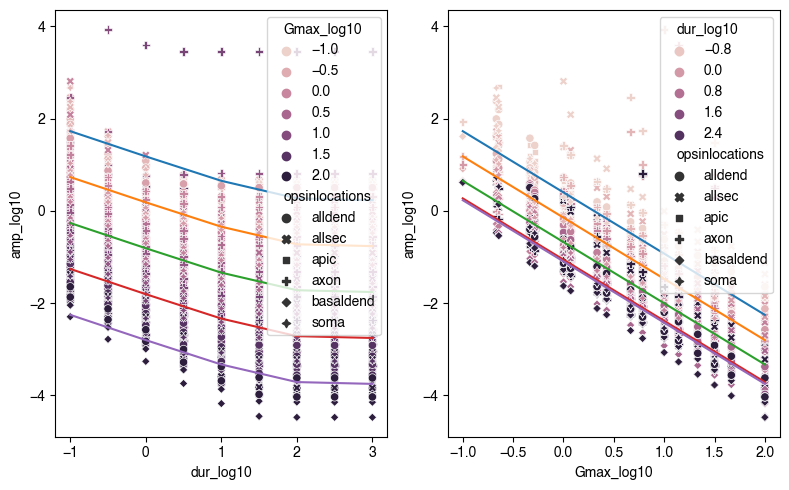

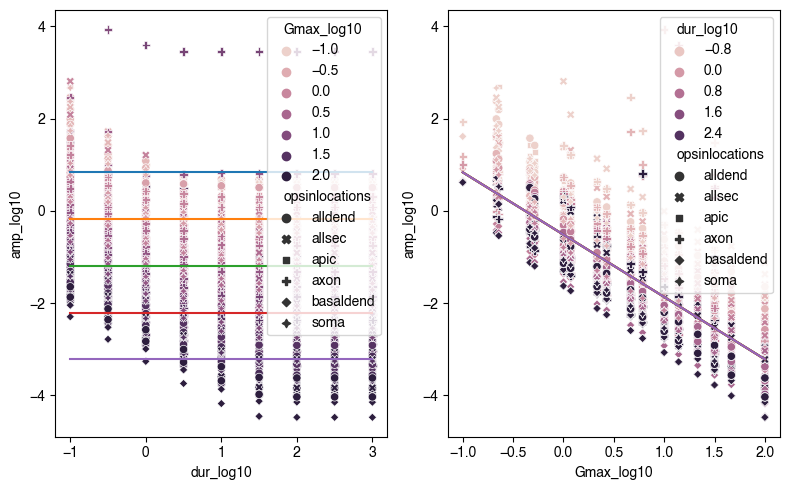

In [23]:
# loglog on top of hat
vmymodel, r2_tot, single_linear_model, popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = Gmaxfitafterdurfit(
    master_df, usedur='loglog')

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(8, 5))
sns.scatterplot(data=master_df, x='dur_log10', y='amp_log10',
                hue='Gmax_log10', style='opsinlocations', ax=axs[0])
xdata_dur = np.logspace(-1, 3, 5)
xdata_gmax = np.logspace(-1, 2, 5)
for x in xdata_gmax:
    axs[0].plot(np.log10(xdata_dur), vmymodel(xdata_dur, x))

sns.scatterplot(data=master_df, x='Gmax_log10', y='amp_log10',
                hue='dur_log10', style='opsinlocations', ax=axs[1])
for x in xdata_dur:
    axs[1].plot(np.log10(xdata_gmax), vmymodel(x, xdata_gmax))
print('R2 values: total, TAC, Ith:amp(TAC_hat), Ith_hl, Ith:loglog(TAC_hat)')
print(r2_tot, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog)

print('\nfit parameters: TAC_hl (dur), Ith:amp(TAC_hat(dur)), Ith_hl(dur), Ith:loglog(TAC_hat(dur)), Ith(gmax)')
print(popt_TAC_hl, popt_amp_power, popt_amp_hl,
      popt_amp_loglog, single_linear_model.params)

# power on top of TAC_hat
vmymodel, r2_tot, single_linear_model, popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = Gmaxfitafterdurfit(
    master_df, usedur='power')
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(8, 5))
sns.scatterplot(data=master_df, x='dur_log10', y='amp_log10',
                hue='Gmax_log10', style='opsinlocations', ax=axs[0])
xdata_dur = np.logspace(-1, 3, 5)
xdata_gmax = np.logspace(-1, 2, 5)
for x in xdata_gmax:
    axs[0].plot(np.log10(xdata_dur), vmymodel(xdata_dur, x))
sns.scatterplot(data=master_df, x='Gmax_log10', y='amp_log10',
                hue='dur_log10', style='opsinlocations', ax=axs[1])
for x in xdata_dur:
    axs[1].plot(np.log10(xdata_gmax), vmymodel(x, xdata_gmax))

print('R2 values: total, TAC, Ith:amp(TAC_hat), Ith_hl, Ith:loglog(TAC_hat)')
print(r2_tot, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog)
print('\nfit parameters: TAC_hl (dur), Ith:amp(TAC_hat(dur)), Ith_hl(dur), Ith:loglog(TAC_hat(dur)), Ith_log10(gmax_log10)')
print(popt_TAC_hl, popt_amp_power, popt_amp_hl,
      popt_amp_loglog, single_linear_model.params)

#### Collect all fits two step regression for each neurontemplate opsinlocations combo

d:\Users\rschoete\Documents\Optogenetics\OptogeneticExcitability\Code\Analyses\functionsAnalysis.py:336: RuntimeWarning: overflow encountered in exp
  return I0/(1-np.exp(-pd/tau))
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


Irheo     tchron            pa         pb         pc     rico_g  \
count  20.000000  20.000000     20.000000  20.000000  20.000000  20.000000   
mean    0.002128  40.437539   1989.213539   2.850321   0.779191  -1.478324   
std     0.007344   9.511954   7903.389636   2.978945   1.666070   0.070741   
min     0.000111  17.268901     -0.121662   0.002155   0.010570  -1.630053   
25%     0.000252  38.937104     41.398621   1.503210   0.216040  -1.517579   
50%     0.000317  42.949133    163.319487   1.556358   0.394563  -1.457702   
75%     0.000436  44.477051    321.350464   2.070261   0.633487  -1.436902   
max     0.033245  55.054233  35549.693049  11.247232   7.746527  -1.365614   

               c   slopeamp       camp     r2_tot     r2_TAC  r2_amp_power  \
count  20.000000  20.000000  20.000000  20.000000  20.000000     20.000000   
mean    0.904869   0.558313   0.186264   0.907120   0.978964      0.076631   
std     0.349384   0.107121   0.382826   0.235467   0.093024      0.085582   
min     0.383830   0.291634  -0.128621  -0.092876   0.583751     -0.166660   
25%     0.646096   0.509393  -0.053391   0.954766   0.999704      0.058935   
50%     0.912441   0.556106   0.112249   0.961175   0.999781      0.098902   
75%     1.077211   0.637522   0.233036   0.963746   0.999823      0.121993   
max     1.642329   0.722157   1.617160   0.970020   0.999923      0.202207   

       r2_amp_hl  r2_amp_loglog         pa1e3  
count  20.000000      20.000000  2.000000e+01  
mean    0.116736       0.176996  1.989214e+06  
std     0.054175       0.090988  7.903390e+06  
min    -0.037037      -0.090938 -1.216624e+02  
25%     0.099373       0.141558  4.139862e+04  
50%     0.117191       0.170733  1.633195e+05  
75%     0.141008       0.241756  3.213505e+05  
max     0.228411       0.325156  3.554969e+07

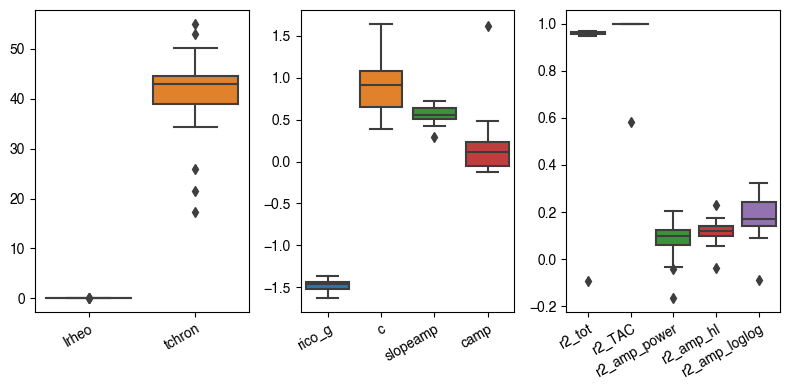

In [24]:
# collect all fits for nt_ol seperatly
master_df['nt_ol'] = master_df['neurontemplate']+master_df['opsinlocations']
ukeys = master_df['nt_ol'].unique()
myfits_info_dict = {}
mymodels = {}
idx = -1
for nt_ol in ukeys:

    idx += 1
    intm_df = master_df[master_df['nt_ol'] == nt_ol].copy()
    try:
        vmymodel, r2_tot, single_linear_model, popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = Gmaxfitafterdurfit(
            intm_df, usedur='loglog')
        data = intm_df[['dur', 'Gmax', 'amp']].to_numpy()
        data = data[np.lexsort((data[:, 0], data[:, 1])), :]
        durs = np.log10(np.unique(data[:, 0]))
        Gmaxs = np.log10(np.unique(data[:, 1]))
        Irr_log10 = np.log10(np.reshape(data[:, 2], (len(Gmaxs), len(durs))))
        Irr_log10[np.isnan(Irr_log10)] = 3.5

        def interp_model(dur, Gmax): return interpn((Gmaxs, durs), Irr_log10, (np.log10(
            Gmax), np.log10(dur)), method='nearest', bounds_error=False, fill_value=None)
        fit_info = {'Irheo': popt_TAC_hl[0], 'tchron': popt_TAC_hl[1], 'pa': popt_amp_power[0], 'pb': popt_amp_power[1], 'pc': popt_amp_power[2], 'rico_g': single_linear_model.params['Gmax_log10'], 'c': single_linear_model.params['Intercept'], 'slopeamp': popt_amp_loglog[0],
                    'camp': popt_amp_loglog[1], 'r2_tot': r2_tot,  'r2_TAC': r2_TAC, 'r2_amp_power': r2_amp_power, 'r2_amp_hl': r2_amp_hl, 'r2_amp_loglog': r2_amp_loglog, 'neurontemplate': intm_df['neurontemplate'].iloc[0], 'opsinlocation': intm_df['opsinlocations'].iloc[0]}
        myfits_info_dict[idx] = fit_info
        mymodels[nt_ol] = {'model': vmymodel, 'model_interp': interp_model, 'statsmodel': single_linear_model,
                           'neurontemplate': intm_df['neurontemplate'].iloc[0], 'opsinlocation': intm_df['opsinlocations'].iloc[0]}
    except:
        print(f"error for fit of {nt_ol}")
models_df = pd.DataFrame.from_dict(myfits_info_dict, orient='index')
models_df['pa1e3'] = models_df['pa']*1000

# plot
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(8, 4))
sns.boxplot(models_df[['Irheo', 'tchron']], ax=axs[0])
plt.setp(axs[0].get_xticklabels(), rotation=30, ha="right",
         rotation_mode="anchor")
sns.boxplot(models_df[['rico_g', 'c', 'slopeamp', 'camp']], ax=axs[1])
plt.setp(axs[1].get_xticklabels(), rotation=30, ha="right",
         rotation_mode="anchor")
sns.boxplot(models_df[[x for x in models_df.columns if 'r2' in x]], ax=axs[2])
plt.setp(axs[2].get_xticklabels(), rotation=30, ha="right",
         rotation_mode="anchor")
models_df[[x for x in models_df.columns if not '_mu' in x]].describe()

#### Paper plots

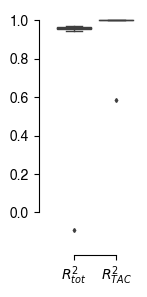

In [25]:
# R2 boxplot
fig, ax = plt.subplots(1, 1, tight_layout=True, figsize=(4/2.54, 7.8/2.54))
sns.boxplot(models_df[['r2_tot', 'r2_TAC']], ax=ax, fliersize=2, linewidth=1)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_xticklabels(['$R^2_{tot}$', '$R^2_{TAC}$'])
sns.despine(offset=10, trim=True, ax=ax)
fig.savefig('r2.svg')

d:\Users\rschoete\Documents\Optogenetics\OptogeneticExcitability\Code\Analyses\functionsAnalysis.py:336: RuntimeWarning: overflow encountered in exp
  return I0/(1-np.exp(-pd/tau))
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\scipy\optimize\minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


        r2_tot   r2_TAC    Irheo      Tau   a_Gmax    a_TAC  intercept
count  20.0000  20.0000  20.0000  20.0000  20.0000  20.0000    20.0000
mean    0.9168   0.9790   0.0021  40.4375  -1.4851   0.5162     1.0018
std     0.2075   0.0930   0.0073   9.5120   0.0679   0.0887     0.5706
min     0.0356   0.5838   0.0001  17.2689  -1.6301   0.2043     0.4275
25%     0.9589   0.9997   0.0003  38.9371  -1.5176   0.5058     0.7222
50%     0.9639   0.9998   0.0003  42.9491  -1.4677   0.5337     0.9507
75%     0.9676   0.9998   0.0004  44.4771  -1.4434   0.5543     1.0252
max     0.9775   0.9999   0.0332  55.0542  -1.4006   0.6133     3.1121
fit summary excluding bc1_axon
        r2_tot   r2_TAC    Irheo      Tau   a_Gmax    a_TAC  intercept
count  19.0000  19.0000  19.0000  19.0000  19.0000  19.0000    19.0000
mean    0.9631   0.9998   0.0005  41.6569  -1.4893   0.5326     0.8907
std     0.0072   0.0001   0.0006   8.0070   0.0671   0.0511     0.2885
min     0.9480   0.9995   0.0001  21.4403  -1.

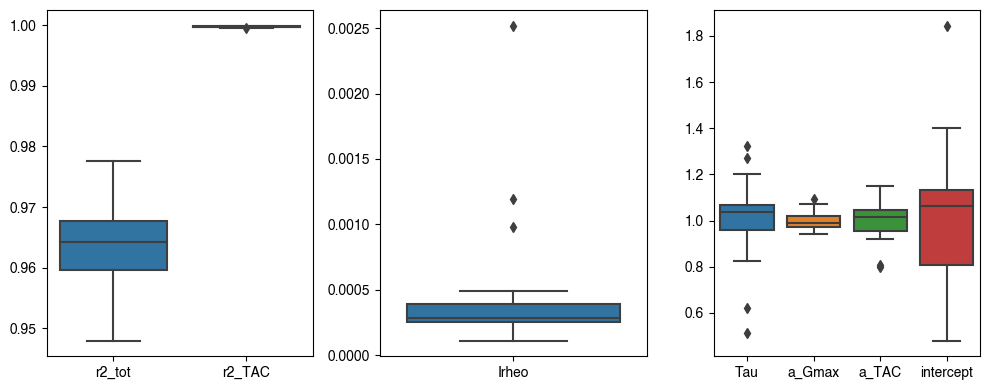

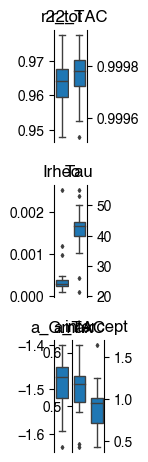

In [26]:
# boxplot of all parameters
fits = {}
master_df['nt_ol'] = master_df.apply(
    lambda row: f"{row['neurontemplate']}_{row['opsinlocations']}", axis=1)
untol = master_df['nt_ol'].unique()

boxplot_data = np.zeros((len(untol), 4))
for i, ntol in enumerate(untol):
    idx = master_df['nt_ol'] == ntol
    intm_df = master_df[idx].copy()
    popt_TAC_hl, popt_amp_power, popt_amp_hl, popt_amp_loglog, r2_TAC, r2_amp_power, r2_amp_hl, r2_amp_loglog = durfit(
        intm_df)
    intm_df['TAC_estim'] = vHill_Lap(intm_df['dur'], *popt_TAC_hl)
    intm_df['TAC_estim_log10'] = np.log10(intm_df['TAC_estim'])

    r2adj_TAC = r2_TAC
    pIrheo = popt_TAC_hl[0]
    pTau = popt_TAC_hl[1]

    idx_nan_inf = np.isnan(intm_df['amp_log10']) | np.isinf(intm_df['amp_log10']) | \
        np.isnan(intm_df['TAC_estim_log10']) | np.isinf(
            intm_df['TAC_estim_log10'])
    double_linear_model = smf.ols(
        formula='amp_log10 ~ Gmax_log10 + TAC_estim_log10', data=intm_df[~idx_nan_inf]).fit()

    r2adj_tot = double_linear_model.rsquared_adj
    pa_Gl10 = double_linear_model.params['Gmax_log10']
    pa_TACl10 = double_linear_model.params['TAC_estim_log10']
    pc = double_linear_model.params['Intercept']

    fits[ntol] = dict(r2_tot=r2adj_tot, r2_TAC=r2adj_TAC, Irheo=pIrheo,
                      Tau=pTau, a_Gmax=pa_Gl10, a_TAC=pa_TACl10, intercept=pc)

    # print(f"{ntol}:\n\tr2_tot:\t{r2adj_tot}\n\tr2_TAC:\t{r2adj_TAC}\n\tIrheo:\t{pIrheo}\n\tTau:\t{pTau}\n\ta_Gmax:\t{pa_Gl10}\n\ta_TAC:\t{pa_TACl10}\nintercept: \t{pc}")

myfit_df = pd.DataFrame(fits)
myfit_df = myfit_df.T
myfit_df.reset_index(inplace=True)
myfit_df = myfit_df.rename(columns={'index': 'nt_ol'})
print(myfit_df.describe().round(4))

print('fit summary excluding bc1_axon')
print(myfit_df[myfit_df['nt_ol'] != 'bc_1_axon'].describe().round(4))

# create boxplot
fig, axs = plt.subplots(1, 3, tight_layout=True, figsize=(10, 4))
idx = myfit_df['nt_ol'] != 'bc_1_axon'
sns.boxplot(myfit_df.loc[idx, ['r2_tot', 'r2_TAC']], ax=axs[0])
sns.boxplot(myfit_df.loc[idx, ['Irheo']], ax=axs[1])
intm_df = myfit_df.loc[idx, ['Tau', 'a_Gmax', 'a_TAC', 'intercept']].copy()
# intm_df['Irheo']*=1000
# intm_df['Tau']*=1/100
# intm_df['a_Gmax']*=-1
for key in intm_df.columns:
    intm_df[key] *= 1/np.mean(intm_df[key])
sns.boxplot(intm_df, ax=axs[2])


# PAPER PLOT reorganize boxplots
fig = plt.figure(tight_layout=True, figsize=(4/2.54, 12/2.54))
axs = []
gs0 = mpl.gridspec.GridSpec(3, 1, figure=fig)
gs00 = gs0[0].subgridspec(1, 3)
gs10 = gs0[1].subgridspec(1, 3)
gs20 = gs0[2].subgridspec(1, 3)
axs.append(fig.add_subplot(gs00[0]))
axs.append(fig.add_subplot(gs00[1]))
axs.append(fig.add_subplot(gs10[0]))
axs.append(fig.add_subplot(gs10[1]))
axs.append(fig.add_subplot(gs20[0]))
axs.append(fig.add_subplot(gs20[1]))
axs.append(fig.add_subplot(gs20[2]))
cols = [x for x in myfit_df.columns if not 'nt_ol' == x]


for i, (key, ax) in enumerate(zip(cols, axs)):
    print(key)
    sns.boxplot(myfit_df.loc[idx, [key]], ax=ax,
                fliersize=2, linewidth=1, saturation=1)
    ax.set_title(key)
    ax.set_xticks([])
    if i in [1, 3, 6]:
        ax.yaxis.tick_right()
        ax.spines[['top', 'left', 'bottom']].set_visible(False)
    else:
        ax.spines[['top', 'right', 'bottom']].set_visible(False)
fig.savefig('fit_dur_gmax.svg', dpi=300)

## Comparison with Grossman2013
**Model fits are required, run cell under collect all fits**\
One possible way of comparing different spatial illumination patterns would be to compare the ChR2  densities (gChR) required  for  a fixed threshold illumination. Table3 summarizes the results when the threshold was set to a single **20 ms light pulse of 1mW/mm2** and then the parameter g_ChR was tuned to give the same threshold irradiancefor spiking for each illumination case.

We calculated Ith for fixed G (g*A) determine G for fixed pd and Ith

From Grossman2011 G(V) = g2(1-exp(-V/40))/(V/15). In our model: G(V) = g1(1-1.25 exp(-V/44.52))/V. Idea in grossman is that G(V=V_rest) == 1 => V_rest\approx-70 => g2 1.0188 = g1 0.072 => g1 = 14.15 g2

In [27]:
Vr = -68.8293  # value for which G(V) of grossman is 1
corrFactor = ((1-np.exp(-Vr/40))/(Vr/15))/((1-1.25*np.exp(-(Vr/44.52)))/Vr)
diffWilliams_corrFactor = (
    (10.6408-14.6408*np.exp(-Vr/42.767))/(Vr))/((1-1.25*np.exp(-(Vr/44.52)))/Vr)
print('corrFactor: ', corrFactor, '\n Williams:', diffWilliams_corrFactor)
dur = 20
Ith = 1
cells = master_df['neurontemplate'].unique()
ols = master_df['opsinlocations'].unique()
nt_ols = [''.join(x.rsplit('_', 1)) for x in master_df['nt_ol'].unique()]
nt_ols
coll_rootinfo = False
GmaxforIthequals1 = {}
for cell in cells:
    GmaxforIthequals1[cell] = {}
    for ol in ols:
        nt_ol = cell+ol
        if nt_ol in nt_ols:
            myfun = mymodels[nt_ol]['model']
            rootinfo = optimize.root(lambda x: myfun(
                dur, 10**x)-np.log10(Ith), np.log10(0.1))
            rootinfo.x = 10**rootinfo.x
            if coll_rootinfo:
                GmaxforIthequals1[cell][ol] = rootinfo
            else:
                # same units Grossman [nS, pS/um2]
                GmaxforIthequals1[cell][ol] = {
                    'Gmax': rootinfo.x[0]*1e3, 'gmax': rootinfo.x[0]*1e6/surfaces[ol][cell]}

print(GmaxforIthequals1)


singleChannelConductance = np.array([100, 40])  # fS
reform = {(outerKey, innerKey): values for outerKey, innerDict in GmaxforIthequals1.items()
          for innerKey, values in innerDict.items()}
df = pd.DataFrame(reform)
df = df.T.reset_index()
df = df.rename(columns={'level_0': 'cell', 'level_1': 'ol'})
df['relgmax'] = df['gmax']
df['relGmax'] = df['Gmax']
for cell in df['cell'].unique():
    somag = df.loc[(df['cell'] == cell) & (df['ol'] == 'soma'), 'gmax'].values
    df.loc[df['cell'] == cell, 'relgmax'] = np.round(
        df.loc[df['cell'] == cell, 'gmax']/somag*100)

    somaG = df.loc[(df['cell'] == cell) & (df['ol'] == 'soma'), 'Gmax'].values
    df.loc[df['cell'] == cell, 'relGmax'] = np.round(
        df.loc[df['cell'] == cell, 'Gmax']/somaG*100)
df['gmax[S/cm2]'] = df['gmax']*1e-12/1e-8
df['Gmax[uS]'] = df['Gmax']*1e-3
df['denisty[opsin/um2]'] = list(np.round(df['gmax'].to_numpy()
                                [:, None]/(singleChannelConductance[None, :]*1e-3)))
df['total opsins [M]'] = list(np.round(df['Gmax'].to_numpy(
)[:, None]/(singleChannelConductance[None, :]*1e-6)*1e-6, 2))
df['Gmax[nS]/corrF'] = df['Gmax']/corrFactor
df['gmax[pS/um2]/corrF'] = df['gmax']/corrFactor
df['denisty[opsin/um2]/corrF'] = list(np.round(df['gmax[pS/um2]/corrF'].to_numpy()[
                                      :, None]/(singleChannelConductance[None, :]*1e-3)))
df['total opsins [M]/corrF'] = list(np.round(df['Gmax[nS]/corrF'].to_numpy()[
                                    :, None]/(singleChannelConductance[None, :]*1e-6)*1e-6, 2))
df = df.rename(columns={'gmax': 'gmax[pS/um2]', 'Gmax': 'Gmax[nS]'})
df = df.set_index(['cell', 'ol'])
df[['Gmax[uS]', 'gmax[S/cm2]', 'Gmax[nS]/corrF', 'gmax[pS/um2]/corrF',
    'denisty[opsin/um2]/corrF', 'total opsins [M]/corrF']]

corrFactor:  14.144919545978418 
 Williams: 12.8566502438902
{'pyr_1': {'alldend': {'Gmax': 258.73923931028855, 'gmax': 12.488759133356947}, 'allsec': {'Gmax': 222.6525607569156, 'gmax': 9.656225027871782}, 'apic': {'Gmax': 324.82022002165706, 'gmax': 21.966874555966534}, 'axon': {'Gmax': 302.51259851372765, 'gmax': 184.38020266576927}, 'basaldend': {'Gmax': 94.56567958443453, 'gmax': 15.944440533883196}, 'soma': {'Gmax': 167.4566773259049, 'gmax': 239.408511317166}}, 'pyr_2': {'alldend': {'Gmax': 255.635547730282, 'gmax': 10.576178762638431}, 'allsec': {'Gmax': 264.7129021879357, 'gmax': 10.324147702138314}, 'apic': {'Gmax': 443.5148739132214, 'gmax': 32.535766055016346}, 'axon': {'Gmax': 119.90709821741014, 'gmax': 114.04192216068604}, 'basaldend': {'Gmax': 173.75667769979458, 'gmax': 16.283897573281244}, 'soma': {'Gmax': 286.8942060778042, 'gmax': 686.5961614881038}}, 'bc_1': {'alldend': {'Gmax': 185.01366597469973, 'gmax': 8.476235124147044}, 'allsec': {'Gmax': 1353.3690151205676, 

Gmax[uS]  gmax[S/cm2]  Gmax[nS]/corrF  gmax[pS/um2]/corrF  \
cell  ol                                                                       
pyr_1 alldend      0.258739     0.001249       18.292026            0.882915   
      allsec       0.222653     0.000966       15.740815            0.682664   
      apic         0.324820     0.002197       22.963738            1.552987   
      axon         0.302513     0.018438       21.386661           13.035083   
      basaldend    0.094566     0.001594        6.685487            1.127220   
      soma         0.167457     0.023941       11.838645           16.925406   
pyr_2 alldend      0.255636     0.001058       18.072605            0.747702   
      allsec       0.264713     0.001032       18.714345            0.729884   
      apic         0.443515     0.003254       31.355065            2.300173   
      axon         0.119907     0.011404        8.477043            8.062395   
      basaldend    0.173757     0.001628       12.284034            1.151219   
      soma         0.286894     0.068660       20.282491           48.540125   
bc_1  alldend      0.185014     0.000848       13.079867            0.599242   
      allsec       1.353369     0.001049       95.678806            0.741527   
      axon       101.992744     0.095836     7210.556655           67.753101   
      soma         0.322047     0.041388       22.767671           29.259846   
bc_2  alldend      0.518102     0.002360       36.628139            1.668779   
      allsec       0.905619     0.001864       64.024319            1.317903   
      axon         1.155774     0.004576       81.709449            3.235220   
      soma         0.206096     0.014987       14.570314           10.595359   

                denisty[opsin/um2]/corrF total opsins [M]/corrF  
cell  ol                                                         
pyr_1 alldend                [9.0, 22.0]           [0.18, 0.46]  
      allsec                 [7.0, 17.0]           [0.16, 0.39]  
      apic                  [16.0, 39.0]           [0.23, 0.57]  
      axon                [130.0, 326.0]           [0.21, 0.53]  
      basaldend             [11.0, 28.0]           [0.07, 0.17]  
      soma                [169.0, 423.0]            [0.12, 0.3]  
pyr_2 alldend                [7.0, 19.0]           [0.18, 0.45]  
      allsec                 [7.0, 18.0]           [0.19, 0.47]  
      apic                  [23.0, 58.0]           [0.31, 0.78]  
      axon                 [81.0, 202.0]           [0.08, 0.21]  
      basaldend             [12.0, 29.0]           [0.12, 0.31]  
      soma               [485.0, 1214.0]            [0.2, 0.51]  
bc_1  alldend                [6.0, 15.0]           [0.13, 0.33]  
      allsec                 [7.0, 19.0]           [0.96, 2.39]  
      axon               [678.0, 1694.0]        [72.11, 180.26]  
      soma                [293.0, 731.0]           [0.23, 0.57]  
bc_2  alldend               [17.0, 42.0]           [0.37, 0.92]  
      allsec                [13.0, 33.0]            [0.64, 1.6]  
      axon                  [32.0, 81.0]           [0.82, 2.04]  
      soma                [106.0, 265.0]           [0.15, 0.36]

(34, 2)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.996
Method:                 Least Squares   F-statistic:                     9173.
Date:                Tue, 06 Jun 2023   Prob (F-statistic):           6.38e-41
Time:                        11:40:55   Log-Likelihood:                 50.393
No. Observations:                  34   AIC:                            -96.79
Df Residuals:                      32   BIC:                            -93.73
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.1640      0.020     -8.402 

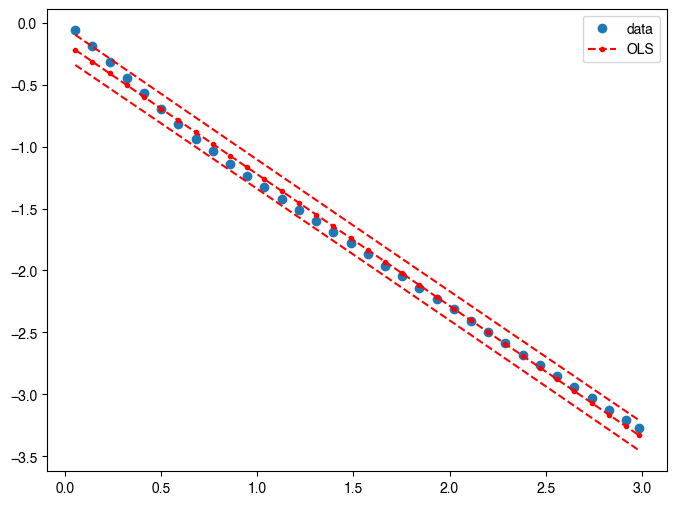

In [28]:
# Ith vs gmax form Grossman2011 ifg8
import statsmodels.api as sm
data_grosman_Ithgmax = np.array([[1.1287784435807249, 0.86814584110807],
                                 [1.386793392958283, 0.6424788833165292],
                                 [1.7038571849892807, 0.480424878647714],
                                 [2.0934115504016755, 0.3592461480324778],
                                 [2.572084467482008, 0.2700281134664376],
                                 [3.160075568291213, 0.20087476526849535],
                                 [3.882648533066344, 0.15098793461123372],
                                 [4.770846330161667, 0.1158670715420453],
                                 [5.862848884197575, 0.09124918034622698],
                                 [7.204800712533522, 0.07186177058800364],
                                 [8.854474644956701, 0.05748010437181931],
                                 [10.88279286530818, 0.04693946190968076],
                                 [13.375177634360348, 0.03793658235129453],
                                 [16.438370091649002, 0.030660434141017146],
                                 [20.204378837608907, 0.025168022281563812],
                                 [24.83265000788638, 0.020552736223051277],
                                 [30.519840733730135, 0.016610769245086168],
                                 [37.51110238669661, 0.013564703453330568],
                                 [46.10192106863535, 0.010963024898289993],
                                 [56.66380992878677, 0.008999143770909018],
                                 [69.64099497410511, 0.007273128938144469],
                                 [85.59203405006261, 0.005908695567458922],
                                 [105.20105532284612, 0.004850230789714757],
                                 [129.2942739680998, 0.003919967811536635],
                                 [158.91205957280332, 0.0032011281431668474],
                                 [195.31034010899054, 0.002600598976212213],
                                 [240.03537323688127, 0.002090948098198837],
                                 [295.0396372505853, 0.0017342611870900162],
                                 [362.60981957888896, 0.0014016339273187363],
                                 [445.67382206594147, 0.001144603738314536],
                                 [547.7539338384454, 0.0009298769611530394],
                                 [673.2009196245424, 0.0007515287239813546],
                                 [827.447854794027, 0.0006201069589151946],
                                 [965.8865175150512, 0.0005333896470173888],
                                 ])
print(data_grosman_Ithgmax.shape)
x = np.log10(data_grosman_Ithgmax[:, 0])
y = np.log10(data_grosman_Ithgmax[:, 1])
X = sm.add_constant(x)
model = sm.OLS(y, X)
results = model.fit()
print(results.summary())
pred_ols = results.get_prediction()
iv_l = pred_ols.summary_frame()["obs_ci_lower"]
iv_u = pred_ols.summary_frame()["obs_ci_upper"]

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(x, y, "o", label="data")

ax.plot(x, results.fittedvalues, "r--.", label="OLS")
ax.plot(x, iv_u, "r--")
ax.plot(x, iv_l, "r--")
ax.legend(loc="best")

## Estimate VTA surfaces
* **model fits are required load run cell Collect all fits two step regression under Regression/Two step linear regression**\
* **VTA/SoFPAN dataset is required see SDC_singlePulse_singleOpticField**

In [29]:
# model fits are required load run cell Collect all fits two step regression under Regression/Two step linear regression
# load optic field
fieldFilePath = "Inputs/LightIntensityProfile/Ugent470nIrr_np1e7_res5emin3_gf1_cyl_5x10.txt"
opticField = np.genfromtxt(fieldFilePath, comments='%')
dr = np.diff(np.unique(opticField[:, 0])[:2])/1000  # /1000 um->mm
dz = np.diff(np.unique(opticField[:, 1])[:2])/1000  # /1000 um->mm
print(dr, dz)
opticField_ds = EcF.prepareDataforInterp(
    data=opticField, method='ninterp', sorted=False)

[0.005] [0.005]


C:\Users\rschoete\AppData\Local\Temp\ipykernel_6684\1233616602.py:35: RuntimeWarning: divide by zero encountered in log10
  axs[0].pcolormesh(rR, zZ, np.log10(IrrField))


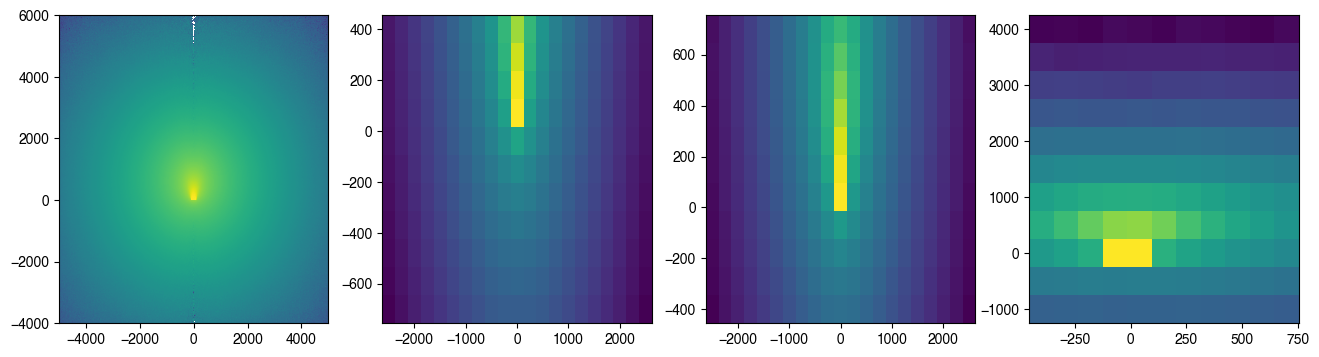

In [30]:
# downsample optic fields
opticField_ds = EcF.prepareDataforInterp(
    data=opticField, method='ninterp', sorted=False)

rpos = opticField_ds[0]
zpos = opticField_ds[1]
IrrField = opticField_ds[2]  # IrrField is 'ij'

rpos = np.concatenate((-rpos[-1:0:-1], rpos))
IrrField = np.vstack((IrrField[-1:0:-1, :], IrrField))
rR, zZ = np.meshgrid(rpos, zpos, indexing='ij')

zpos_ds_pos = np.arange(-400, 810, 110)
rpos_ds_pos = np.arange(-2500, 2750, 250)
rR_ds_pos, zZ_ds_pos = np.meshgrid(rpos_ds_pos, zpos_ds_pos)
IrrField_ds_radial_pos = interpn(
    (rpos, zpos), IrrField, (rR_ds_pos.ravel(), zZ_ds_pos.ravel()))
IrrField_ds_radial_pos = np.reshape(IrrField_ds_radial_pos, (11, 21))

zpos_ds_neg = np.arange(-700, 510, 110)
rs_ds_neg = np.arange(-2500, 2750, 250)
rR_ds_neg, zZ_ds_neg = np.meshgrid(rs_ds_neg, zpos_ds_neg)
IrrField_ds_radial_neg = interpn(
    (rpos, zpos), IrrField, (rR_ds_neg.ravel(), zZ_ds_neg.ravel()))
IrrField_ds_radial_neg = np.reshape(IrrField_ds_radial_neg, (11, 21))

rs_ds_0 = np.arange(-400, 810, 110)
zpos_ds_0 = np.arange(-1000, 4500, 500)
rR_ds_0, zZ_ds_0 = np.meshgrid(rs_ds_0, zpos_ds_0)
IrrField_ds_0 = interpn((rpos, zpos), IrrField,
                        (rR_ds_0.ravel(), zZ_ds_0.ravel()))
IrrField_ds_0 = np.reshape(IrrField_ds_0, (11, 11))

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
axs[0].pcolormesh(rR, zZ, np.log10(IrrField))
axs[1].pcolormesh(rR_ds_neg, zZ_ds_neg, np.log10(IrrField_ds_radial_neg))
axs[2].pcolormesh(rR_ds_pos, zZ_ds_pos, np.log10(IrrField_ds_radial_pos))
axs[3].pcolormesh(rR_ds_0, zZ_ds_0, np.log10(IrrField_ds_0))

opticField_ds_radial_neg = np.array(
    [rR_ds_neg.ravel(), zZ_ds_neg.ravel(), IrrField_ds_radial_neg.ravel()]).T
opticField_ds_radial_pos = np.array(
    [rR_ds_pos.ravel(), zZ_ds_pos.ravel(), IrrField_ds_radial_pos.ravel()]).T
opticField_ds_0 = np.array(
    [rR_ds_0.ravel(), zZ_ds_0.ravel(), IrrField_ds_0.ravel()]).T

In [31]:
# load effective vta surfaces
filepath_vta = './Results\SDC\SDC_singlePulse_Ugent470_gray_invivo_multicell'
vta_filename = 'vta_logspace(-1,3,9)3.csv'
vta_df = pd.read_csv(os.path.join(filepath_vta, vta_filename), index_col=0)
vta_df_original = vta_df.copy()
vta_df.head()
for x in ['Gmax', 'dur', 'level', 'theta_0']:
    vta_df[x] = np.round(vta_df[x], 4)

for x in ['vta_low', 'vta_up', 'surf_low', 'surf_up', 'dur', 'Gmax', 'level']:
    vta_df[x+'_log10'] = np.round(np.log10(vta_df[x]), 4)
vta_df['neurontemplate'].unique()

vta_df['neurontemplate'] = vta_df['neurontemplate'].replace(
    {'CA1_PC_cAC_sig5': 'pyr_1', 'CA1_PC_cAC_sig6': 'pyr_2', 'cNACnoljp1': 'bc_1', 'cNACnoljp2': 'bc_2'})
vta_df[['celltype', 'number']] = vta_df['neurontemplate'].str.split(
    '_', expand=True)
vta_columns = vta_df.columns


unique_values_columns_vta = {key: vta_df[key].unique() for key in vta_columns}
for x in ['vta_low', 'vta_up', 'surf_low', 'surf_up', 'dur', 'Gmax', 'level']:
    unique_values_columns_vta[x] = np.sort(unique_values_columns_vta[x])
    unique_values_columns_vta[x +
                              '_log10'] = np.sort(unique_values_columns_vta[x+'_log10'])

c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\rschoete\miniconda\envs\Optogx_analysis\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [32]:
estim_surfaces_interp = []
a = np.full((len(vta_df)), np.nan)
vta_df['surf_estim'] = a
vta_df['surf_estim_corr'] = a
vta_df['surf_estim_hr'] = a
dr_of = np.diff(np.unique(opticField[:, 0])[:2])/1000  # /1000 um->mm
dz_of = np.diff(np.unique(opticField[:, 1])[:2])/1000  # /1000 um->mm
for i in range(len(vta_df)):
    if i % 3000 == 0:
        print(i)
    pitch = vta_df['theta_0'].iloc[i]
    intensity = vta_df['level'].iloc[i]
    Gmax = vta_df['Gmax'].iloc[i]
    dur = vta_df['dur'].iloc[i]
    nt = vta_df['neurontemplate'].iloc[i]
    ol = vta_df['opsinlocations'].iloc[i]
    nt_ol = nt+ol
    # interp method
    model = mymodels[nt_ol]['model_interp']
    target_amp = master_df['amp'][selection_generator(
        master_df, unique_values_columns_master, Gmax=Gmax, dur=dur, neurontemplate=nt, opsinlocations=ol)].to_numpy()[0]

    if pitch < 0:
        dr = 0.250
        dz = 0.110

        # downsampled field (same stepsizes as gridsearch of surf_avg)
        myfield = intensity*opticField_ds_radial_neg[:, -1]
        above_target = myfield >= target_amp
        estim_surf = np.sum(above_target.ravel()*dr*dz)
        missing_ds = np.round((vta_df['surf_avg'].iloc[i]-estim_surf)/(dr*dz))
        n_pointswithin1perc = sum(abs(myfield-target_amp)/target_amp <= 0.01)
        estim_surf_corr = estim_surf + \
            (int(missing_ds > 0)-int(missing_ds < 0))*n_pointswithin1perc*dr*dz

        # high res field
        idx_field = (opticField[:, 1] >= -700) & (opticField[:, 1]
                                                  <= 400) & (opticField[:, 0] <= 2500)
        myfield = intensity*opticField[idx_field, -1]
        above_target = myfield >= target_amp
        estim_surf_hr = 2*np.sum(above_target.ravel()*dr_of*dz_of)
    elif pitch > 0:
        dr = 0.250
        dz = 0.110

        # downsampled field (same stepsizes as gridsearch of surf_avg)
        myfield = intensity*opticField_ds_radial_pos[:, -1]
        above_target = myfield >= target_amp
        estim_surf = np.sum(above_target.ravel()*dr*dz)
        missing_ds = np.round((vta_df['surf_avg'].iloc[i]-estim_surf)/(dr*dz))
        n_pointswithin1perc = sum(abs(myfield-target_amp)/target_amp <= 0.01)
        estim_surf_corr = estim_surf + \
            (int(missing_ds > 0)-int(missing_ds < 0))*n_pointswithin1perc*dr*dz

        # high res field
        idx_field = (opticField[:, 1] >= -400) & (opticField[:, 1]
                                                  <= 700) & (opticField[:, 0] <= 2500)
        myfield = intensity*opticField[idx_field, -1]
        above_target = myfield >= target_amp
        estim_surf_hr = 2*np.sum(above_target.ravel()*dr_of*dz_of)
    else:
        dr = 0.110
        dz = 0.500

        # downsampled field (same stepsizes as gridsearch of surf_avg)
        myfield = intensity*opticField_ds_0[:, -1]
        above_target = myfield >= target_amp
        estim_surf = np.sum(above_target.ravel()*dr*dz)
        missing_ds = np.round((vta_df['surf_avg'].iloc[i]-estim_surf)/(dr*dz))
        n_pointswithin1perc = sum(abs(myfield-target_amp)/target_amp <= 0.01)
        estim_surf_corr = estim_surf + \
            (int(missing_ds > 0)-int(missing_ds < 0))*n_pointswithin1perc*dr*dz

        # high res field
        idx_field = (opticField[:, 1] >= -1000) & (opticField[:, 1]
                                                   <= 5000) & (opticField[:, 0] <= 700)
        field = opticField[idx_field, -1]
        idx_field = (opticField[:, 1] >= -1000) & (opticField[:, 1]
                                                   <= 5000) & (opticField[:, 0] <= 400)
        field = np.concatenate((field, opticField[idx_field, -1]))
        myfield = intensity*field
        above_target = myfield >= target_amp
        estim_surf_hr = np.sum(above_target.ravel()*dr_of*dz_of)
    vta_df['surf_estim'].iloc[i] = estim_surf
    vta_df['surf_estim_corr'].iloc[i] = estim_surf_corr
    vta_df['surf_estim_hr'].iloc[i] = estim_surf_hr

0


C:\Users\rschoete\AppData\Local\Temp\ipykernel_6684\3807690073.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vta_df['surf_estim'].iloc[i] = estim_surf
C:\Users\rschoete\AppData\Local\Temp\ipykernel_6684\3807690073.py:85: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vta_df['surf_estim_corr'].iloc[i] = estim_surf_corr
C:\Users\rschoete\AppData\Local\Temp\ipykernel_6684\3807690073.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

3000
6000
9000
12000
15000


In [33]:
# Save
# vta_df.to_csv(os.path.join(filepath_vta, 'vta_logspace(-1,3,9)3_westim4.csv'))

(0.9999860921949659, 0.0)
(0.9971619758938706, 0.0)


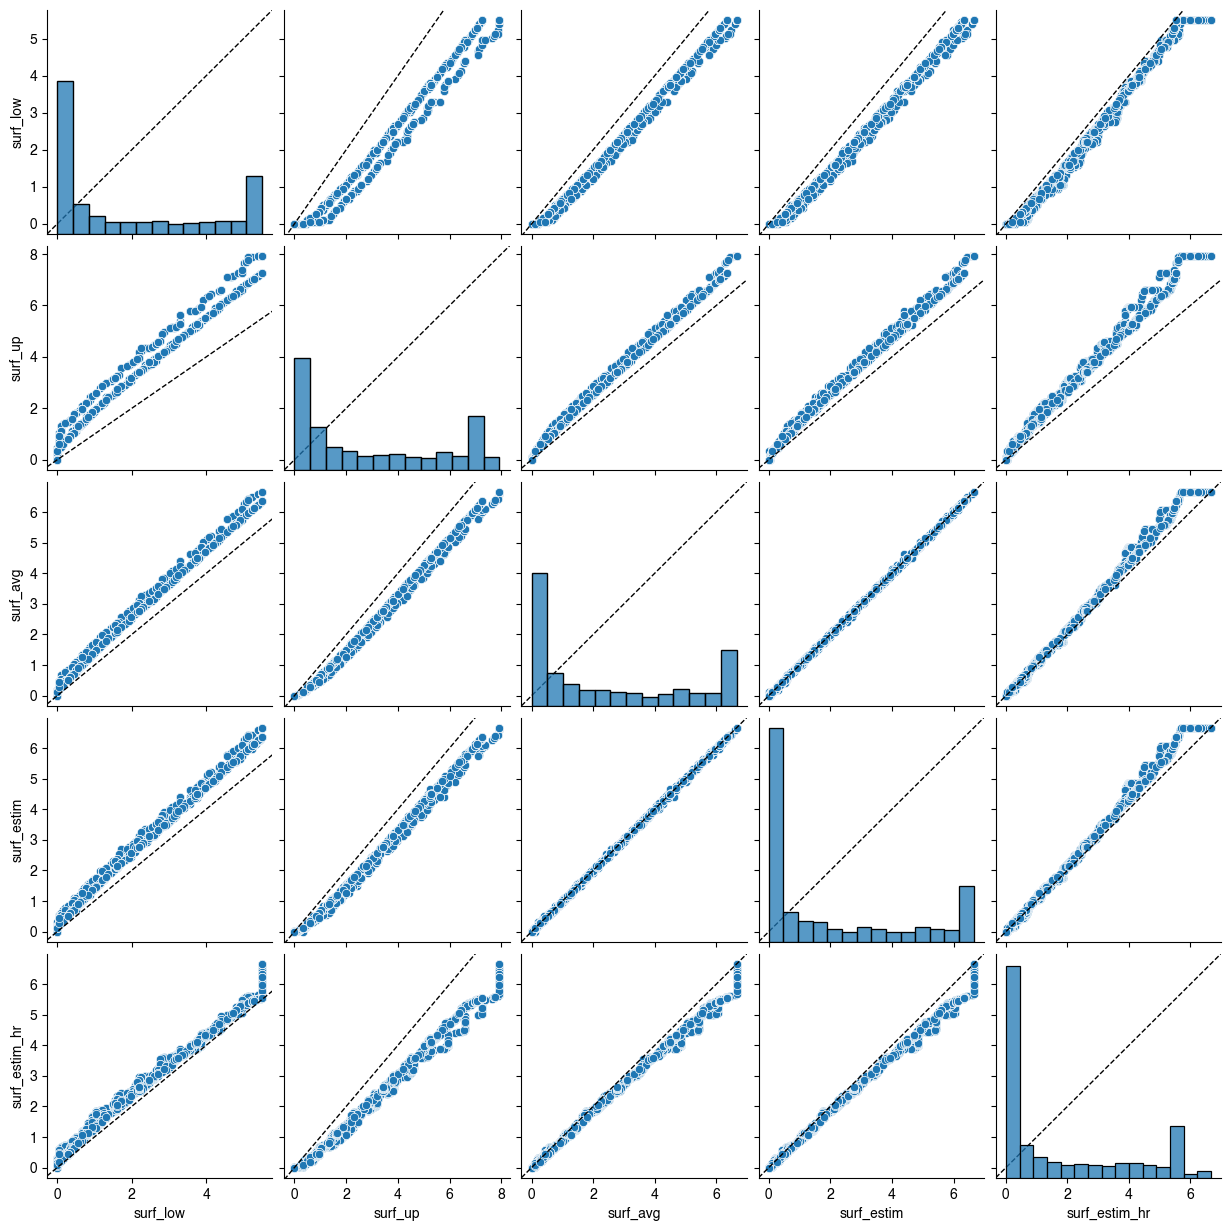

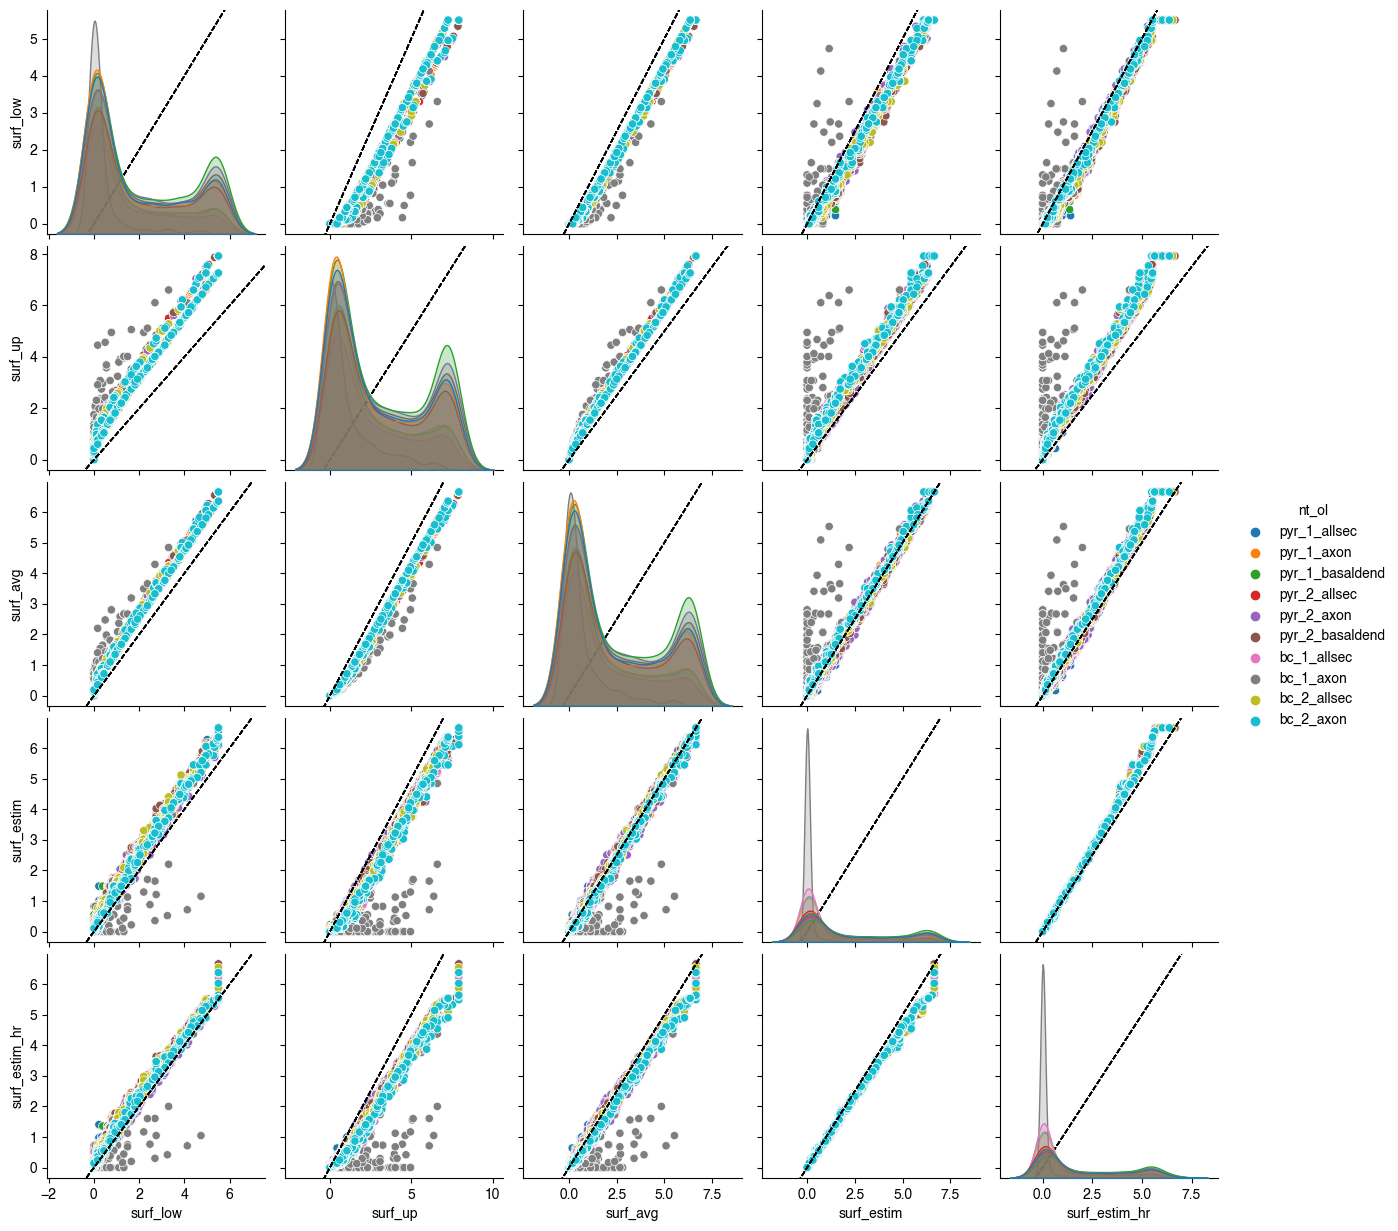

In [34]:
vta_df['nt_ol'] = vta_df.apply(
    lambda row: f"{row['neurontemplate']}_{row['opsinlocations']}", axis=1)
idx = (vta_df['opsinlocations'] == 'soma')
g = sns.pairplot(vta_df[['surf_low', 'surf_up', 'surf_avg', 'surf_estim',
                 'surf_estim_hr', 'opsinlocations', 'neurontemplate']][idx])

g.map(draw_first_diagonal)
x = vta_df.loc[idx, 'surf_avg'].to_numpy()
y = vta_df.loc[idx, 'surf_estim'].to_numpy()
idx = ~ (np.isnan(x) | np.isinf(x) | np.isnan(y) | np.isinf(y))
print(stats.pearsonr(x[idx], y[idx]))

idx = vta_df['opsinlocations'] != 'soma'
g = sns.pairplot(vta_df[['surf_low', 'surf_up', 'surf_avg',
                 'surf_estim', 'surf_estim_hr', 'nt_ol']][idx], hue='nt_ol')


g.map(draw_first_diagonal)
x = vta_df['surf_avg'].to_numpy()
y = vta_df['surf_estim'].to_numpy()
idx = ~ (np.isnan(x) | np.isinf(x) | np.isnan(y) | np.isinf(y))
print(stats.pearsonr(x[idx], y[idx]))

# Impedance

In [35]:
from Model import Cells
from neuron import h
try:
    h.nrn_load_dll("./Model/Mods/nrnmech.dll")
    print("succes load nrnmech.dll")
except Exception as e:
    print(e)
    print("FAIL load nrnmech.dll")

neurontemplate = Cells.NeuronTemplates[0]
print(f'Loading cell: {neurontemplate}')
cell = getattr(Cells, neurontemplate)(replace_axon=False)
# cell2 = getattr(Cells, NeuronTemplates[1])(replace_axon=False)
print(f'\t* celltype: {cell.celltype}\n\t* morphology: {cell.morphology}')

# cell.insertOptogenetics(cell.alldend)
cell.rotate_Cell(theta=-np.pi/2)
# cell2.rotate_Cell(theta=-np.pi/2)
# cell2.move_Cell([0, 100, 0])

succes load nrnmech.dll
Loading cell: CA1_PC_cAC_sig5
not replacing axon
	* celltype: SP_PC
	* morphology: mpg141208_B_idA


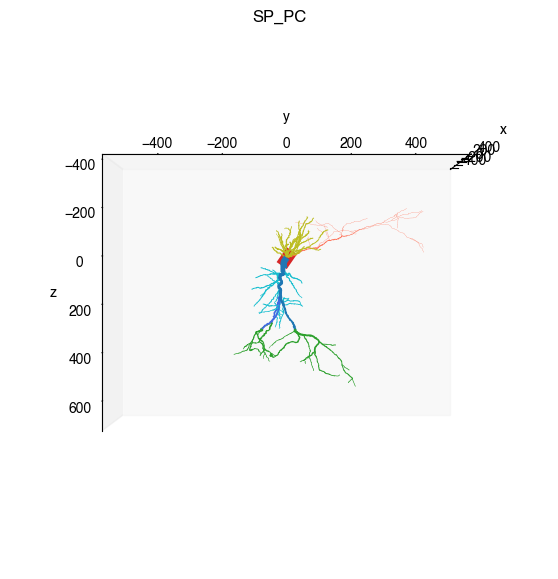

In [36]:

# section Plot
fig = plt.figure(figsize=(7, 7))
ax = plt.subplot(111, projection='3d')
ax = cell.sec_plot(ax)
# ax = cell2.sec_plot(ax)
ax.set_title(cell.celltype)
ax.set_zlim([-400, 700])
ax.set_xlim([-500, 500])
ax.set_ylim([-550, 550])
ax.invert_zaxis()
ax.view_init(elev=0, azim=0)
ax.get_legend().remove()

In [37]:
import Functions.globalFunctions.morphology_v2 as mphv2
%matplotlib inline

In [38]:
imp_df_dict = {}
for k, v in {'pyr_1': 'CA1_PC_cAC_sig5', 'pyr_2': 'CA1_PC_cAC_sig6', 'bc_1': 'cNACnoljp1', 'bc_2': 'cNACnoljp2'}.items():
    imp_df_dict[k] = pd.read_csv(f'./Results/impedance_{v}.csv', index_col=0)
    groups = imp_df_dict[k]['seg'].str.split('[', 1, expand=True)
    imp_df_dict[k]['group'] = groups[0]
    imp_df_dict[k]['cell'] = k
    if k in ['pyr_1', 'pyr_2']:
        imp_df_dict[k]['group'] = imp_df_dict[k]['group'].replace(
            {'dend': 'basal'})

labels = np.array(['soma', 'apic', 'basal', 'axon'])
imp_df_dict[k]

imp    f  v0  durinit neurontemplate             seg group  cell
0       49.116835    0 -70      100     cNACnoljp2    soma[0](0.5)  soma  bc_2
1       50.418803    1 -70      100     cNACnoljp2    soma[0](0.5)  soma  bc_2
2       65.696476   10 -70      100     cNACnoljp2    soma[0](0.5)  soma  bc_2
3       20.732937  100 -70      100     cNACnoljp2    soma[0](0.5)  soma  bc_2
4       49.181793    0 -70      100     cNACnoljp2    axon[0](0.5)  axon  bc_2
...           ...  ...  ..      ...            ...             ...   ...   ...
6903   651.068554  100 -70      100     cNACnoljp2  dend[133](0.5)  dend  bc_2
6904  1126.078498    0 -70      100     cNACnoljp2  dend[134](0.5)  dend  bc_2
6905  1128.774359    1 -70      100     cNACnoljp2  dend[134](0.5)  dend  bc_2
6906  1164.900581   10 -70      100     cNACnoljp2  dend[134](0.5)  dend  bc_2
6907  1020.861130  100 -70      100     cNACnoljp2  dend[134](0.5)  dend  bc_2

[6908 rows x 8 columns]

In [39]:
imp_df = pd.concat(imp_df_dict.values())
print(imp_df.describe())
imp_df['imp_log10'] = np.log10(imp_df['imp'])

                imp             f       v0  durinit
count  27680.000000  27680.000000  27680.0  27680.0
mean    1511.003797     27.750000    -70.0    100.0
std     2682.116703     41.895715      0.0      0.0
min       13.755867      0.000000    -70.0    100.0
25%      357.057018      0.750000    -70.0    100.0
50%      618.455198      5.500000    -70.0    100.0
75%     1203.390217     32.500000    -70.0    100.0
max    28086.434481    100.000000    -70.0    100.0


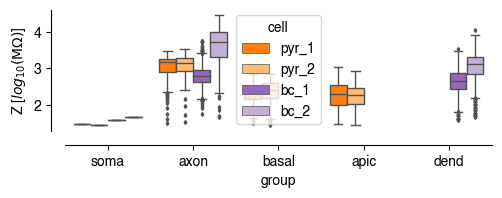

In [40]:
fig, ax = plt.subplots(1, 1, figsize=(14/2.54, 4/2.54))

sns.boxplot(imp_df[imp_df['f'] == 0], x='group', y='imp_log10', hue='cell', ax=ax,
            palette=colorkeyval, dodge=True, fliersize=2, linewidth=1, saturation=1)
ax.set_ylabel('Z [$log_{10}(\mathrm{M}\Omega)$]')
sns.despine(offset=10, ax=ax)
fig.savefig('impedance.svg')

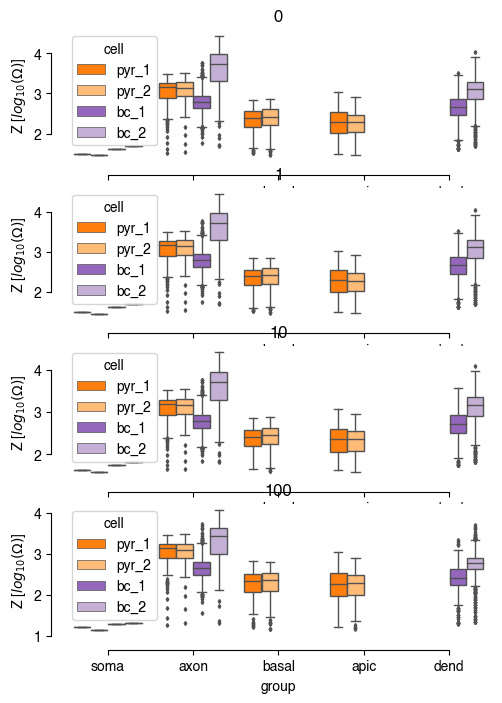

In [41]:
fs = imp_df['f'].unique()
fig, axs = plt.subplots(len(fs), 1, figsize=(14/2.54, 5*4/2.54))


for f, ax in zip(fs, axs):
    sns.boxplot(imp_df[imp_df['f'] == f], x='group', y='imp_log10', hue='cell', ax=ax,
                palette=colorkeyval, dodge=True, fliersize=2, linewidth=1, saturation=1)
    ax.set_ylabel('Z [$log_{10}(\Omega)$]')
    ax.set_title(f)
    sns.despine(offset=10, trim=True, ax=ax)

0.25769506068233955
0.5153901213646791
CA1_PC_cAC_sig5[0].soma[0]


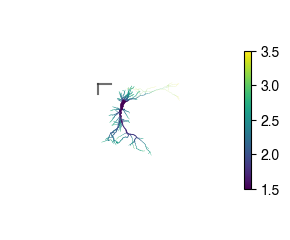

In [42]:
def set_size(w, h, ax=None):
    """ w, h: width, height in inches """
    if not ax:
        ax = plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw/2.54, figh/2.54)


pttocm = 0.0352777778
scale_diams = 4/pttocm/1100*5
scale_diams_list = [scale_diams]*len(cell.allsec)
scale_diams_list[-1] = scale_diams_list[-1]/2
print(scale_diams_list[-1])
print(scale_diams)
print(cell.allsec[0])
fig = plt.figure(figsize=(7/2.54, 7/2.54))
ax = plt.subplot(111, projection='3d')
cvals_seg = imp_df_dict['pyr_1'].loc[imp_df_dict['pyr_1']
                                     ['f'] == 0, ['imp', 'seg']]

cvals = []
for sec in cell.allsec[::-1]:
    for seg in sec:
        seg_str = str(seg).rsplit('].')[-1]
        cvals.append(cvals_seg.loc[cvals_seg['seg']
                     == seg_str, 'imp'].to_numpy()[0])

mphv2.shapeplot(h, ax, sections=cell.allsec[::-1], cvals=cvals, cvals_type=None,
                clim=[10**1.5, 10**3.5], cmap='viridis', cb_flag=True, colorscale='log10', fontSize=12, legend=True, cbax=None, scale_diams=scale_diams_list)
ax.set_zlim([-400, 700])
ax.set_xlim([-550, 550])
ax.set_ylim([-550, 550])
ax.invert_zaxis()
ax.grid(False)
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.w_zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
ax.plot([-200, -200], [-200, -100], zs=0,
        zdir='x', color=[0.2, 0.2, 0.2], alpha=0.7)
ax.plot([-200, -100], [-200, -200], zs=0,
        zdir='x', color=[0.2, 0.2, 0.2], alpha=0.7)
ax.view_init(elev=0, azim=0)
set_size(7, 7, ax)
fig.savefig('cell_imp.svg')

## normalized impadances (Z*A [MOhm m2] [(uS/m2)-1])

In [43]:
# calculate normalized imp [MOhm*um2]
imp_df['normimp'] = np.full(imp_df['imp'].to_numpy().shape, np.nan)
for neurontemplate in [*Cells.NeuronTemplates[0:2], *Cells.NeuronTemplates[4:6]]:
    print(f'Loading cell: {neurontemplate}')
    idx_nt = imp_df['neurontemplate'] == neurontemplate
    cell = getattr(Cells, neurontemplate)(replace_axon=False)
    for sec in cell.allsec:
        for seg in sec:
            seg_str = str(seg).rsplit('].')[-1]
            idx = idx_nt & (imp_df['seg'] == seg_str)
            imp_df.loc[idx, 'nimp_segArea'] = imp_df.loc[idx, 'imp']*seg.area()
imp_df['area'] = imp_df['nimp_segArea']/imp_df['imp']
imp_df['nimp_segArea_log10'] = np.log10(imp_df['nimp_segArea'])

Loading cell: CA1_PC_cAC_sig5
not replacing axon
Loading cell: CA1_PC_cAC_sig6
not replacing axon
Loading cell: cNACnoljp1
not replacing axon
Loading cell: cNACnoljp2
not replacing axon


In [44]:
imp_df['sec'] = imp_df['seg'].str.split('(').str[0]
sec_areas = imp_df[['cell', 'sec', 'area', 'f']
                   ].groupby(['cell', 'sec', 'f']).sum()
sec_areas

area
cell  sec        f              
bc_1  axon[0]    0     37.605008
                 1     37.605008
                 10    37.605008
                 100   37.605008
      axon[1000] 0     76.714800
...                          ...
pyr_2 dend[9]    100   48.584820
      soma[0]    0    417.853498
                 1    417.853498
                 10   417.853498
                 100  417.853498

[10648 rows x 1 columns]

In [45]:

imp_df = pd.merge(imp_df, sec_areas, how='left', on=['cell', 'sec', 'f'])
imp_df = imp_df.rename(columns={'area_x': 'area_seg', 'area_y': 'area_sec'})


imp_df['nimp_secArea'] = imp_df['imp']*imp_df['area_sec']
imp_df['nimp_secArea_log10'] = np.log10(imp_df['nimp_secArea'])

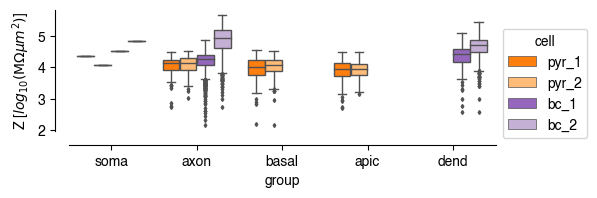

In [46]:

fig, ax = plt.subplots(1, 1, figsize=(14/2.54, 4/2.54))
sns.boxplot(imp_df[imp_df['f'] == 0], x='group', y='nimp_segArea_log10', hue='cell',
            ax=ax, palette=colorkeyval, dodge=True, fliersize=2, linewidth=1, saturation=1)
ax.set_ylabel('Z [$log_{10}(\mathrm{M}\Omega\mu m^2)$]')
sns.despine(offset=10, ax=ax)
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 0.9))

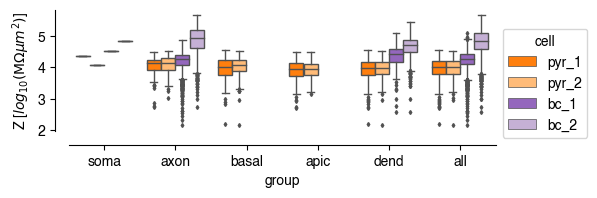

In [47]:
idx_cells = (imp_df['cell'] == 'pyr_1') | (imp_df['cell'] == 'pyr_2')
idx_groups = (imp_df['group'] == 'basal') | (imp_df['group'] == 'apic')
imp_alldend = imp_df.loc[idx_cells & idx_groups].copy()
imp_alldend['group'] = 'dend'


imp_allsec = imp_df.copy()
imp_allsec['group'] = 'all'


imp_ext_df = pd.concat([imp_df, imp_alldend, imp_allsec])


fig, ax = plt.subplots(1, 1, figsize=(14/2.54, 4/2.54))
sns.boxplot(imp_ext_df[imp_ext_df['f'] == 0], x='group', y='nimp_segArea_log10', hue='cell',
            ax=ax, palette=colorkeyval, dodge=True, fliersize=2, linewidth=1, saturation=1)
ax.set_ylabel('Z [$log_{10}(\mathrm{M}\Omega\mu m^2)$]')
sns.despine(offset=10, ax=ax)
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 0.9))

In [48]:
# normalize with opsin location area
imp_ext_df['nimp_segArea_nopsin'] = np.full(
    imp_ext_df['imp'].to_numpy().shape, np.nan)
for loc, v in surfaces.items():
    for cell, area in v.items():
        idx = (imp_ext_df['cell'] == cell) & (imp_ext_df['group'] == loc)
        imp_ext_df.loc[idx, 'nimp_segArea_nopsin'] = imp_ext_df.loc[idx,
                                                                    'nimp_segArea']/area
        imp_ext_df.loc[idx, 'nimp_secArea_nopsin'] = imp_ext_df.loc[idx,
                                                                    'nimp_secArea']/area
        imp_ext_df.loc[idx, 'imp_nopsin'] = imp_ext_df.loc[idx, 'imp']/area


imp_ext_df['nimp_segArea_nopsin_log10'] = np.log10(
    imp_ext_df['nimp_segArea_nopsin'])
imp_ext_df['nimp_secArea_nopsin_log10'] = np.log10(
    imp_ext_df['nimp_secArea_nopsin'])
imp_ext_df['imp_nopsin_log10'] = np.log10(imp_ext_df['imp_nopsin'])

Text(0.5, 1.0, 'nimp_segment_Area_nopsin_log10')

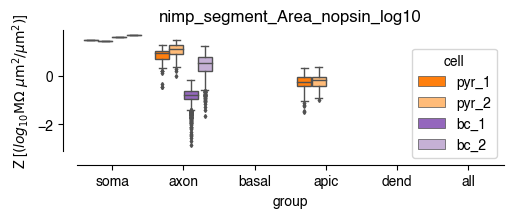

In [49]:

fig, ax = plt.subplots(1, 1, figsize=(14/2.54, 4/2.54))
sns.boxplot(imp_ext_df[imp_ext_df['f'] == 0], x='group', y='nimp_segArea_nopsin_log10',
            hue='cell', ax=ax, palette=colorkeyval, dodge=True, fliersize=2, linewidth=1, saturation=1)
ax.set_ylabel(
    'Z [$(log_{10}\mathrm{M}\Omega\ \mu\mathrm{m}^2/\mu\mathrm{m}^2)$]')
sns.despine(offset=10, ax=ax)
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 0.9))
ax.set_title('nimp_segment_Area_nopsin_log10')

Text(0.5, 1.0, 'nimp_section_Area_nopsin_log10')

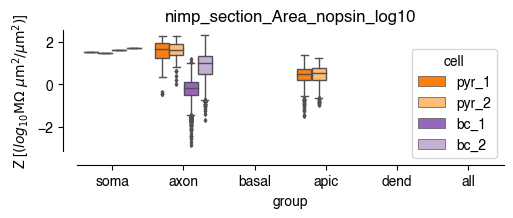

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(14/2.54, 4/2.54))
sns.boxplot(imp_ext_df[imp_ext_df['f'] == 0], x='group', y='nimp_secArea_nopsin_log10',
            hue='cell', ax=ax, palette=colorkeyval, dodge=True, fliersize=2, linewidth=1, saturation=1)
ax.set_ylabel(
    'Z [$(log_{10}\mathrm{M}\Omega\ \mu\mathrm{m}^2/\mu\mathrm{m}^2)$]')
sns.despine(offset=10, ax=ax)
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 0.9))
ax.set_title('nimp_section_Area_nopsin_log10')

Text(0.5, 1.0, 'imp_nopsin_log10')

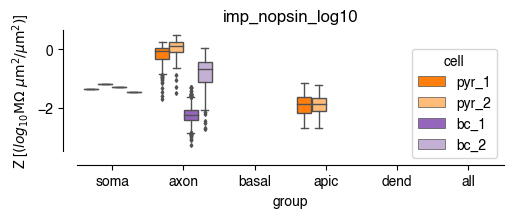

In [51]:
fig, ax = plt.subplots(1, 1, figsize=(14/2.54, 4/2.54))
sns.boxplot(imp_ext_df[imp_ext_df['f'] == 0], x='group', y='imp_nopsin_log10', hue='cell',
            ax=ax, palette=colorkeyval, dodge=True, fliersize=2, linewidth=1, saturation=1)
ax.set_ylabel(
    'Z [$(log_{10}\mathrm{M}\Omega\ \mu\mathrm{m}^2/\mu\mathrm{m}^2)$]')
sns.despine(offset=10, ax=ax)
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 0.9))
ax.set_title('imp_nopsin_log10')

Text(0.5, 1.0, 'imp_log10')

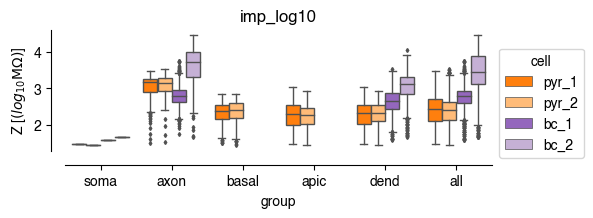

In [52]:
fig, ax = plt.subplots(1, 1, figsize=(14/2.54, 4/2.54))
sns.boxplot(imp_ext_df[imp_ext_df['f'] == 0], x='group', y='imp_log10', hue='cell',
            ax=ax, palette=colorkeyval, dodge=True, fliersize=2, linewidth=1, saturation=1)
ax.set_ylabel('Z [$(log_{10}\mathrm{M}\Omega)$]')
sns.despine(offset=10, ax=ax)
legend = ax.get_legend()
legend.set_bbox_to_anchor((1, 0.9))
ax.set_title('imp_log10')

# Additional simulation with switch structural morphology of pyr cells

In [53]:
# Load data
filepath = './Results/SDC/SDC_constI_diffMorphoPyr'


# opsinlocations to single word
opsinLocation_map = loader.opsinLocation_map
ext_df = loader.load_data_df(filepath=filepath, filename='all_data.csv', recollect=recollect, result=result, all_columns=all_columns, cell_init_options=cell_init_options,
                             settings_options=settings_options, opsin_options=opsin_options, field_options=field_options, fill_missing_xyzpositions=True, save_recollect=True, savename=None)
ext_df['amp'] = ext_df['amp']/1000  # convert W/m2 -> mW/mm2
ext_df['TAC'] = -ext_df['ichr2']/ext_df['dur'] * \
    1e-5  # convert to uA (ichr2: mA/cm2*um2)
ext_df['Gmax'] = np.round(ext_df['Gmax'], 4)
ext_df['dur'] = np.round(ext_df['dur'], 4)
for x in ['amp', 'Gmax', 'TAC', 'dur']:
    ext_df[x+'_log10'] = np.round(np.log10(ext_df[x]), 4)
ext_df = ext_df.drop(drop_columns, axis=1)
ext_df['neurontemplate'] = ext_df['neurontemplate'].replace(
    {'CA1_PC_cAC_sig5': 'pyr_3', 'CA1_PC_cAC_sig6': 'pyr_4', 'cNACnoljp1': 'bc_1', 'cNACnoljp2': 'bc_2'})
if 'morphology' in ext_df.columns:
    ext_df['morphology'] = ext_df['morphology'].replace({np.nan: 'default'})
print('!!!!!!!!!!!!!!excluding Gmax <0.1!!!!!!!')
ext_df = ext_df[ext_df['Gmax'] >= 0.099]

all_columns_ext = ext_df.columns
all_settings_columns_ext = [x for x in all_columns_ext if (
    not x in drop_columns) and (not any([y in x for y in result[:-1]+['TAC']]))]
unique_values_columns_ext = {
    key: ext_df[key].unique() for key in all_columns_ext}
for x in ['amp', 'Gmax', 'TAC', 'dur']:
    unique_values_columns_ext[x] = np.sort(unique_values_columns_ext[x])
    unique_values_columns_ext[x +
                              '_log10'] = np.sort(unique_values_columns_ext[x+'_log10'])

print('all coluumn names:\n\t', all_columns_ext.to_numpy())
print('all settings:\n\t', all_settings_columns_ext)
print('Total number of entries:\n\t', len(ext_df))
for k in all_settings_columns_ext:
    print(f'unique entries {k}:\n\t', len(
        unique_values_columns_ext[k]), ': ', unique_values_columns_ext[k])
    if 'Gmax' in k:
        print('2 sets: ', np.unique(ext_df.loc[ext_df['opsinlocations'] == 'soma', 'Gmax']), '\n ', np.unique(
            ext_df.loc[ext_df['opsinlocations'] == 'allsec', 'Gmax']))

ext_df.describe()

!!!!!!!!!!!!!!excluding Gmax <0.1!!!!!!!
all coluumn names:
	 ['amp' 'sR' 'ichr2' 'gchr2' 'dur' 'nPulse' 'Gmax' 'opsinlocations'
 'neurontemplate' 'morphology' 'TAC' 'amp_log10' 'Gmax_log10' 'TAC_log10'
 'dur_log10']
all settings:
	 ['dur', 'nPulse', 'Gmax', 'opsinlocations', 'neurontemplate', 'morphology', 'Gmax_log10', 'dur_log10']
Total number of entries:
	 1728
unique entries dur:
	 9 :  [1.000000e-01 3.162000e-01 1.000000e+00 3.162300e+00 1.000000e+01
 3.162280e+01 1.000000e+02 3.162278e+02 1.000000e+03]
unique entries nPulse:
	 1 :  [1]
unique entries Gmax:
	 17 :  [  0.1      0.2154   0.2276   0.4642   0.5179   1.       1.1788   2.1544
   2.6827   4.6416   6.1054  10.      13.895   21.5443  31.6228  46.4159
 100.    ]
2 sets:  [ 0.1     0.2154  0.2276  0.4642  0.5179  1.      1.1788  2.1544  2.6827
  4.6416  6.1054 10.     13.895  31.6228] 
  [  0.1      0.2154   0.2276   0.4642   0.5179   1.       1.1788   2.1544
   2.6827   4.6416   6.1054  10.      13.895   21.5443  31.6228  

amp      sR         ichr2        gchr2          dur  nPulse  \
count  1527.000000  1527.0   1728.000000  1728.000000  1728.000000  1728.0   
mean      2.078246     1.0  -5931.827740     2.504258   162.492122     1.0   
std      25.227535     0.0  11688.446868     7.045685   311.623652     0.0   
min       0.000034     1.0 -81099.901100   -59.129900     0.100000     1.0   
25%       0.004366     1.0  -4273.479925     0.213900     1.000000     1.0   
50%       0.034629     1.0  -1600.163800     0.499400    10.000000     1.0   
75%       0.284079     1.0   -912.653725     1.764800   100.000000     1.0   
max     831.250000     1.0    -79.121300    79.161400  1000.000000     1.0   

              Gmax          TAC    amp_log10   Gmax_log10    TAC_log10  \
count  1728.000000  1728.000000  1527.000000  1728.000000  1728.000000   
mean     11.673704     0.017957    -1.461558     0.395827    -2.667053   
std      21.798942     0.039477     1.239762     0.835607     0.931823   
min       0.100000     0.000043    -4.472000    -1.000000    -4.363200   
25%       0.504475     0.000392    -2.359900    -0.297675    -3.406975   
50%       2.418550     0.001059    -1.460600     0.380950    -2.975100   
75%      10.973750     0.013111    -0.546550     1.035725    -1.882400   
max     100.000000     0.238894     2.919700     2.000000    -0.621800   

         dur_log10  
count  1728.000000  
mean      1.000000  
std       1.291368  
min      -1.000000  
25%       0.000000  
50%       1.000000  
75%       2.000000  
max       3.000000

In [54]:
master_df = pd.concat([master_df, ext_df])
all_columns = master_df.columns
all_settings_columns = [x for x in all_columns if (not x in drop_columns) and (
    not any([y in x for y in result[:-1]+['TAC']]))]
unique_values_columns_master = {
    key: master_df[key].unique() for key in all_columns}
for x in ['amp', 'Gmax', 'TAC', 'dur']:
    unique_values_columns_master[x] = np.sort(unique_values_columns_master[x])
    unique_values_columns_master[x+'_log10'] = np.sort(
        unique_values_columns_master[x+'_log10'])

print('all coluumn names:\n\t', all_columns.to_numpy())
print('all settings:\n\t', all_settings_columns)
print('Total number of entries:\n\t', len(master_df))
for k in all_settings_columns:
    print(f'unique entries {k}:\n\t', len(
        unique_values_columns_master[k]), ': ', unique_values_columns_master[k])
    if 'Gmax' in k:
        print('2 sets: ', np.unique(master_df.loc[master_df['opsinlocations'] == 'soma', 'Gmax']), '\n ', np.unique(
            master_df.loc[master_df['opsinlocations'] == 'allsec', 'Gmax']))

master_df.describe()

all coluumn names:
	 ['amp' 'sR' 'ichr2' 'gchr2' 'dur' 'nPulse' 'Gmax' 'opsinlocations'
 'neurontemplate' 'morphology' 'TAC' 'amp_log10' 'Gmax_log10' 'TAC_log10'
 'dur_log10' 'nt_ol' 'TAC_estim' 'TAC_estim_log10' 'nt_ol2'
 'amp_log10ampfdur_log10' 'TACdur_log10']
all settings:
	 ['dur', 'nPulse', 'Gmax', 'opsinlocations', 'neurontemplate', 'morphology', 'Gmax_log10', 'dur_log10', 'nt_ol', 'nt_ol2']
Total number of entries:
	 4572
unique entries dur:
	 9 :  [1.000000e-01 3.162000e-01 1.000000e+00 3.162300e+00 1.000000e+01
 3.162280e+01 1.000000e+02 3.162278e+02 1.000000e+03]
unique entries nPulse:
	 1 :  [1]
unique entries Gmax:
	 17 :  [  0.1      0.2154   0.2276   0.4642   0.5179   1.       1.1788   2.1544
   2.6827   4.6416   6.1054  10.      13.895   21.5443  31.6228  46.4159
 100.    ]
2 sets:  [ 0.1     0.2154  0.2276  0.4642  0.5179  1.      1.1788  2.1544  2.6827
  4.6416  6.1054 10.     13.895  31.6228] 
  [  0.1      0.2154   0.2276   0.4642   0.5179   1.       1.1788   2.1544

amp      sR         ichr2        gchr2          dur  nPulse  \
count  3867.000000  3867.0  4.572000e+03  4572.000000  4572.000000  4572.0   
mean      9.935427     1.0 -9.708453e+03     4.088014   162.492122     1.0   
std     188.934343     0.0  4.611247e+04    25.825319   311.567545     0.0   
min       0.000034     1.0 -1.656716e+06  -822.663900     0.100000     1.0   
25%       0.005205     1.0 -5.867751e+03     0.231200     1.000000     1.0   
50%       0.041047     1.0 -1.675092e+03     0.540450    10.000000     1.0   
75%       0.323980     1.0 -1.000709e+03     2.131550   100.000000     1.0   
max    8523.437500     1.0 -7.907400e+01   779.016900  1000.000000     1.0   

              Gmax          TAC    amp_log10   Gmax_log10    TAC_log10  \
count  4572.000000  4572.000000  3867.000000  4572.000000  4572.000000   
mean     11.324783     0.031022    -1.370487     0.385820    -2.592665   
std      21.324537     0.230462     1.257625     0.830711     0.957293   
min       0.100000     0.000043    -4.473700    -1.000000    -4.367900   
25%       0.464200     0.000416    -2.283550    -0.333300    -3.381275   
50%       2.154400     0.001499    -1.386700     0.333300    -2.824100   
75%      10.000000     0.014375    -0.489500     1.000000    -1.842450   
max     100.000000    12.761321     3.930600     2.000000     1.105900   

         dur_log10    TAC_estim  TAC_estim_log10  amp_log10ampfdur_log10  \
count  4572.000000  2844.000000      2844.000000             2340.000000   
mean      1.000000     0.072976        -2.430724               -2.488960   
std       1.291136     0.430560         1.034168                1.265881   
min      -1.000000     0.000111        -3.953246               -5.651603   
25%       0.000000     0.000408        -3.389438               -3.412303   
50%       1.000000     0.002171        -2.663321               -2.513053   
75%       2.000000     0.031445        -1.502454               -1.620853   
max       3.000000     5.757675         0.760247                2.752697   

       TACdur_log10  
count   2844.000000  
mean      -0.248122  
std        0.398581  
min       -1.516352  
25%       -0.447322  
50%       -0.277635  
75%       -0.123039  
max        1.691510

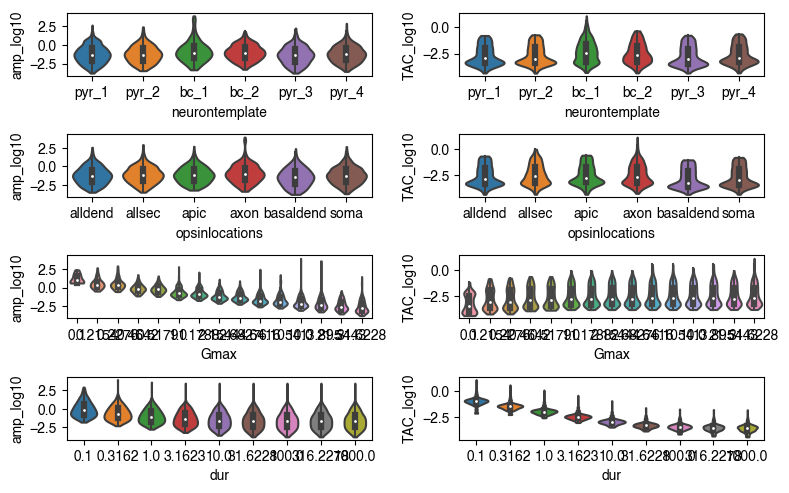

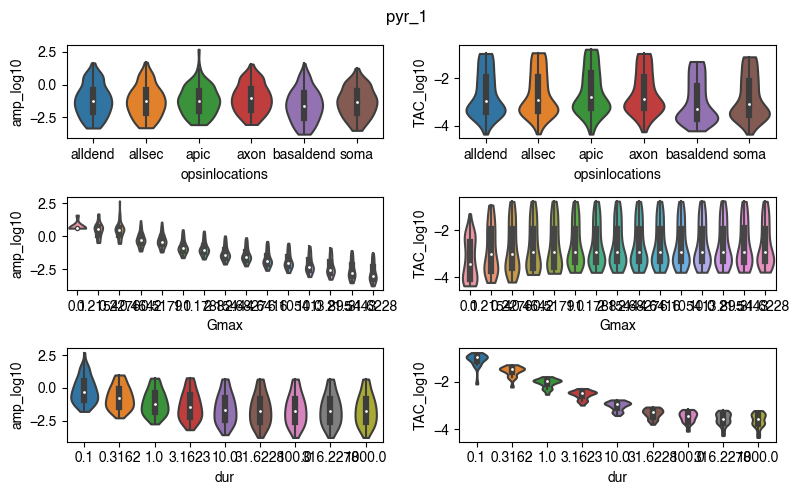

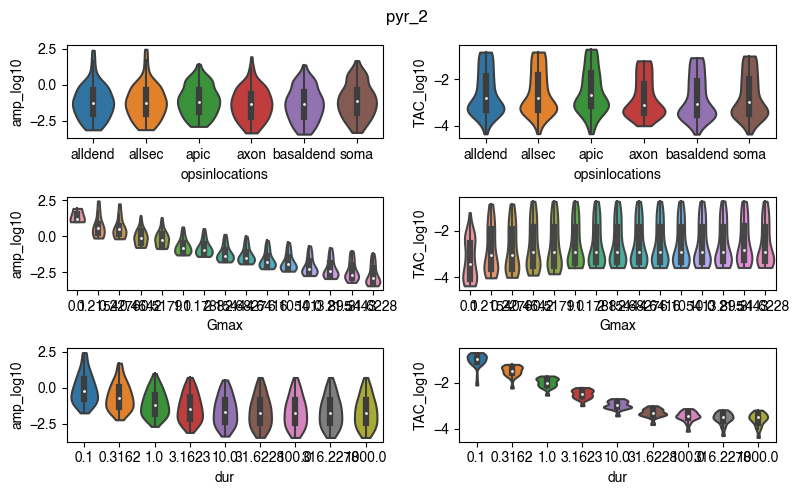

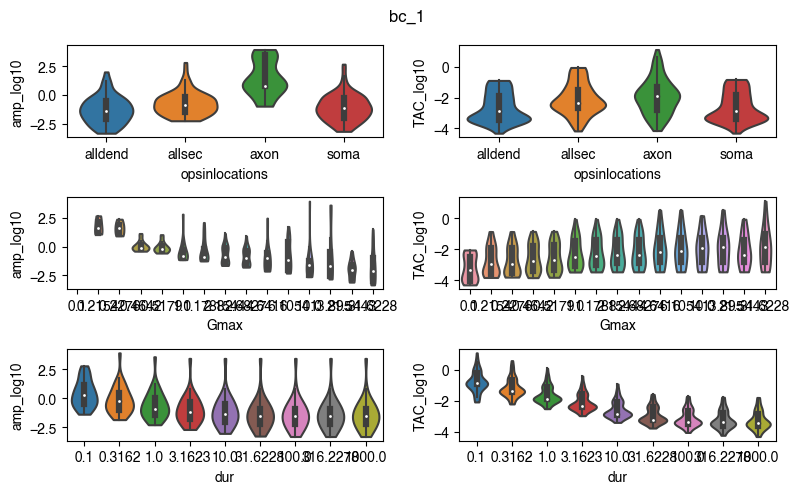

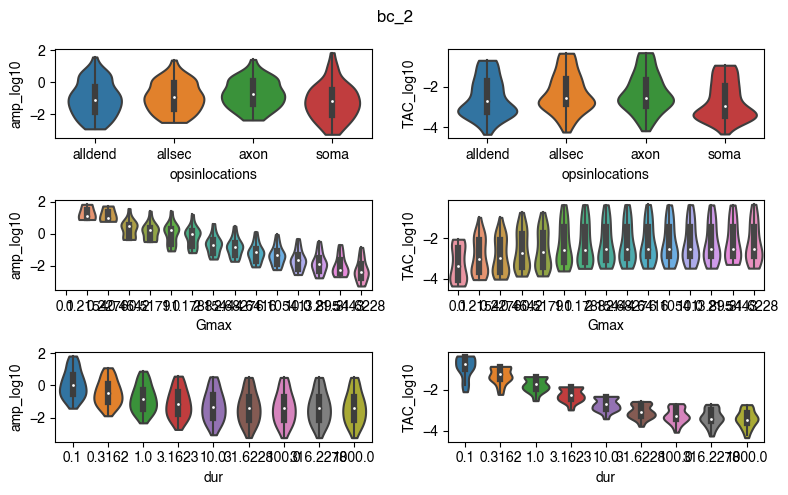

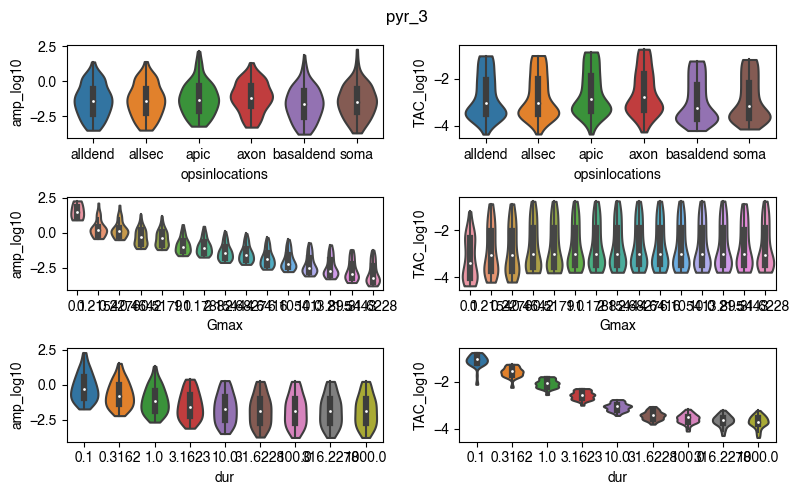

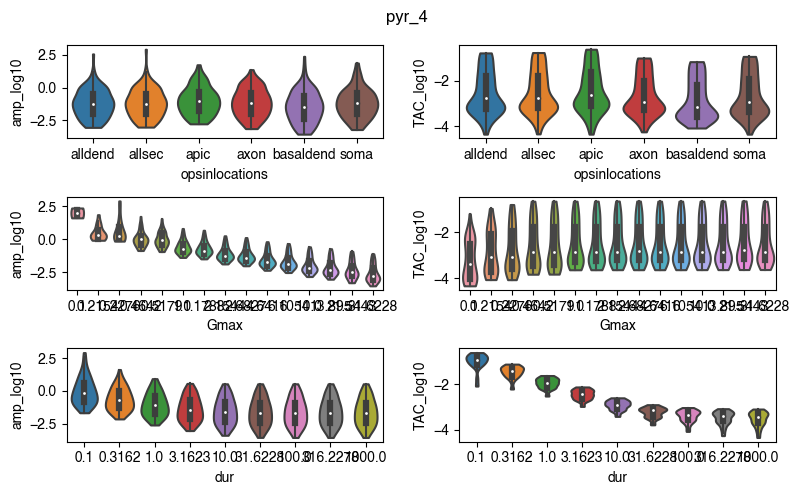

In [55]:
statistics_df = master_df[(master_df['Gmax'] >= 0.099)
                          & (master_df['Gmax'] < 32)]
fig, axs = plt.subplots(4, 2, tight_layout=True, figsize=(8, 5))
for i, pool in enumerate(['neurontemplate', 'opsinlocations', 'Gmax', 'dur']):
    sns.violinplot(data=statistics_df, y='amp_log10',
                   x=pool, ax=axs[i, 0], cut=0)
    sns.violinplot(data=statistics_df, y='TAC_log10',
                   x=pool, ax=axs[i, 1], cut=0)
for nt in unique_values_columns_master['neurontemplate']:
    idx = statistics_df['neurontemplate'] == nt
    fig, axs = plt.subplots(3, 2, tight_layout=True, figsize=(8, 5))
    for i, pool in enumerate(['opsinlocations', 'Gmax', 'dur']):
        sns.violinplot(
            data=statistics_df[idx], y='amp_log10', x=pool, ax=axs[i, 0], cut=0)
        sns.violinplot(
            data=statistics_df[idx], y='TAC_log10', x=pool, ax=axs[i, 1], cut=0)
    fig.suptitle(nt)

## Statistic tests

{'amp_log10': {'all': {'nt_ol2': (nan, nan), 'nt_ol': (nan, nan), 'neurontemplate': (40.75914312794612, 1.0494888355696504e-07), 'opsinlocations': (50.35608942809041, 1.1717054900997893e-09), 'Gmax': (2303.0702109451827, 0.0), 'dur': (732.4207035551397, 7.472538877081554e-153)}}, 'TAC_log10': {'all': {'nt_ol2': (nan, nan), 'nt_ol': (nan, nan), 'neurontemplate': (85.54265067732642, 5.792714688925644e-17), 'opsinlocations': (114.99961122665617, 3.591653806952423e-23), 'Gmax': (214.49609331255692, 5.922741272469089e-38), 'dur': (3554.029910366233, 0.0)}}}


Text(0.5, 1.0, 'Kruskal Wallis')

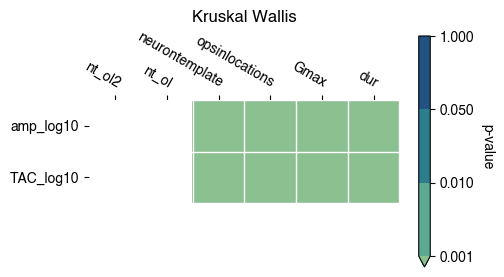

In [56]:
colors = np.array(sns.color_palette("crest", n_colors=10))
colors = colors[[0, 2, 5, 8], :]
cmap = LinearSegmentedColormap.from_list('my_cmap', colors, N=colors.shape[0])
boundaries = [0.001, 0.01, 0.05, 1.0]
boundnorm = mpl.cm.colors.BoundaryNorm(
    boundaries, len(boundaries), extend='min')


KW_dict = {}
features = ['amp_log10', 'TAC_log10']
classes = [x for x in all_settings_columns[::-1]
           if not ('_log10' in x or x == 'nPulse' or x == 'morphology')]
for feat in features:
    KW_dict[feat] = {'all': {}}
    for pool in classes:
        ukeys = statistics_df[pool].unique()
        pooledData = [
            list(statistics_df[feat][statistics_df[pool] == ukey]) for ukey in ukeys]
        KW_dict[feat]['all'][pool] = stats.kruskal(
            *pooledData, nan_policy='omit')[:]
print(KW_dict)

heatmapdata = np.zeros((len(features), len(classes)))
for ifeat, feat in enumerate(features):
    for ipool, pool in enumerate(classes):
        heatmapdata[ifeat, ipool] = KW_dict[feat]['all'][pool][1]

fig, ax = plt.subplots(1, 1, figsize=(5, 3))
heatmap(heatmapdata, features, classes, ax=ax,
        norm=boundnorm, cmap=cmap, cbarlabel='p-value')
ax.set_title('Kruskal Wallis')

Wilcoxon signed Rank test not equal


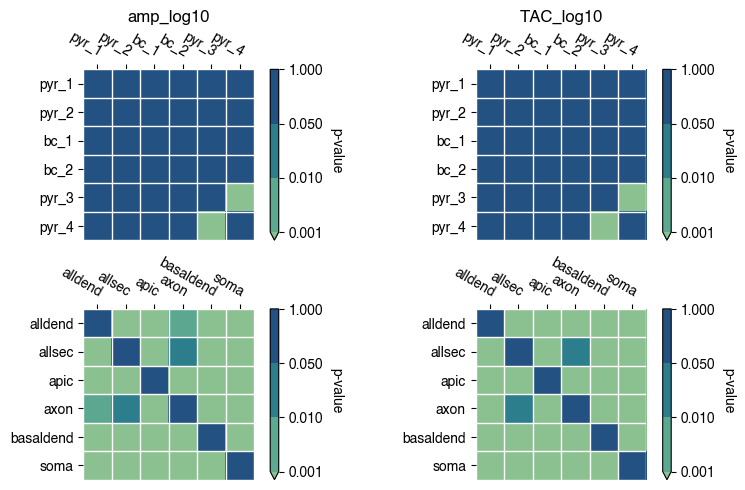

In [57]:
classes_toplot = ['neurontemplate', 'opsinlocations']
MWU_dict = {}
WSRT_dict = {}
for feat in features:
    MWU_dict[feat] = {'all': {}}
    WSRT_dict[feat] = {'all': {}}
    for pool in classes_toplot:
        ukeys = unique_values_columns_master[pool]
        mytest_MWU = np.ones((len(ukeys), len(ukeys), 2))
        mytest_WSRT = np.ones((len(ukeys), len(ukeys), 2))
        for i in range(len(ukeys)):
            for j in range(len(ukeys)):
                x = np.array(statistics_df[feat]
                             [statistics_df[pool] == ukeys[i]])
                x = x[~np.isnan(x)]
                y = np.array(statistics_df[feat]
                             [statistics_df[pool] == ukeys[j]])
                y = y[~np.isnan(y)]
                if len(y) > 0 and len(x) > 0:
                    mytest_MWU[i, j, 0] = stats.mannwhitneyu(x, y)[0]
                    mytest_MWU[i, j, 1] = stats.mannwhitneyu(x, y)[1]

                df1 = statistics_df[statistics_df[pool] == ukeys[i]]
                df2 = statistics_df[statistics_df[pool] == ukeys[j]]
                df1 = df1.set_index(
                    [x for x in classes if not (pool in x or x in pool)])[feat]
                df2 = df2.set_index(
                    [x for x in classes if not (pool in x or x in pool)])[feat]
                diff_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=(
                    '_0', '_1'), validate='one_to_many')
                diff_df = diff_df[feat+'_1']-diff_df[feat+'_0']
                xydiff = np.array(diff_df)
                xydiff = xydiff[~np.isnan(xydiff)]
                if len(xydiff) > 0 and i != j:
                    mytest_WSRT[i, j, 0] = stats.wilcoxon(xydiff)[0]
                    mytest_WSRT[i, j, 1] = stats.wilcoxon(xydiff)[1]
        MWU_dict[feat]['all'][pool] = mytest_MWU
        WSRT_dict[feat]['all'][pool] = mytest_WSRT

print('Wilcoxon signed Rank test not equal')
fig, axs = plt.subplots(len(classes_toplot), 2,
                        tight_layout=True, figsize=(8, 5))
for pool, ax in zip(classes_toplot, axs):
    ukeys = unique_values_columns_master[pool]
    for ifeat, feat in enumerate(features):
        # im,_ = heatmap(MWU_dict[feat]['all'][pool][:,:,1], ukeys, ukeys, ax=ax[ifeat*2], norm=boundnorm,cmap=cmap,cbarlabel='p-value')
        im, _ = heatmap(WSRT_dict[feat]['all'][pool][:, :, 1], ukeys, ukeys,
                        ax=ax[ifeat], norm=boundnorm, cmap=cmap, cbarlabel='p-value')
        if pool == classes_toplot[0]:
            ax[ifeat].set_title(feat)

### Paper plots (similar to plots above)

['pyr_1alldend' 'pyr_1allsec' 'pyr_1apic' 'pyr_1axon' 'pyr_1basaldend'
 'pyr_1soma' 'pyr_2alldend' 'pyr_2allsec' 'pyr_2apic' 'pyr_2axon'
 'pyr_2basaldend' 'pyr_2soma' 'bc_1alldend' 'bc_1allsec' 'bc_1axon'
 'bc_1soma' 'bc_2alldend' 'bc_2allsec' 'bc_2axon' 'bc_2soma'
 'pyr_3alldend' 'pyr_3allsec' 'pyr_3apic' 'pyr_3axon' 'pyr_3basaldend'
 'pyr_3soma' 'pyr_4alldend' 'pyr_4allsec' 'pyr_4apic' 'pyr_4axon'
 'pyr_4basaldend' 'pyr_4soma']
median incremental rel change [%]:
med	 -10.452351842643626 
mean	 -15.324429290321786
mean incremental rel change [%]:
med	 -9.17045782823445 
mean	 -13.449711227124576
min incremental rel change [%]:
med	 1.3316816351811525 
mean	 12.88706813527856
max incremental rel change [%]:
med	 -39.69391077824813 
mean	 -42.86215408595362
median incremental rel change TAC [%]:
med	 -7.2375504954624175 
mean	 -6.669718888081577
mean incremental rel change TAC [%]:
med	 -5.296518356339959 
mean	 -3.9893190232724436
min incremental rel change TAC [%]:
med	 16.23552927297

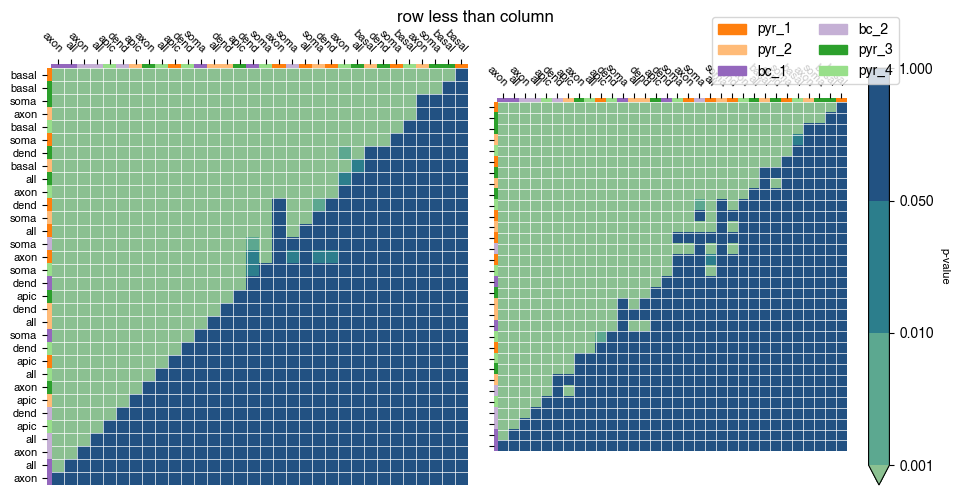

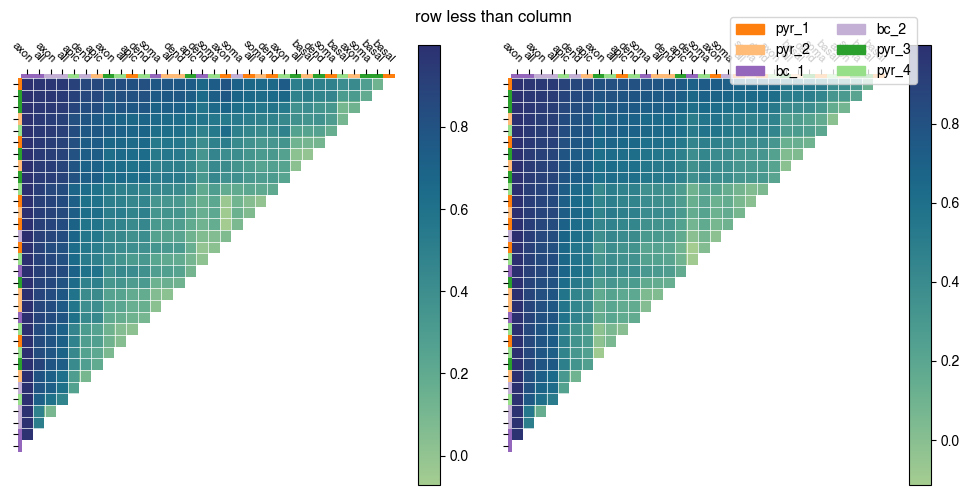

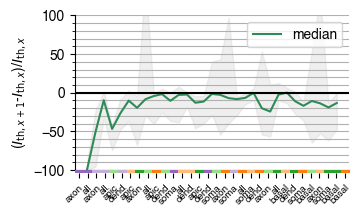

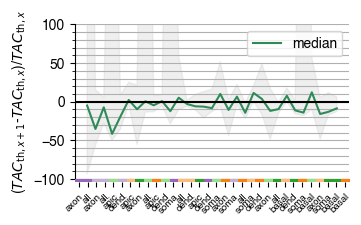

In [58]:
features = ['amp', 'TAC']
classes = ['neurontemplate', 'opsinlocations', 'Gmax', 'dur']
# wsrt_df = statistics_df[features+classes].copy()
wsrt_df = master_df[features+classes].copy()
wsrt_df['wsrt_keys'] = wsrt_df.apply(
    lambda x: f"{x['neurontemplate']}{x['opsinlocations']}", axis=1)
print(wsrt_df['wsrt_keys'].unique())

cvrt_label = {'allsec': 'all', 'alldend': 'dend', 'soma': 'soma',
              'axon': 'axon', 'basaldend': 'basal', 'apic': 'apic'}


WSRT_dict = {}
ukeys = wsrt_df['wsrt_keys'].unique()
for feat in features:
    WSRT_dict[feat] = {}
    mytest_WSRT = np.ones((len(ukeys), len(ukeys), 2))
    for i in range(len(ukeys)):
        for j in range(len(ukeys)):
            df1 = wsrt_df[wsrt_df['wsrt_keys'] == ukeys[i]]
            df2 = wsrt_df[wsrt_df['wsrt_keys'] == ukeys[j]]
            df1 = df1.set_index([x for x in ['Gmax', 'dur']])[feat]
            df2 = df2.set_index([x for x in ['Gmax', 'dur']])[feat]
            diff_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=(
                '_0', '_1'), validate='one_to_many')
            diff_df = diff_df[feat+'_1']-diff_df[feat+'_0']
            xydiff = np.array(diff_df)
            xydiff = xydiff[~(np.isnan(xydiff) | np.isinf(xydiff))]
            if len(xydiff) > 0 and i != j:
                wstats = stats.wilcoxon(xydiff, alternative='greater')
                mytest_WSRT[i, j, 0] = wstats[0]
                mytest_WSRT[i, j, 1] = wstats[1]
    WSRT_dict[feat] = mytest_WSRT


row_colors_dict = {x: colorkeyval[x]
                   for x in wsrt_df['neurontemplate'].unique()}

row_colors_dict

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
for ifeat, (feat, ax) in enumerate(zip(features, axs)):
    greatest = np.sum(WSRT_dict[feat][:, :, 1] < 0.001, axis=1)+0.5*np.sum((WSRT_dict[feat][:, :, 1] < 0.01) & (WSRT_dict[feat][:, :, 1] >= 0.001), axis=1)\
        + 0.1*np.sum((WSRT_dict[feat][:, :, 1] < 0.05)
                     & (WSRT_dict[feat][:, :, 1] >= 0.01), axis=1)
    if ifeat == 0:
        idx_column = np.argsort(greatest)
        idx_row = np.flip(idx_column)
    row_labels = ukeys[idx_row]
    column_labels = ukeys[idx_column]
    row_colors = np.array([i for x in row_labels for k,
                          i in row_colors_dict.items() if k in x])[:, None, :]
    column_colors = np.array(
        [i for x in column_labels for k, i in row_colors_dict.items() if k in x])[None, :, :]
    row_labels = [x.rsplit('_', 1)[1][1:] for x in row_labels]
    column_labels = [x.rsplit('_', 1)[1][1:] for x in column_labels]
    row_labels = [cvrt_label[x] for x in row_labels]
    if ifeat == 1:
        row_labels = ['' for x in row_labels]
    column_labels = [cvrt_label[x] for x in column_labels]

    data_toplot = WSRT_dict[feat][:, idx_column, 1]
    im, cbar = heatmap_colorcode(data_toplot[idx_row, :], row_labels, column_labels, ax=ax, row_colors=row_colors,
                                 column_colors=column_colors, norm=boundnorm_pvalue, cmap=crestcmap_pvalue, cbarlabel='p-value', labelfs=8, lw_grid=0.5)
    if feat == classes[0]:
        ax[ifeat].set_title(feat)
    if ifeat == 0:
        cbar.remove()
fig.suptitle(f'row less than column')
legendpatches = []
for k, v in row_colors_dict.items():
    legendpatches.append(mpl.patches.Patch(color=v, label=k))
fig.legend(handles=legendpatches, bbox_to_anchor=(0.93, 0.98), ncol=2)


ukeys_row = ukeys[idx_row]
ukeys_column = ukeys[idx_column]

quantChange_dict = {}
for feat in features:
    quantChange_dict[feat] = {}
    mytest_qC = np.full((len(ukeys), len(ukeys), 4), np.nan)
    for i, r in enumerate(ukeys_row):
        for j, c in enumerate(ukeys_column):
            if j < (len(ukeys_row)-i):
                df1 = wsrt_df[wsrt_df['wsrt_keys'] == r]
                df2 = wsrt_df[wsrt_df['wsrt_keys'] == c]
                df1 = df1.set_index([x for x in ['Gmax', 'dur']])[feat]
                df2 = df2.set_index([x for x in ['Gmax', 'dur']])[feat]
                diff_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=(
                    '_0', '_1'), validate='one_to_many')
                diff_df = (diff_df[feat+'_1'] -
                           diff_df[feat+'_0'])/diff_df[feat+'_1']
                xydiff = np.array(diff_df)
                xydiff = xydiff[~(np.isnan(xydiff) | np.isinf(xydiff))]
                if len(xydiff) > 0 and r != c:
                    mytest_qC[i, j, 0] = np.median(xydiff)
                    mytest_qC[i, j, 1] = np.mean(xydiff)
                    mytest_qC[i, j, 2] = np.min(xydiff)
                    mytest_qC[i, j, 3] = np.max(xydiff)
    quantChange_dict[feat] = mytest_qC
cmap = sns.color_palette("crest", as_cmap=True)

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
for ifeat, (feat, ax) in enumerate(zip(range(2), axs)):

    data_toplot = quantChange_dict['amp'][:, :, feat]
    im, cbar = heatmap_colorcode(data_toplot, row_labels, column_labels, ax=ax, row_colors=row_colors,
                                 column_colors=column_colors, cmap=cmap, cbarlabel='', labelfs=8, lw_grid=0.5)


fig.suptitle(f'row less than column')
legendpatches = []
for k, v in row_colors_dict.items():
    legendpatches.append(mpl.patches.Patch(color=v, label=k))
fig.legend(handles=legendpatches, bbox_to_anchor=(0.93, 0.98), ncol=2)

# line plot of incremental change
fig, ax = plt.subplots(1, 1, figsize=(9/2.54, 5.1/2.54))
labels = ['median', 'mean'][:1]
clrs = ['seagreen', 'tab:blue']
for i, (l, clr) in enumerate(zip(labels, clrs)):
    data_toplot = quantChange_dict['amp'][:, :, i]
    y = np.fliplr(data_toplot).diagonal(offset=1)
    y = np.flip(np.append([np.nan], y))
    ax.plot(np.arange(len(ukeys_row)), -100*y, label=l, color=clr)

data_toplot = quantChange_dict['amp'][:, :, 3]
y = np.fliplr(data_toplot).diagonal(offset=1)
mymax = np.flip(np.append([np.nan], -100*y))
data_toplot = quantChange_dict['amp'][:, :, 2]
y = np.fliplr(data_toplot).diagonal(offset=1)
mymin = np.flip(np.append([np.nan], -100*y))
ax.fill_between(np.arange(len(ukeys_row)), mymin,
                mymax, alpha=0.3, color=[0.8, 0.8, 0.8])
ax.axhline(0, color='k')

# colored x-axis
ax_column_cols = ax.inset_axes([0, -0.02, 1, 0.02,])
ax_column_cols.spines[:].set_visible(False)
ax_column_cols.imshow(column_colors, aspect='auto')
ax_column_cols.set_xticks(np.arange(len(ukeys_row)),
                          labels=column_labels, fontsize=7)
ax_column_cols.set_xticks(np.arange(len(ukeys_row)+1)-.5, minor=True)
ax_column_cols.set_yticks([])
ax_column_cols.tick_params(which="minor", bottom=False, left=False)
ax.set_xticks([])
# Let the horizontal axes labeling appear on top.
ax_column_cols.tick_params(top=False, bottom=True,
                           labeltop=False, labelbottom=True)
# Rotate the tick labels and set their alignment.
plt.setp(ax_column_cols.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.minorticks_on()
ax.tick_params(axis='y', which='minor')
ax.tick_params(axis='x', which='minor', bottom=False)
ax.grid(visible=True, axis='y')
ax.grid(visible=True, which='minor', axis='y')
ax.legend()
ax.set_ylabel(
    '($I_{\mathrm{th},x+1}$-$I_{\mathrm{th},x}$)/$I_{\mathrm{th},x}$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([-100, 100])
for i, x in enumerate(['median', 'mean', 'min', 'max']):
    data_toplot = quantChange_dict['amp'][:, :, i]
    y = -100*np.flip(np.fliplr(data_toplot).diagonal(offset=1))
    print(f'{x} incremental rel change [%]:\nmed\t', np.median(
        y), '\nmean\t', np.mean(y))
fig.savefig('incrIth4pyr.svg', dpi=300)

# line plot of incremental change TAC
fig, ax = plt.subplots(1, 1, figsize=(9/2.54, 5.1/2.54))
for i, (l, clr) in enumerate(zip(labels, clrs)):
    data_toplot = quantChange_dict['TAC'][:, :, i]
    y = np.fliplr(data_toplot).diagonal(offset=1)
    y = np.flip(np.append([np.nan], y))
    ax.plot(np.arange(len(ukeys_row)), -100*y, label=l, color=clr)

data_toplot = quantChange_dict['TAC'][:, :, 3]
y = np.fliplr(data_toplot).diagonal(offset=1)
mymax = np.flip(np.append([np.nan], -100*y))
data_toplot = quantChange_dict['TAC'][:, :, 2]
y = np.fliplr(data_toplot).diagonal(offset=1)
mymin = np.flip(np.append([np.nan], -100*y))
ax.fill_between(np.arange(len(ukeys_row)), mymin,
                mymax, alpha=0.3, color=[0.8, 0.8, 0.8])
ax.axhline(0, color='k')

# colored x-axis
ax_column_cols = ax.inset_axes([0, -0.02, 1, 0.02,])
ax_column_cols.spines[:].set_visible(False)
ax_column_cols.imshow(column_colors, aspect='auto')
ax_column_cols.set_xticks(np.arange(len(ukeys_row)),
                          labels=column_labels, fontsize=7)
ax_column_cols.set_xticks(np.arange(len(ukeys_row)+1)-.5, minor=True)
ax_column_cols.set_yticks([])
ax_column_cols.tick_params(which="minor", bottom=False, left=False)
ax.set_xticks([])
# Let the horizontal axes labeling appear on top.
ax_column_cols.tick_params(top=False, bottom=True,
                           labeltop=False, labelbottom=True)
# Rotate the tick labels and set their alignment.
plt.setp(ax_column_cols.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.minorticks_on()
ax.tick_params(axis='y', which='minor')
ax.tick_params(axis='x', which='minor', bottom=False)
ax.grid(visible=True, axis='y')
ax.grid(visible=True, which='minor', axis='y')
ax.legend()
ax.set_ylabel(
    '($TAC_{\mathrm{th},x+1}$-$TAC_{\mathrm{th},x}$)/$TAC_{\mathrm{th},x}$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylim([-100, 100])

for i, x in enumerate(['median', 'mean', 'min', 'max']):
    data_toplot = quantChange_dict['TAC'][:, :, i]
    y = -100*np.flip(np.fliplr(data_toplot).diagonal(offset=1))
    print(f'{x} incremental rel change TAC [%]:\nmed\t', np.median(
        y), '\nmean\t', np.mean(y))
fig.savefig('incrTACth4pyr.svg', dpi=300)

### Only pyrs

['pyr_1alldend' 'pyr_1allsec' 'pyr_1apic' 'pyr_1axon' 'pyr_1basaldend'
 'pyr_1soma' 'pyr_2alldend' 'pyr_2allsec' 'pyr_2apic' 'pyr_2axon'
 'pyr_2basaldend' 'pyr_2soma' 'pyr_3alldend' 'pyr_3allsec' 'pyr_3apic'
 'pyr_3axon' 'pyr_3basaldend' 'pyr_3soma' 'pyr_4alldend' 'pyr_4allsec'
 'pyr_4apic' 'pyr_4axon' 'pyr_4basaldend' 'pyr_4soma']
median incremental rel change [%]:
med	 -10.817292307692314 
mean	 -10.374332322425948
mean incremental rel change [%]:
med	 -9.910182285286673 
mean	 -8.30816411717312
min incremental rel change [%]:
med	 1.3316816351811525 
mean	 18.204373399032583
max incremental rel change [%]:
med	 -40.6015037593985 
mean	 -39.81745542606699
median incremental rel change TAC [%]:
med	 -5.933831942380568 
mean	 -4.8000558067991275
mean incremental rel change TAC [%]:
med	 -5.296518356339959 
mean	 -2.719481498665671
min incremental rel change TAC [%]:
med	 16.793970634373153 
mean	 109.31981286700179
max incremental rel change TAC [%]:
med	 -14.509165025855417 
mean	 -18

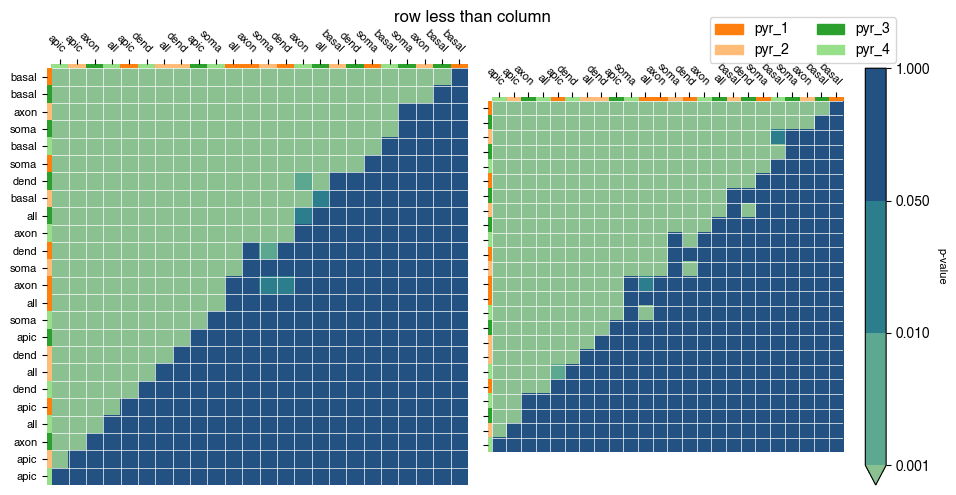

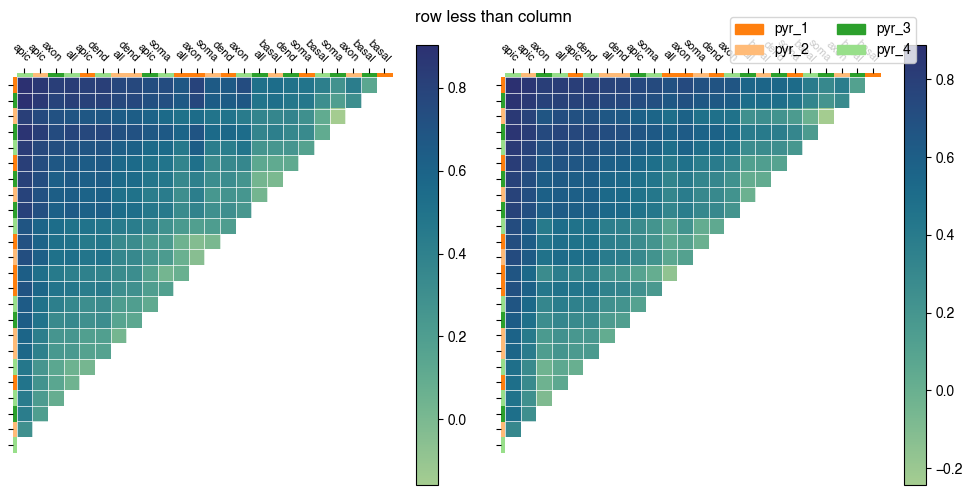

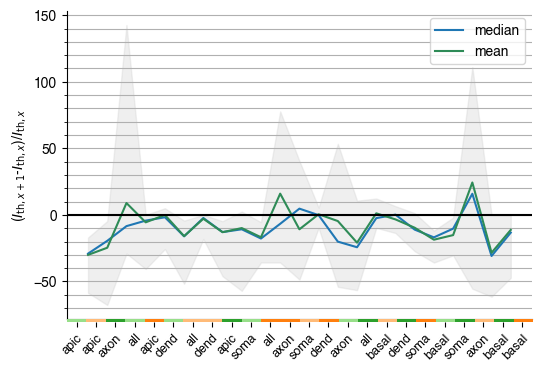

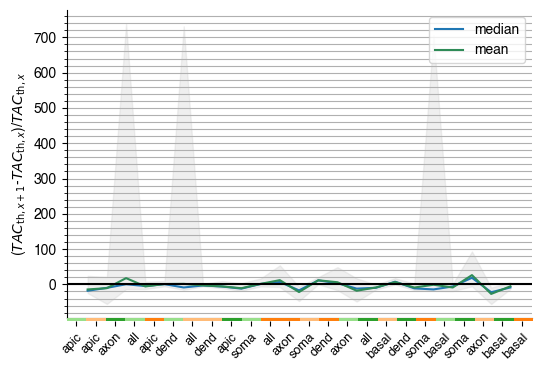

In [59]:
features = ['amp', 'TAC']
classes = ['neurontemplate', 'opsinlocations', 'Gmax', 'dur']
# wsrt_df = statistics_df[features+classes].copy()
idx = (master_df['neurontemplate'] == 'bc_1') | (
    master_df['neurontemplate'] == 'bc_2')
wsrt_df = master_df.loc[~idx, features+classes].copy()
wsrt_df['wsrt_keys'] = wsrt_df.apply(
    lambda x: f"{x['neurontemplate']}{x['opsinlocations']}", axis=1)
print(wsrt_df['wsrt_keys'].unique())


WSRT_dict = {}
ukeys = wsrt_df['wsrt_keys'].unique()
for feat in features:
    WSRT_dict[feat] = {}
    mytest_WSRT = np.ones((len(ukeys), len(ukeys), 2))
    for i in range(len(ukeys)):
        for j in range(len(ukeys)):
            df1 = wsrt_df[wsrt_df['wsrt_keys'] == ukeys[i]]
            df2 = wsrt_df[wsrt_df['wsrt_keys'] == ukeys[j]]
            df1 = df1.set_index([x for x in ['Gmax', 'dur']])[feat]
            df2 = df2.set_index([x for x in ['Gmax', 'dur']])[feat]
            diff_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=(
                '_0', '_1'), validate='one_to_many')
            diff_df = diff_df[feat+'_1']-diff_df[feat+'_0']
            xydiff = np.array(diff_df)
            xydiff = xydiff[~(np.isnan(xydiff) | np.isinf(xydiff))]
            if len(xydiff) > 0 and i != j:
                wstats = stats.wilcoxon(xydiff, alternative='greater')
                mytest_WSRT[i, j, 0] = wstats[0]
                mytest_WSRT[i, j, 1] = wstats[1]
    WSRT_dict[feat] = mytest_WSRT


# row_colors = np.array(sns.color_palette("tab20"))
# row_colors = row_colors[[2,3,0,1],:]
row_colors_dict = {x: colorkeyval[x]
                   for x in wsrt_df['neurontemplate'].unique()}
# row_colors = np.tile(np.array([[1,0,0,0.99],[0,1,0,0.99]]),(int(len(ukeys)/2),1))[:,None,:]
row_colors_dict

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
for ifeat, (feat, ax) in enumerate(zip(features, axs)):
    greatest = np.sum(WSRT_dict[feat][:, :, 1] < 0.001, axis=1)+0.5*np.sum((WSRT_dict[feat][:, :, 1] < 0.01) & (WSRT_dict[feat][:, :, 1] >= 0.001), axis=1)\
        + 0.1*np.sum((WSRT_dict[feat][:, :, 1] < 0.05)
                     & (WSRT_dict[feat][:, :, 1] >= 0.01), axis=1)
    if ifeat == 0:
        idx_column = np.argsort(greatest)
        idx_row = np.flip(idx_column)
    row_labels = ukeys[idx_row]
    column_labels = ukeys[idx_column]
    row_colors = np.array([i for x in row_labels for k,
                          i in row_colors_dict.items() if k in x])[:, None, :]
    column_colors = np.array(
        [i for x in column_labels for k, i in row_colors_dict.items() if k in x])[None, :, :]
    row_labels = [x.rsplit('_', 1)[1][1:] for x in row_labels]
    column_labels = [x.rsplit('_', 1)[1][1:] for x in column_labels]
    row_labels = [cvrt_label[x] for x in row_labels]
    if ifeat == 1:
        row_labels = ['' for x in row_labels]
    column_labels = [cvrt_label[x] for x in column_labels]

    data_toplot = WSRT_dict[feat][:, idx_column, 1]
    im, cbar = heatmap_colorcode(data_toplot[idx_row, :], row_labels, column_labels, ax=ax, row_colors=row_colors,
                                 column_colors=column_colors, norm=boundnorm_pvalue, cmap=crestcmap_pvalue, cbarlabel='p-value', labelfs=8, lw_grid=0.5)
    if feat == classes[0]:
        ax[ifeat].set_title(feat)
    if ifeat == 0:
        cbar.remove()
fig.suptitle(f'row less than column')
legendpatches = []
for k, v in row_colors_dict.items():
    legendpatches.append(mpl.patches.Patch(color=v, label=k))
fig.legend(handles=legendpatches, bbox_to_anchor=(0.93, 0.98), ncol=2)


ukeys_row = ukeys[idx_row]
ukeys_column = ukeys[idx_column]

quantChange_dict = {}
for feat in features:
    quantChange_dict[feat] = {}
    mytest_qC = np.full((len(ukeys), len(ukeys), 4), np.nan)
    for i, r in enumerate(ukeys_row):
        for j, c in enumerate(ukeys_column):
            if j < (len(ukeys_row)-i):
                df1 = wsrt_df[wsrt_df['wsrt_keys'] == r]
                df2 = wsrt_df[wsrt_df['wsrt_keys'] == c]
                df1 = df1.set_index([x for x in ['Gmax', 'dur']])[feat]
                df2 = df2.set_index([x for x in ['Gmax', 'dur']])[feat]
                diff_df = pd.merge(df1, df2, left_index=True, right_index=True, suffixes=(
                    '_0', '_1'), validate='one_to_many')
                diff_df = (diff_df[feat+'_1'] -
                           diff_df[feat+'_0'])/diff_df[feat+'_1']
                xydiff = np.array(diff_df)
                xydiff = xydiff[~(np.isnan(xydiff) | np.isinf(xydiff))]
                if len(xydiff) > 0 and r != c:
                    mytest_qC[i, j, 0] = np.median(xydiff)
                    mytest_qC[i, j, 1] = np.mean(xydiff)
                    mytest_qC[i, j, 2] = np.min(xydiff)
                    mytest_qC[i, j, 3] = np.max(xydiff)
    quantChange_dict[feat] = mytest_qC
cmap = sns.color_palette("crest", as_cmap=True)

fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10, 5))
for ifeat, (feat, ax) in enumerate(zip(range(2), axs)):

    data_toplot = quantChange_dict['amp'][:, :, feat]
    im, cbar = heatmap_colorcode(data_toplot, row_labels, column_labels, ax=ax, row_colors=row_colors,
                                 column_colors=column_colors, cmap=cmap, cbarlabel='', labelfs=8, lw_grid=0.5)


fig.suptitle(f'row less than column')
legendpatches = []
for k, v in row_colors_dict.items():
    legendpatches.append(mpl.patches.Patch(color=v, label=k))
fig.legend(handles=legendpatches, bbox_to_anchor=(0.93, 0.98), ncol=2)

# line plot of incremental change
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
labels = ['median', 'mean']
clrs = ['tab:blue', 'seagreen']
for i, (l, clr) in enumerate(zip(labels, clrs)):
    data_toplot = quantChange_dict['amp'][:, :, i]
    y = np.fliplr(data_toplot).diagonal(offset=1)
    y = np.flip(np.append([np.nan], y))
    ax.plot(np.arange(len(ukeys_row)), -100*y, label=l, color=clr)

data_toplot = quantChange_dict['amp'][:, :, 3]
y = np.fliplr(data_toplot).diagonal(offset=1)
mymax = np.flip(np.append([np.nan], -100*y))
data_toplot = quantChange_dict['amp'][:, :, 2]
y = np.fliplr(data_toplot).diagonal(offset=1)
mymin = np.flip(np.append([np.nan], -100*y))
ax.fill_between(np.arange(len(ukeys_row)), mymin,
                mymax, alpha=0.3, color=[0.8, 0.8, 0.8])
ax.axhline(0, color='k')

# colored x-axis
ax_column_cols = ax.inset_axes([0, -0.01, 1, 0.01,])
ax_column_cols.spines[:].set_visible(False)
ax_column_cols.imshow(column_colors, aspect='auto')
ax_column_cols.set_xticks(np.arange(len(ukeys_row)),
                          labels=column_labels, fontsize=9)
ax_column_cols.set_xticks(np.arange(len(ukeys_row)+1)-.5, minor=True)
ax_column_cols.set_yticks([])
ax_column_cols.tick_params(which="minor", bottom=False, left=False)
ax.set_xticks([])
# Let the horizontal axes labeling appear on top.
ax_column_cols.tick_params(top=False, bottom=True,
                           labeltop=False, labelbottom=True)
# Rotate the tick labels and set their alignment.
plt.setp(ax_column_cols.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.minorticks_on()
ax.tick_params(axis='y', which='minor')
ax.tick_params(axis='x', which='minor', bottom=False)
ax.grid(visible=True, axis='y')
ax.grid(visible=True, which='minor', axis='y')
ax.legend()
ax.set_ylabel(
    '($I_{\mathrm{th},x+1}$-$I_{\mathrm{th},x}$)/$I_{\mathrm{th},x}$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i, x in enumerate(['median', 'mean', 'min', 'max']):
    data_toplot = quantChange_dict['amp'][:, :, i]
    y = -100*np.flip(np.fliplr(data_toplot).diagonal(offset=1))
    print(f'{x} incremental rel change [%]:\nmed\t', np.median(
        y), '\nmean\t', np.mean(y))
fig.savefig('incrIth4pyr.svg', dpi=300)

# line plot of incremental change TAC
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
for i, (l, clr) in enumerate(zip(labels, clrs)):
    data_toplot = quantChange_dict['TAC'][:, :, i]
    y = np.fliplr(data_toplot).diagonal(offset=1)
    y = np.flip(np.append([np.nan], y))
    ax.plot(np.arange(len(ukeys_row)), -100*y, label=l, color=clr)

data_toplot = quantChange_dict['TAC'][:, :, 3]
y = np.fliplr(data_toplot).diagonal(offset=1)
mymax = np.flip(np.append([np.nan], -100*y))
data_toplot = quantChange_dict['TAC'][:, :, 2]
y = np.fliplr(data_toplot).diagonal(offset=1)
mymin = np.flip(np.append([np.nan], -100*y))
ax.fill_between(np.arange(len(ukeys_row)), mymin,
                mymax, alpha=0.3, color=[0.8, 0.8, 0.8])
ax.axhline(0, color='k')

# colored x-axis
ax_column_cols = ax.inset_axes([0, -0.01, 1, 0.01,])
ax_column_cols.spines[:].set_visible(False)
ax_column_cols.imshow(column_colors, aspect='auto')
ax_column_cols.set_xticks(np.arange(len(ukeys_row)),
                          labels=column_labels, fontsize=9)
ax_column_cols.set_xticks(np.arange(len(ukeys_row)+1)-.5, minor=True)
ax_column_cols.set_yticks([])
ax_column_cols.tick_params(which="minor", bottom=False, left=False)
ax.set_xticks([])
# Let the horizontal axes labeling appear on top.
ax_column_cols.tick_params(top=False, bottom=True,
                           labeltop=False, labelbottom=True)
# Rotate the tick labels and set their alignment.
plt.setp(ax_column_cols.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


ax.minorticks_on()
ax.tick_params(axis='y', which='minor')
ax.tick_params(axis='x', which='minor', bottom=False)
ax.grid(visible=True, axis='y')
ax.grid(visible=True, which='minor', axis='y')
ax.legend()
ax.set_ylabel(
    '($TAC_{\mathrm{th},x+1}$-$TAC_{\mathrm{th},x}$)/$TAC_{\mathrm{th},x}$')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for i, x in enumerate(['median', 'mean', 'min', 'max']):
    data_toplot = quantChange_dict['TAC'][:, :, i]
    y = -100*np.flip(np.fliplr(data_toplot).diagonal(offset=1))
    print(f'{x} incremental rel change TAC [%]:\nmed\t', np.median(
        y), '\nmean\t', np.mean(y))
fig.savefig('incrTACth4pyr.svg', dpi=300)



 ['pyr_1', 'pyr_3']
                mean median  amax  amin quant1 quant3   IQR
                diff   diff  diff  diff   diff   diff  diff
opsinlocations                                             
alldend        -0.31  -0.32 -0.16 -0.67  -0.35  -0.20  0.15
allsec         -0.32  -0.33 -0.17 -0.65  -0.37  -0.22  0.15
apic           -0.28  -0.30 -0.17 -0.81  -0.31  -0.21  0.10
axon            0.83   0.81  2.97 -0.43   0.42   1.22  0.81
basaldend       0.14   0.15  0.90  0.00   0.02   0.18  0.16
soma           -0.31  -0.33 -0.17 -0.51  -0.36  -0.22  0.14


 ['pyr_2', 'pyr_4']
                mean median  amax  amin quant1 quant3   IQR
                diff   diff  diff  diff   diff   diff  diff
opsinlocations                                             
alldend         0.23   0.23  1.35  0.06   0.13   0.30  0.18
allsec          0.29   0.30  3.69  0.09   0.15   0.34  0.19
apic            0.47   0.41  1.41  0.21   0.30   0.44  0.14
axon            0.92   0.78  1.97  0.50   0.70   1.05  0

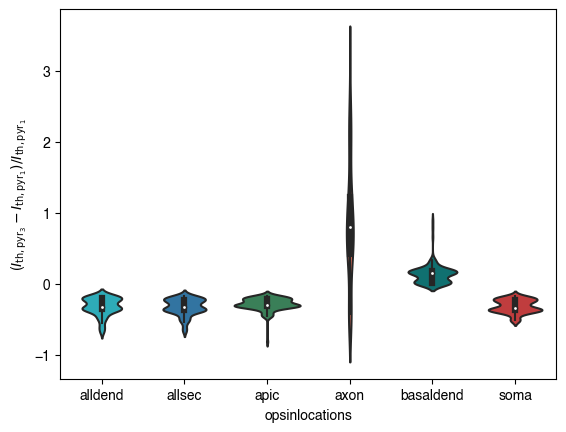

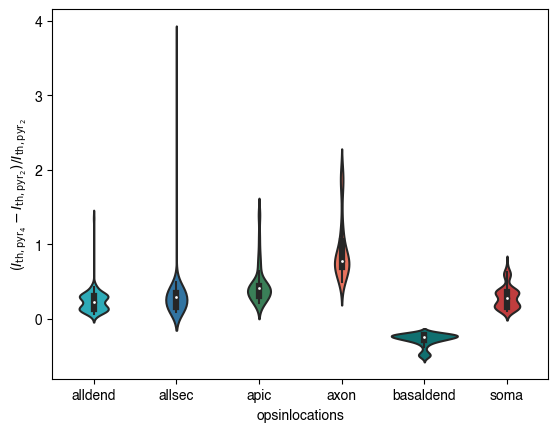

In [60]:
def quant1(x: pd.Series):
    return x.quantile(.25)


def quant3(x: pd.Series):
    return x.quantile(.75)


def IQR(x: pd.Series):
    return x.quantile(.75)-x.quantile(.25)


set1 = ['pyr_1', 'pyr_3']
set2 = ['pyr_2', 'pyr_4']
feat = 'amp'
features = ['amp', 'TAC']
classes = ['neurontemplate', 'opsinlocations', 'Gmax_log10', 'dur']
# wsrt_df = statistics_df[features+classes].copy()
idx = (master_df['neurontemplate'] == 'bc_1') | (
    master_df['neurontemplate'] == 'bc_2')
wsrt_df = master_df.loc[~idx, features+classes].copy()
for s in [set1, set2]:
    df1 = wsrt_df[wsrt_df['neurontemplate'] == s[0]]
    df2 = wsrt_df[wsrt_df['neurontemplate'] == s[1]]
    df1 = df1.set_index(
        [x for x in ['Gmax_log10', 'dur', 'opsinlocations']])[feat]
    df2 = df2.set_index(
        [x for x in ['Gmax_log10', 'dur', 'opsinlocations']])[feat]
    diff_df = pd.merge(df1, df2, left_index=True, right_index=True,
                       suffixes=('_0', '_1'), validate='one_to_many')
    diff_df['diff'] = (diff_df[feat+'_1']-diff_df[feat+'_0']
                       )/diff_df[feat+'_0']
    diff_df = diff_df.reset_index()
    fig, ax = plt.subplots(1, 1)
    sns.violinplot(diff_df, x='opsinlocations',
                   y='diff', ax=ax, palette=colorkeyval)
    ax.set_ylabel(
        f'($I_\mathrm{{th,{s[1]}}}-I_\mathrm{{th,{s[0]}}})/I_\mathrm{{th,{s[0]}}}$')
    print('\n\n', s)
    table = np.round(pd.pivot_table(diff_df[['diff', 'opsinlocations']], index=['opsinlocations'],
                                    aggfunc=[np.mean, np.median, np.max, np.min, quant1, quant3, IQR]), 2)
    print(table)

#### More comparison plots but none used 

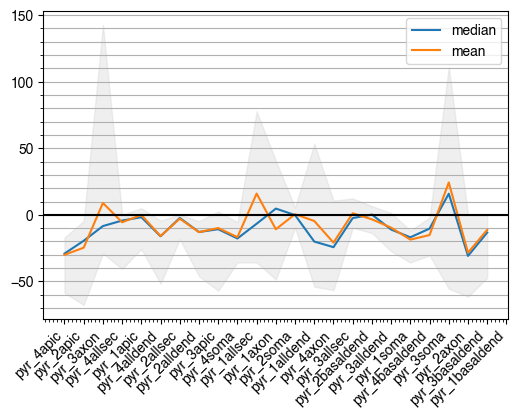

In [61]:

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
labels = ['median', 'mean']
for i, l in enumerate(labels):
    data_toplot = quantChange_dict['amp'][:, :, i]
    y = np.fliplr(data_toplot).diagonal(offset=1)
    y = np.flip(np.append([np.nan], y))
    ax.plot(np.flip(ukeys_row), -100*y, label=l)

data_toplot = quantChange_dict['amp'][:, :, 3]
y = np.fliplr(data_toplot).diagonal(offset=1)
mymax = np.flip(np.append([np.nan], -100*y))
data_toplot = quantChange_dict['amp'][:, :, 2]
y = np.fliplr(data_toplot).diagonal(offset=1)
mymin = np.flip(np.append([np.nan], -100*y))
ax.fill_between(np.flip(ukeys_row), mymin, mymax,
                alpha=0.3, color=[0.8, 0.8, 0.8])
ax.axhline(0, color='k')
for label in ax.get_xticklabels():
    label.set_ha("right")
    label.set_rotation(45)
ax.minorticks_on()
ax.tick_params(axis='y', which='minor')
ax.grid(visible=True, axis='y')
ax.grid(visible=True, which='minor', axis='y')
ax.legend()
plt.show()
print()

               dur        Gmax       amp_0       amp_1         amp
count   773.000000  773.000000  773.000000  773.000000  773.000000
mean    160.818329   13.029957    1.428503    0.763330    1.279190
std     310.550070   22.672185   18.130088    4.818281    0.456233
min       0.100000    0.100000    0.000034    0.000034    0.252206
25%       1.000000    1.000000    0.004286    0.003239    0.979979
50%      10.000000    2.682700    0.031323    0.027469    1.295449
75%     100.000000   13.895000    0.248213    0.195672    1.539591
max    1000.000000  100.000000  493.750000   95.078125    5.193098
               dur        Gmax       amp_0       amp_1         amp
count   773.000000  773.000000  773.000000  773.000000  773.000000
mean    160.818329   13.029957    1.428503    0.763330    0.360462
std     310.550070   22.672185   18.130088    4.818281    0.355219
min       0.100000    0.100000    0.000034    0.000034    0.003153
25%       1.000000    1.000000    0.004286    0.003239    0.19

dur    Gmax opsinlocations     amp_0  amp_1       amp
549  0.1  0.4642           axon  5.359375  21.25  2.965015

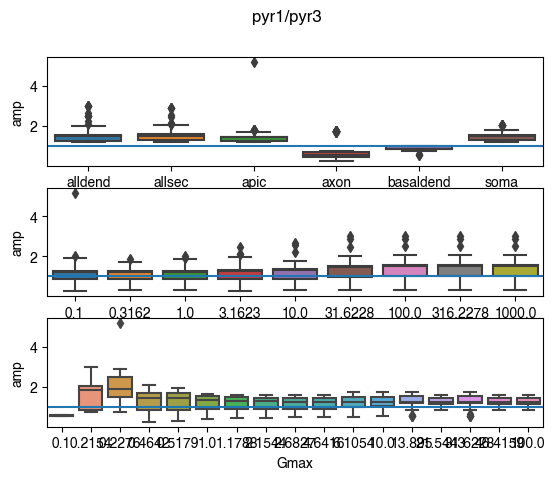

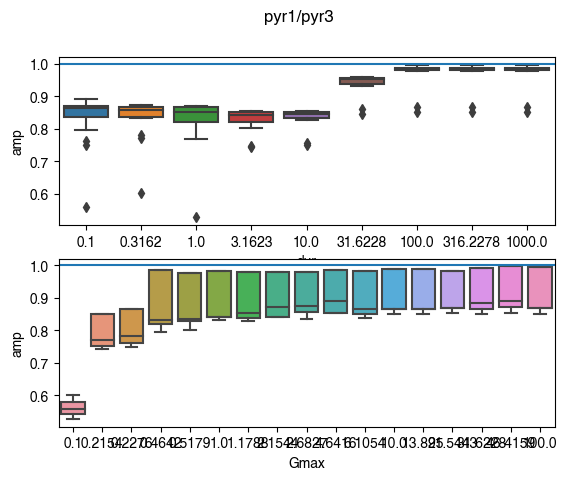

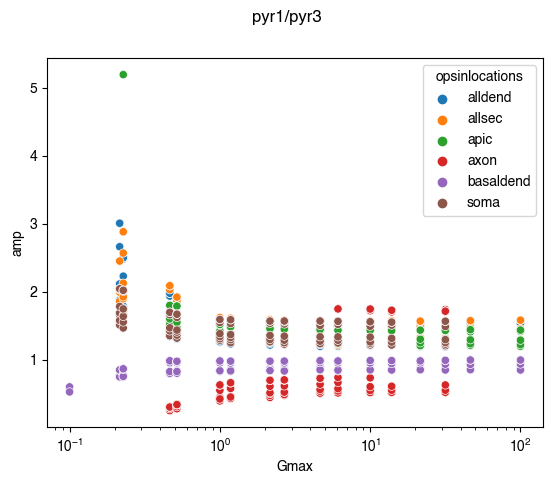

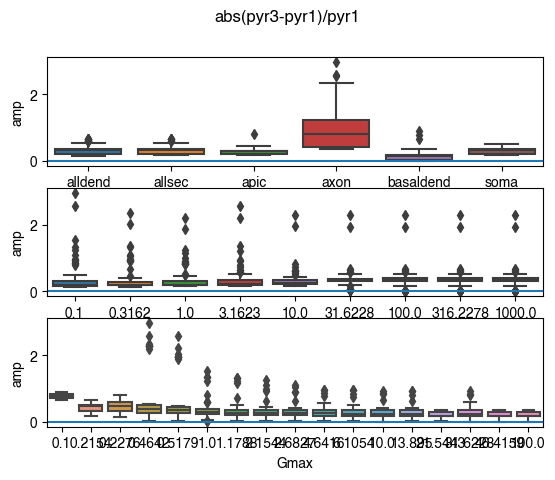

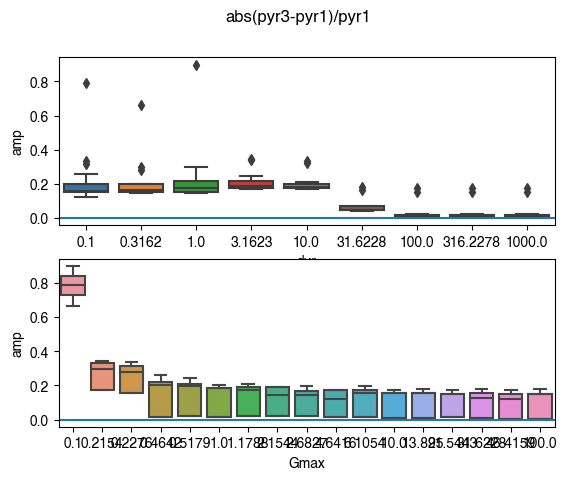

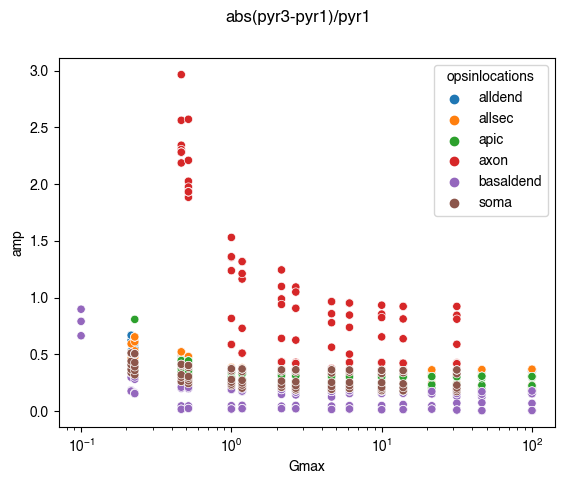

In [62]:

intm_df = master_df[['amp', 'dur', 'Gmax',
                     'neurontemplate', 'opsinlocations']].copy()
intm_df1 = intm_df[intm_df['neurontemplate'] == 'pyr_1']
intm_df2 = intm_df[intm_df['neurontemplate'] == 'pyr_3']
intm_df1 = intm_df1.set_index(['dur', 'Gmax', 'opsinlocations'])[['amp']]
intm_df2 = intm_df2.set_index(['dur', 'Gmax', 'opsinlocations'])[['amp']]
diff_df = pd.merge(intm_df1, intm_df2, left_index=True,
                   right_index=True, suffixes=('_0', '_1'), validate='one_to_many')
diff_df['amp'] = diff_df['amp_0']/diff_df['amp_1']
diff_df = diff_df.reset_index()
idxnotnan = ~(np.isnan(diff_df['amp']) | np.isinf(diff_df['amp']))
print(diff_df[idxnotnan].describe())
# sns.histplot(diff_df.loc[idxnotnan,'amp_log10'],stat='probability',ax=axs)
fig, axs = plt.subplots(3, 1)
sns.boxplot(diff_df, x='opsinlocations', y='amp', ax=axs[0])
sns.boxplot(diff_df, x='dur', y='amp', ax=axs[1])
sns.boxplot(diff_df, x='Gmax', y='amp', ax=axs[2])
for ax in axs:
    ax.axhline(1)
fig.suptitle('pyr1/pyr3')

fig, axs = plt.subplots(2, 1)
sns.boxplot(diff_df[diff_df['opsinlocations'] ==
            'basaldend'], x='dur', y='amp', ax=axs[0])
sns.boxplot(diff_df[diff_df['opsinlocations'] ==
            'basaldend'], x='Gmax', y='amp', ax=axs[1])
for ax in axs:
    ax.axhline(1)
fig.suptitle('pyr1/pyr3')

fig, axs = plt.subplots(1, 1)
sns.scatterplot(diff_df, x='Gmax', y='amp', hue='opsinlocations', ax=axs)
axs.set_xscale('log')
fig.suptitle('pyr1/pyr3')


# rell error
diff_df[diff_df['amp'] == diff_df['amp'].max()]
intm_df = master_df[['amp', 'dur', 'Gmax',
                     'neurontemplate', 'opsinlocations']].copy()
intm_df1 = intm_df[intm_df['neurontemplate'] == 'pyr_1']
intm_df2 = intm_df[intm_df['neurontemplate'] == 'pyr_3']
intm_df1 = intm_df1.set_index(['dur', 'Gmax', 'opsinlocations'])[['amp']]
intm_df2 = intm_df2.set_index(['dur', 'Gmax', 'opsinlocations'])[['amp']]
diff_df = pd.merge(intm_df1, intm_df2, left_index=True,
                   right_index=True, suffixes=('_0', '_1'), validate='one_to_many')
diff_df['amp'] = np.abs(diff_df['amp_1']-diff_df['amp_0'])/diff_df['amp_0']
diff_df = diff_df.reset_index()
idxnotnan = ~(np.isnan(diff_df['amp']) | np.isinf(diff_df['amp']))
print(diff_df[idxnotnan].describe())
# sns.histplot(diff_df.loc[idxnotnan,'amp_log10'],stat='probability',ax=axs)
fig, axs = plt.subplots(3, 1)
sns.boxplot(diff_df, x='opsinlocations', y='amp', ax=axs[0])
sns.boxplot(diff_df, x='dur', y='amp', ax=axs[1])
sns.boxplot(diff_df, x='Gmax', y='amp', ax=axs[2])
for ax in axs:
    ax.axhline(0)
fig.suptitle('abs(pyr3-pyr1)/pyr1')

fig, axs = plt.subplots(2, 1)
sns.boxplot(diff_df[diff_df['opsinlocations'] ==
            'basaldend'], x='dur', y='amp', ax=axs[0])
sns.boxplot(diff_df[diff_df['opsinlocations'] ==
            'basaldend'], x='Gmax', y='amp', ax=axs[1])
for ax in axs:
    ax.axhline(0)
fig.suptitle('abs(pyr3-pyr1)/pyr1')

fig, axs = plt.subplots(1, 1)
sns.scatterplot(diff_df, x='Gmax', y='amp', hue='opsinlocations', ax=axs)
axs.set_xscale('log')
fig.suptitle('abs(pyr3-pyr1)/pyr1')

diff_df[diff_df['amp'] == diff_df['amp'].max()]

               dur        Gmax       amp_0       amp_1         amp
count   740.000000  740.000000  740.000000  740.000000  740.000000
mean    160.082710   13.599637    1.074817    2.514094    0.860687
std     310.040406   23.008022    9.132932   33.667814    0.310539
min       0.100000    0.215400    0.000071    0.000057    0.213346
25%       1.000000    1.000000    0.004939    0.005670    0.703134
50%      10.000000    4.641600    0.035010    0.038974    0.772187
75%     100.000000   13.895000    0.227108    0.289844    0.890332
max    1000.000000  100.000000  177.343750  831.250000    2.069922
               dur        Gmax       amp_0       amp_1         amp
count   740.000000  740.000000  740.000000  740.000000  740.000000
mean    160.082710   13.599637    1.074817    2.514094    0.407406
std     310.040406   23.008022    9.132932   33.667814    0.344910
min       0.100000    0.215400    0.000071    0.000057    0.061644
25%       1.000000    1.000000    0.004939    0.005670    0.21

dur    Gmax opsinlocations      amp_0   amp_1       amp
234  0.1  0.2276         allsec  177.34375  831.25  3.687225

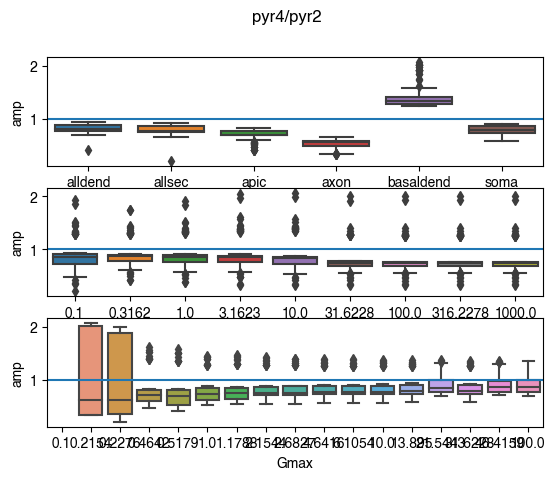

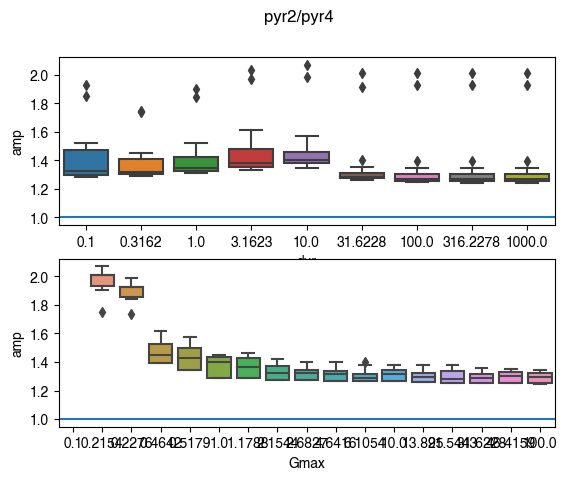

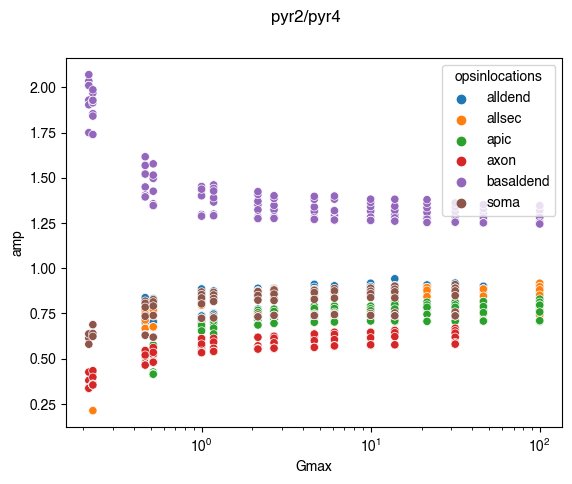

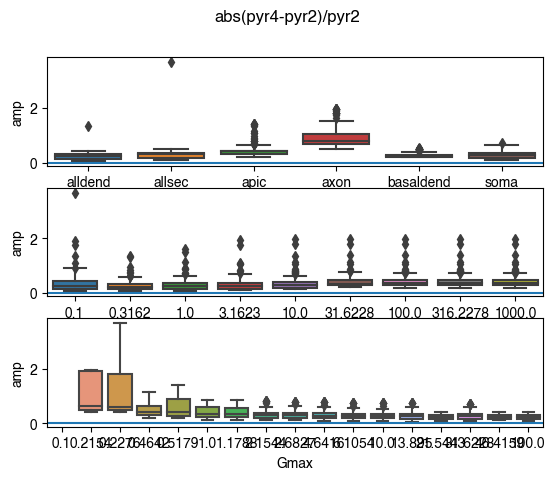

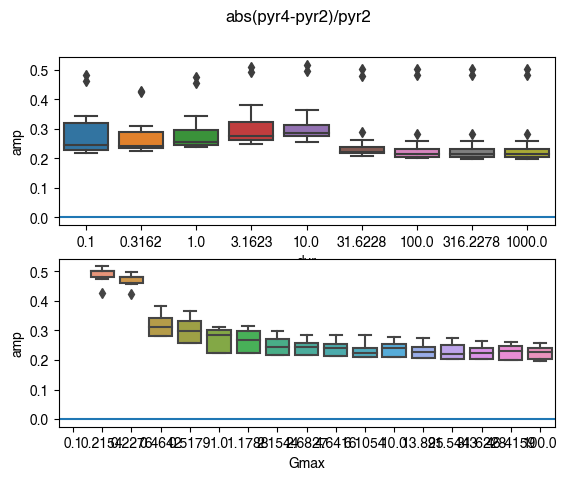

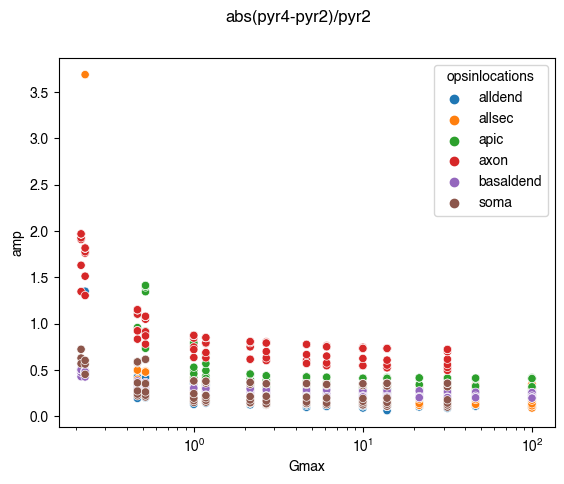

In [63]:

intm_df = master_df[['amp', 'dur', 'Gmax',
                     'neurontemplate', 'opsinlocations']].copy()
intm_df1 = intm_df[intm_df['neurontemplate'] == 'pyr_2']
intm_df2 = intm_df[intm_df['neurontemplate'] == 'pyr_4']
intm_df1 = intm_df1.set_index(['dur', 'Gmax', 'opsinlocations'])[['amp']]
intm_df2 = intm_df2.set_index(['dur', 'Gmax', 'opsinlocations'])[['amp']]
diff_df = pd.merge(intm_df1, intm_df2, left_index=True,
                   right_index=True, suffixes=('_0', '_1'), validate='one_to_many')
diff_df['amp'] = diff_df['amp_0']/diff_df['amp_1']
diff_df = diff_df.reset_index()
idxnotnan = ~(np.isnan(diff_df['amp']) | np.isinf(diff_df['amp']))
print(diff_df[idxnotnan].describe())
# sns.histplot(diff_df.loc[idxnotnan,'amp_log10'],stat='probability',ax=axs)
fig, axs = plt.subplots(3, 1)
sns.boxplot(diff_df, x='opsinlocations', y='amp', ax=axs[0])
sns.boxplot(diff_df, x='dur', y='amp', ax=axs[1])
sns.boxplot(diff_df, x='Gmax', y='amp', ax=axs[2])
for ax in axs:
    ax.axhline(1)
fig.suptitle('pyr4/pyr2')

fig, axs = plt.subplots(2, 1)
sns.boxplot(diff_df[diff_df['opsinlocations'] ==
            'basaldend'], x='dur', y='amp', ax=axs[0])
sns.boxplot(diff_df[diff_df['opsinlocations'] ==
            'basaldend'], x='Gmax', y='amp', ax=axs[1])
for ax in axs:
    ax.axhline(1)
fig.suptitle('pyr2/pyr4')

fig, axs = plt.subplots(1, 1)
sns.scatterplot(diff_df, x='Gmax', y='amp', hue='opsinlocations', ax=axs)
axs.set_xscale('log')
fig.suptitle('pyr2/pyr4')


# rell error
diff_df[diff_df['amp'] == diff_df['amp'].max()]
intm_df = master_df[['amp', 'dur', 'Gmax',
                     'neurontemplate', 'opsinlocations']].copy()
intm_df1 = intm_df[intm_df['neurontemplate'] == 'pyr_2']
intm_df2 = intm_df[intm_df['neurontemplate'] == 'pyr_4']
intm_df1 = intm_df1.set_index(['dur', 'Gmax', 'opsinlocations'])[['amp']]
intm_df2 = intm_df2.set_index(['dur', 'Gmax', 'opsinlocations'])[['amp']]
diff_df = pd.merge(intm_df1, intm_df2, left_index=True,
                   right_index=True, suffixes=('_0', '_1'), validate='one_to_many')
diff_df['amp'] = np.abs(diff_df['amp_1']-diff_df['amp_0'])/diff_df['amp_0']
diff_df = diff_df.reset_index()
idxnotnan = ~(np.isnan(diff_df['amp']) | np.isinf(diff_df['amp']))
print(diff_df[idxnotnan].describe())
# sns.histplot(diff_df.loc[idxnotnan,'amp_log10'],stat='probability',ax=axs)
fig, axs = plt.subplots(3, 1)
sns.boxplot(diff_df, x='opsinlocations', y='amp', ax=axs[0])
sns.boxplot(diff_df, x='dur', y='amp', ax=axs[1])
sns.boxplot(diff_df, x='Gmax', y='amp', ax=axs[2])
for ax in axs:
    ax.axhline(0)
fig.suptitle('abs(pyr4-pyr2)/pyr2')

fig, axs = plt.subplots(2, 1)
sns.boxplot(diff_df[diff_df['opsinlocations'] ==
            'basaldend'], x='dur', y='amp', ax=axs[0])
sns.boxplot(diff_df[diff_df['opsinlocations'] ==
            'basaldend'], x='Gmax', y='amp', ax=axs[1])
for ax in axs:
    ax.axhline(0)
fig.suptitle('abs(pyr4-pyr2)/pyr2')

fig, axs = plt.subplots(1, 1)
sns.scatterplot(diff_df, x='Gmax', y='amp', hue='opsinlocations', ax=axs)
axs.set_xscale('log')
fig.suptitle('abs(pyr4-pyr2)/pyr2')

diff_df[diff_df['amp'] == diff_df['amp'].max()]